# Daily Cycle

In [1]:
# Basic packages
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import math
import netCDF4 as nc

# DateTime packages
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
import time
import matplotlib.dates as mdates

# Stats packages
import scipy
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import seaborn as sns

# Logistical packages
import requests
from importlib import reload
import warnings
warnings.filterwarnings('ignore')

In [2]:
%cd '/Users/akbaskind/Documents/Python Scripts/phyto'
%run PLT.py
# Prophet package
from prophet import Prophet

/Users/akbaskind/Documents/Python Scripts/phyto


In [3]:
from __future__ import absolute_import, division, print_function

import logging

import numpy as np
import pandas as pd

from prophet.diagnostics import performance_metrics

logger = logging.getLogger('prophet.plot')



try:
    from matplotlib import pyplot as plt
    from matplotlib.dates import (
        MonthLocator,
        num2date,
        AutoDateLocator,
        AutoDateFormatter,
    )
    from matplotlib.ticker import FuncFormatter

    from pandas.plotting import deregister_matplotlib_converters
    deregister_matplotlib_converters()
except ImportError:
    logger.error('Importing matplotlib failed. Plotting will not work.')

try:
    import plotly.graph_objs as go
    from plotly.subplots import make_subplots
except ImportError:
    logger.error('Importing plotly failed. Interactive plots will not work.')

def plot_seasonality(m, name, ax=None, uncertainty=True, figsize=(10, 6), color = None, line = None):
    """Plot a custom seasonal component.

    Parameters
    ----------
    m: Prophet model.
    name: Seasonality name, like 'daily', 'weekly'.
    ax: Optional matplotlib Axes to plot on. One will be created if
        this is not provided.
    uncertainty: Optional boolean to plot uncertainty intervals, which will
        only be done if m.uncertainty_samples > 0.
    figsize: Optional tuple width, height in inches.

    Returns
    -------
    a list of matplotlib artists
    """
    artists = []
    if not ax:
        fig = plt.figure(facecolor='w', figsize=figsize)
        ax = fig.add_subplot(111)
    # Compute seasonality from Jan 1 through a single period.
    start = pd.to_datetime('2017-01-01 0000')
    period = m.seasonalities[name]['period']
    end = start + pd.Timedelta(days=period)
    plot_points = 200
    days = pd.to_datetime(np.linspace(start.value, end.value, plot_points))
    df_y = seasonality_plot_df(m, days)
    seas = m.predict_seasonal_components(df_y)
    if not color:
        color = 'blue'
    if not line:
        line = '-'
    artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls=line,
                        c=color, lw = 2)
    # if uncertainty and m.uncertainty_samples:
    #     artists += [ax.fill_between(
    #         df_y['ds'].dt.to_pydatetime(), seas[name + '_lower'],
    #         seas[name + '_upper'], color='#0072B2', alpha=0.2)]
    # ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    n_ticks = 8
    xticks = pd.to_datetime(np.linspace(start.value, end.value, n_ticks)
        ).to_pydatetime()
    ax.set_xticks(xticks)
    if name == 'yearly':
        fmt = FuncFormatter(
            lambda x, pos=None: '{dt:%B} {dt.day}'.format(dt=num2date(x)))
        ax.set_xlabel('Day of year')
    elif name == 'weekly':
        fmt = FuncFormatter(
            lambda x, pos=None: '{dt:%A}'.format(dt=num2date(x)))
        ax.set_xlabel('Day of Week')
    elif name == 'daily':
        fmt = FuncFormatter(
            lambda x, pos=None: '{dt:%T}'.format(dt=num2date(x)))
        ax.set_xlabel('Hour of day')
    elif period <= 2:
        fmt = FuncFormatter(
            lambda x, pos=None: '{dt:%T}'.format(dt=num2date(x)))
        ax.set_xlabel('Hours')
    else:
        fmt = FuncFormatter(
            lambda x, pos=None: '{:.0f}'.format(pos * period / (n_ticks - 1)))
        ax.set_xlabel('Days')
    ax.xaxis.set_major_formatter(fmt)
    ax.set_ylabel(name)
    if m.seasonalities[name]['mode'] == 'multiplicative':
        ax = set_y_as_percent(ax)
    return artists,df_y,seas

def seasonality_plot_df(m, ds):
    """Prepare dataframe for plotting seasonal components.

    Parameters
    ----------
    m: Prophet model.
    ds: List of dates for column ds.

    Returns
    -------
    A dataframe with seasonal components on ds.
    """
    df_dict = {'ds': ds, 'cap': 1., 'floor': 0.}
    for name in m.extra_regressors:
        df_dict[name] = 0.
    # Activate all conditional seasonality columns
    for props in m.seasonalities.values():
        if props['condition_name'] is not None:
            df_dict[props['condition_name']] = True
    df = pd.DataFrame(df_dict)
    df = m.setup_dataframe(df)
    return df


# Get data

In [4]:
#The scope is always look like this so we did not need to change anything

import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials

scope = [
   'https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

# Name of our Service Account Key
google_key_file = 'servicecredentials.json'
credentials = ServiceAccountCredentials.from_json_keyfile_name(google_key_file, scope)
gc = gspread.authorize(credentials)

# Spreadsheet key
spreadsheet_key = '1uLRAvFDsTSfS-c45DiG-W6VMa8I1J7XD1O-pJA4fp10'

# Worksheet keys
wks_hydrocat620 = 'Hydrocat 620'
wks_hydrocat720 = 'Hydrocat 720'
wks_MV = 'MV'
wks_QP = 'QP'

#Opening the worksheet by using Worksheet ID
workbook = gc.open_by_key(spreadsheet_key)

## HYDROCAT 620
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_hydrocat620)
values = sheet.get_all_values()
hydrocat620 = pd.DataFrame(values[1:], columns = values[0])


## HYDROCAT 720
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_hydrocat720)
values = sheet.get_all_values()
hydrocat720 = pd.DataFrame(values[1:], columns = values[0])

## MV
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_MV)
values = sheet.get_all_values()
MV = pd.DataFrame(values[1:], columns = values[0])

## QP
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_QP)
values = sheet.get_all_values()
QP = pd.DataFrame(values[1:], columns = values[0])

In [5]:
for k in hydrocat620.keys():
    if k == 'DateTime' or k == 'time':
        hydrocat620[k] = pd.to_datetime(hydrocat620[k])
    else:
        hydrocat620[k] = pd.to_numeric(hydrocat620[k])

for k in hydrocat720.keys():
    if k == 'DateTime' or k == 'time':
        hydrocat720[k] = pd.to_datetime(hydrocat720[k])
    else:
        hydrocat720[k] = pd.to_numeric(hydrocat720[k])
        
for k in QP.keys():
    if k == 'DateTime' or k == 'time':
        QP[k] = pd.to_datetime(QP[k])
    else:
        QP[k] = pd.to_numeric(QP[k])
        
for k in MV.keys():
    if k == 'DateTime' or k == 'time':
        MV[k] = pd.to_datetime(MV[k])
    else:
        MV[k] = pd.to_numeric(MV[k])

In [6]:
hydrocat620['DateTime'] = hydrocat620['DateTime'] - timedelta(hours = 4)
hydrocat720['DateTime'] = hydrocat720['DateTime'] - timedelta(hours = 4)
QP['DateTime'] = QP['DateTime'] - timedelta(hours = 4)
MV['DateTime'] = MV['DateTime'] - timedelta(hours = 4)

In [31]:
10**(-7.8) == np.power(10,-7.8)

True

# Hydrocat 620 by Month

In [32]:
hydrocat620['Month'] = np.zeros(len(hydrocat620['DateTime']))
hydrocat620['H'] = np.zeros(len(hydrocat620['DateTime']))
for i in hydrocat620.index:
    hydrocat620['Month'][i] = hydrocat620['DateTime'][i].month
    hydrocat620['H'][i] = np.power(10, -hydrocat620['pH final'][i])
hydrocat620

DateTime  Temperature [degC]  Salinity [PSU]  DO [mg/L]  \
0     2022-01-04 05:31:15.400              6.5078         30.7871      9.592   
1     2022-01-04 06:46:15.400              6.3631         30.8278      9.663   
2     2022-01-04 07:01:15.200              6.3063         30.7459      9.633   
3     2022-01-04 07:16:15.200              6.2367         30.7015      9.680   
4     2022-01-04 07:31:15.200              6.2593         30.6492      9.698   
...                       ...                 ...             ...        ...   
34421 2023-04-30 18:46:29.000             11.7928         28.4188      8.547   
34422 2023-04-30 19:01:29.000             11.7991         28.4178      8.472   
34423 2023-04-30 19:16:29.000             11.8380         28.3284      8.471   
34424 2023-04-30 19:31:29.000             11.9170         28.1962      8.406   
34425 2023-04-30 19:46:29.000             12.0443         28.0046      8.498   

       raw pH [total]  Fluorescence [ug-chl/L]  pH final  \
0            7.934479                    7.478  7.934479   
1            7.934814                    1.844  7.934814   
2            7.934773                    2.373  7.934773   
3            7.934821                    3.158  7.934821   
4            7.924688                    2.170  7.924688   
...               ...                      ...       ...   
34421        7.971222                    0.021  7.971222   
34422        7.961210                    0.020  7.961210   
34423        7.971013                    0.021  7.971013   
34424        7.970686                    0.020  7.970686   
34425        7.980192                    0.020  7.980192   

       pH (normalized to 15°C)  Month             H  
0                     7.797240    1.0  1.162843e-08  
1                     7.795139    1.0  1.161946e-08  
2                     7.794166    1.0  1.162056e-08  
3                     7.793057    1.0  1.161928e-08  
4                     7.783583    1.0  1.189358e-08  
...                        ...    ...           ...  
34421                 7.920264    4.0  1.068508e-08  
34422                 7.910442    4.0  1.093429e-08  
34423                 7.920790    4.0  1.069023e-08  
34424                 7.921743    4.0  1.069829e-08  
34425                 7.933227    4.0  1.046666e-08  

[34426 rows x 10 columns]

In [61]:
JAN = hydrocat620.where(hydrocat620['Month'] == 1).dropna()
FEB = hydrocat620.where(hydrocat620['Month'] == 2).dropna()
MAR = hydrocat620.where(hydrocat620['Month'] == 3).dropna()
APR = hydrocat620.where(hydrocat620['Month'] == 4).dropna()
MAY = hydrocat620.where(hydrocat620['Month'] == 5).dropna()
JUN = hydrocat620.where(hydrocat620['Month'] == 6).dropna()
JUL = hydrocat620.where(hydrocat620['Month'] == 7).dropna()
AUG = hydrocat620.where(hydrocat620['Month'] == 8).dropna()
SEP = hydrocat620.where(hydrocat620['Month'] == 9).dropna()
OCT = hydrocat620.where(hydrocat620['Month'] == 10).dropna()
NOV = hydrocat620.where(hydrocat620['Month'] == 11).dropna()
DEC = hydrocat620.where(hydrocat620['Month'] == 12).dropna()

In [66]:
# Create our data frames for ds and y
var = 'Temperature [degC]'
jan = JAN[['DateTime', var]]
feb = FEB[['DateTime', var]]
mar = MAR[['DateTime', var]]
apr = APR[['DateTime', var]]
may = MAY[['DateTime', var]]
jun = JUN[['DateTime', var]]
jul = JUL[['DateTime', var]]
aug = AUG[['DateTime', var]]
sep = SEP[['DateTime', var]]
octo = OCT[['DateTime', var]]
nov = NOV[['DateTime', var]]
dec = DEC[['DateTime', var]]

# Rename DateTime as ds and pH total as y
jan = jan.rename(columns = {'DateTime': 'ds', var: 'y'})
feb = feb.rename(columns = {'DateTime': 'ds', var: 'y'})
mar = mar.rename(columns = {'DateTime': 'ds', var: 'y'})
apr = apr.rename(columns = {'DateTime': 'ds', var: 'y'})
may = may.rename(columns = {'DateTime': 'ds', var: 'y'})
jun = jun.rename(columns = {'DateTime': 'ds', var: 'y'})
jul = jul.rename(columns = {'DateTime': 'ds', var: 'y'})
aug = aug.rename(columns = {'DateTime': 'ds', var: 'y'})
sep = sep.rename(columns = {'DateTime': 'ds', var: 'y'})
octo = octo.rename(columns = {'DateTime': 'ds', var: 'y'})
nov = nov.rename(columns = {'DateTime': 'ds', var: 'y'})
dec = dec.rename(columns = {'DateTime': 'ds', var: 'y'})

# Instatiate Prophet object
m_jan = Prophet()
m_feb = Prophet()
m_mar = Prophet()
m_apr = Prophet()
m_may = Prophet()
m_jun = Prophet()
m_jul = Prophet()
m_aug = Prophet()
m_sep = Prophet()
m_octo = Prophet()
m_nov = Prophet()
m_dec = Prophet()

# Fit Prophet object
m_jan.fit(jan)
m_feb.fit(feb)
m_mar.fit(mar)
m_apr.fit(apr)
# m_may.fit(may)
m_jun.fit(jun)
m_jul.fit(jul)
m_aug.fit(aug)
m_sep.fit(sep)
m_octo.fit(octo)
m_nov.fit(nov)
m_dec.fit(dec)

17:48:19 - cmdstanpy - INFO - Chain [1] start processing
17:48:19 - cmdstanpy - INFO - Chain [1] done processing
17:48:19 - cmdstanpy - INFO - Chain [1] start processing
17:48:21 - cmdstanpy - INFO - Chain [1] done processing
17:48:21 - cmdstanpy - INFO - Chain [1] start processing
17:48:25 - cmdstanpy - INFO - Chain [1] done processing
17:48:25 - cmdstanpy - INFO - Chain [1] start processing
17:48:28 - cmdstanpy - INFO - Chain [1] done processing
17:48:28 - cmdstanpy - INFO - Chain [1] start processing
17:48:29 - cmdstanpy - INFO - Chain [1] done processing
17:48:29 - cmdstanpy - INFO - Chain [1] start processing
17:48:30 - cmdstanpy - INFO - Chain [1] done processing
17:48:30 - cmdstanpy - INFO - Chain [1] start processing
17:48:31 - cmdstanpy - INFO - Chain [1] done processing
17:48:31 - cmdstanpy - INFO - Chain [1] start processing
17:48:32 - cmdstanpy - INFO - Chain [1] done processing
17:48:32 - cmdstanpy - INFO - Chain [1] start processing
17:48:33 - cmdstanpy - INFO - Chain [1]

In [67]:
# Make history dataframes for each dataset
future_jan = m_jan.make_future_dataframe(periods=300)
future_feb = m_feb.make_future_dataframe(periods=1)
future_mar = m_mar.make_future_dataframe(periods=1)
future_apr = m_apr.make_future_dataframe(periods=1)
# future_may = m_may.make_future_dataframe(periods=0)
future_jun = m_jun.make_future_dataframe(periods=0)
future_jul = m_jul.make_future_dataframe(periods=0)
future_aug = m_aug.make_future_dataframe(periods=0)
future_sep = m_sep.make_future_dataframe(periods=0)
future_octo = m_octo.make_future_dataframe(periods=0)
future_nov = m_nov.make_future_dataframe(periods=0)
future_dec = m_dec.make_future_dataframe(periods=0)

forecast_jan = m_jan.predict(future_jan)
forecast_feb = m_feb.predict(future_feb)
forecast_mar = m_mar.predict(future_mar)
forecast_apr = m_apr.predict(future_apr)
# forecast_may = m_may.predict(future_may)
forecast_jun = m_jun.predict(future_jun)
forecast_jul = m_jul.predict(future_jul)
forecast_aug = m_aug.predict(future_aug)
forecast_sep = m_sep.predict(future_sep)
forecast_octo = m_octo.predict(future_octo)
forecast_nov = m_nov.predict(future_nov)
forecast_dec = m_dec.predict(future_dec)

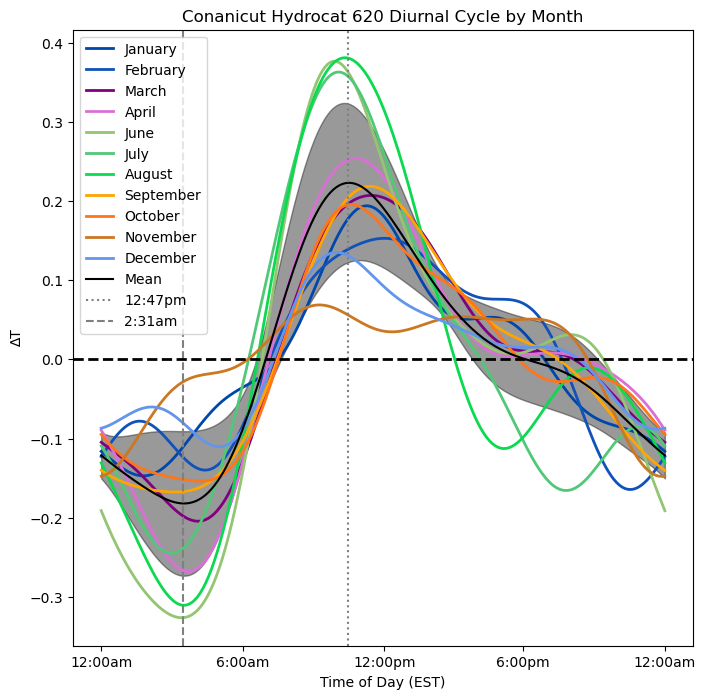

In [68]:
fig, ax = plt.subplots(figsize = [8,8])
[curve1,df1,seas1] = plot_seasonality(m_jan, 'daily', ax = ax, color = janclr)
[curve2,df2,seas2] = plot_seasonality(m_feb, 'daily', ax = ax, color = febclr)
[curve3,df3,seas3] = plot_seasonality(m_mar, 'daily', ax = ax, color = marclr)
[curve4,df4,seas4] = plot_seasonality(m_apr, 'daily', ax = ax, color = aprclr)
# [curve5,df5,seas5] = plot_seasonality(m_may, 'daily', ax = ax, color = mayclr)
[curve6,df6,seas6] = plot_seasonality(m_jun, 'daily', ax = ax, color = junclr)
[curve7,df7,seas7] = plot_seasonality(m_jul, 'daily', ax = ax, color = julclr)
[curve8,df8,seas8] = plot_seasonality(m_aug, 'daily', ax = ax, color = augclr)
[curve9,df9,seas9] = plot_seasonality(m_sep, 'daily', ax = ax, color = sepclr)
[curve10,df10,seas10] = plot_seasonality(m_octo, 'daily', ax = ax, color = octclr)
[curve11,df11,seas11] = plot_seasonality(m_nov, 'daily', ax = ax, color = novclr)
[curve12,df12,seas12] = plot_seasonality(m_dec, 'daily', ax = ax, color = decclr)

meansph = np.zeros(len(df1))
stdph = np.zeros(len(df1))
for i in df1.index:
    meansph[i] = np.mean([seas1['daily'][i],seas2['daily'][i],seas3['daily'][i],seas4['daily'][i],
                         seas6['daily'][i],seas7['daily'][i],seas8['daily'][i],seas9['daily'][i],
                         seas10['daily'][i],seas11['daily'][i],seas12['daily'][i]])
    stdph[i] = np.std([seas1['daily'][i],seas2['daily'][i],seas3['daily'][i],seas4['daily'][i],
                         seas6['daily'][i],seas7['daily'][i],seas8['daily'][i],seas9['daily'][i],
                         seas10['daily'][i],seas11['daily'][i],seas12['daily'][i]])
ax.plot(df1['ds'],meansph,color = 'black')

ax.set_ylabel('∆T')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('Conanicut Hydrocat 620 Diurnal Cycle by Month')
ax.set_xticks([df1['ds'][0],df1['ds'][50],df1['ds'][100],df1['ds'][149],df1['ds'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axvline(x = df1.iloc[np.argmax(meansph)]['ds'], ls = 'dotted', color = 'gray')
ax.axvline(x = df1.iloc[np.argmin(meansph)]['ds'], ls = 'dashed', color = 'gray')
ax.fill_between(df1['ds'], meansph + stdph, meansph - stdph, alpha = 0.4, color = 'k')
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.legend(['January', 'February', 'March', 'April', 'June', 'July', 'August', 'September',
           'October','November', 'December', 'Mean', '12:47pm', '2:31am'], loc = 'upper left')



In [69]:
hydro620t = {'Time': df1['ds'],
           'Hydrocat 620 Jan': seas1['daily'],
           'Hydrocat 620 Feb': seas2['daily'],
           'Hydrocat 620 Mar': seas3['daily'],
           'Hydrocat 620 Apr': seas4['daily'],
           # 'Hydrocat 620 May': seas5['daily'],
           'Hydrocat 620 Jun': seas6['daily'],
           'Hydrocat 620 Jul': seas7['daily'],
           'Hydrocat 620 Aug': seas8['daily'],
           'Hydrocat 620 Sep': seas9['daily'],
           'Hydrocat 620 Oct': seas10['daily'],
           'Hydrocat 620 Nov': seas11['daily'],
           'Hydrocat 620 Dec': seas12['daily'],
           'Hydrocat 620 Mean pH': meansph,
           'Hydrocat 620 Std pH': stdph}
hydro620t = pd.DataFrame(hydro620t)
hydro620t

Time  Hydrocat 620 Jan  Hydrocat 620 Feb  \
0   2017-01-01 00:00:00.000000000         -0.116137         -0.122689   
1   2017-01-01 00:07:14.170854144         -0.119106         -0.117457   
2   2017-01-01 00:14:28.341708544         -0.122099         -0.112299   
3   2017-01-01 00:21:42.512562688         -0.125080         -0.107288   
4   2017-01-01 00:28:56.683417088         -0.128015         -0.102496   
..                            ...               ...               ...   
195 2017-01-01 23:31:03.316582912         -0.105047         -0.142835   
196 2017-01-01 23:38:17.487437312         -0.107650         -0.138075   
197 2017-01-01 23:45:31.658291456         -0.110379         -0.133081   
198 2017-01-01 23:52:45.829145856         -0.113214         -0.127931   
199 2017-01-02 00:00:00.000000000         -0.116137         -0.122689   

     Hydrocat 620 Mar  Hydrocat 620 Apr  Hydrocat 620 Jun  Hydrocat 620 Jul  \
0           -0.104752         -0.089391         -0.191033         -0.109291   
1           -0.107338         -0.095278         -0.199708         -0.114884   
2           -0.109916         -0.101402         -0.208125         -0.120914   
3           -0.112502         -0.107759         -0.216271         -0.127328   
4           -0.115113         -0.114336         -0.224135         -0.134073   
..                ...               ...               ...               ...   
195         -0.094001         -0.068251         -0.154138         -0.092129   
196         -0.096776         -0.073171         -0.163634         -0.095562   
197         -0.099483         -0.078331         -0.172963         -0.099585   
198         -0.102135         -0.083732         -0.182098         -0.104170   
199         -0.104752         -0.089391         -0.191033         -0.109291   

     Hydrocat 620 Aug  Hydrocat 620 Sep  Hydrocat 620 Oct  Hydrocat 620 Nov  \
0           -0.130688         -0.140107         -0.094855         -0.147457   
1           -0.137962         -0.142489         -0.099032         -0.146478   
2           -0.145344         -0.144721         -0.103080         -0.144892   
3           -0.152829         -0.146807         -0.106978         -0.142723   
4           -0.160408         -0.148753         -0.110708         -0.140005   
..                ...               ...               ...               ...   
195         -0.102783         -0.129020         -0.077335         -0.144984   
196         -0.109563         -0.132025         -0.081779         -0.146576   
197         -0.116474         -0.134873         -0.086197         -0.147517   
198         -0.123512         -0.137565         -0.090562         -0.147809   
199         -0.130688         -0.140107         -0.094855         -0.147457   

     Hydrocat 620 Dec  Hydrocat 620 Mean pH  Hydrocat 620 Std pH  
0           -0.086940             -0.121213             0.029129  
1           -0.085879             -0.124147             0.030305  
2           -0.084552             -0.127031             0.031838  
3           -0.082993             -0.129869             0.033704  
4           -0.081240             -0.132662             0.035870  
..                ...                   ...                  ...  
195         -0.087978             -0.108955             0.027874  
196         -0.088242             -0.112096             0.027724  
197         -0.088146             -0.115185             0.027857  
198         -0.087705             -0.118221             0.028315  
199         -0.086940             -0.121213             0.029129  

[200 rows x 14 columns]

In [65]:
hydro620o2 = {'Time': df1['ds'],
           'Hydrocat 620 Jan': seas1['daily'],
           'Hydrocat 620 Feb': seas2['daily'],
           'Hydrocat 620 Mar': seas3['daily'],
           'Hydrocat 620 Apr': seas4['daily'],
           # 'Hydrocat 620 May': seas5['daily'],
           'Hydrocat 620 Jun': seas6['daily'],
           'Hydrocat 620 Jul': seas7['daily'],
           'Hydrocat 620 Aug': seas8['daily'],
           'Hydrocat 620 Sep': seas9['daily'],
           'Hydrocat 620 Oct': seas10['daily'],
           'Hydrocat 620 Nov': seas11['daily'],
           'Hydrocat 620 Dec': seas12['daily'],
           'Hydrocat 620 Mean pH': meansph,
           'Hydrocat 620 Std pH': stdph}
hydro620o2 = pd.DataFrame(hydro620o2)
hydro620o2

Time  Hydrocat 620 Jan  Hydrocat 620 Feb  \
0   2017-01-01 00:00:00.000000000         -0.133590          0.002623   
1   2017-01-01 00:07:14.170854144         -0.134317          0.000277   
2   2017-01-01 00:14:28.341708544         -0.135117         -0.002272   
3   2017-01-01 00:21:42.512562688         -0.136055         -0.005034   
4   2017-01-01 00:28:56.683417088         -0.137196         -0.008016   
..                            ...               ...               ...   
195 2017-01-01 23:31:03.316582912         -0.130129          0.010174   
196 2017-01-01 23:38:17.487437312         -0.131201          0.008544   
197 2017-01-01 23:45:31.658291456         -0.132095          0.006750   
198 2017-01-01 23:52:45.829145856         -0.132870          0.004781   
199 2017-01-02 00:00:00.000000000         -0.133590          0.002623   

     Hydrocat 620 Mar  Hydrocat 620 Apr  Hydrocat 620 Jun  Hydrocat 620 Jul  \
0            0.003442         -0.084935         -0.158833         -0.237891   
1            0.001278         -0.086437         -0.161984         -0.248146   
2           -0.001107         -0.087599         -0.164919         -0.259011   
3           -0.003709         -0.088437         -0.167622         -0.270388   
4           -0.006520         -0.088972         -0.170078         -0.282171   
..                ...               ...               ...               ...   
195          0.009849         -0.075367         -0.144422         -0.204508   
196          0.008584         -0.078292         -0.148254         -0.211575   
197          0.007097         -0.080864         -0.151945         -0.219526   
198          0.005385         -0.083077         -0.155475         -0.228311   
199          0.003442         -0.084935         -0.158833         -0.237891   

     Hydrocat 620 Aug  Hydrocat 620 Sep  Hydrocat 620 Oct  Hydrocat 620 Nov  \
0           -0.308332         -0.275697         -0.093860         -0.024944   
1           -0.319023         -0.281789         -0.094200         -0.027310   
2           -0.328986         -0.286988         -0.094691         -0.029809   
3           -0.338147         -0.291296         -0.095380         -0.032437   
4           -0.346441         -0.294722         -0.096312         -0.035189   
..                ...               ...               ...               ...   
195         -0.260056         -0.242777         -0.092991         -0.016837   
196         -0.272744         -0.252214         -0.093239         -0.018658   
197         -0.285084         -0.260873         -0.093432         -0.020615   
198         -0.296971         -0.268706         -0.093621         -0.022708   
199         -0.308332         -0.275697         -0.093860         -0.024944   

     Hydrocat 620 Dec  Hydrocat 620 Mean pH  Hydrocat 620 Std pH  
0           -0.012793             -0.120437             0.107879  
1           -0.015072             -0.124248             0.110595  
2           -0.017470             -0.127997             0.113121  
3           -0.019973             -0.131680             0.115439  
4           -0.022565             -0.135289             0.117537  
..                ...                   ...                  ...  
195         -0.005091             -0.104741             0.095510  
196         -0.006784             -0.108712             0.098775  
197         -0.008636             -0.112657             0.101941  
198         -0.010641             -0.116565             0.104982  
199         -0.012793             -0.120437             0.107879  

[200 rows x 14 columns]

In [37]:
hydro620 = {'Time': df1['ds'],
           'Hydrocat 620 Jan': seas1['daily'],
           'Hydrocat 620 Feb': seas2['daily'],
           'Hydrocat 620 Mar': seas3['daily'],
           'Hydrocat 620 Apr': seas4['daily'],
           # 'Hydrocat 620 May': seas5['daily'],
           'Hydrocat 620 Jun': seas6['daily'],
           'Hydrocat 620 Jul': seas7['daily'],
           'Hydrocat 620 Aug': seas8['daily'],
           'Hydrocat 620 Sep': seas9['daily'],
           'Hydrocat 620 Oct': seas10['daily'],
           'Hydrocat 620 Nov': seas11['daily'],
           'Hydrocat 620 Dec': seas12['daily'],
           'Hydrocat 620 Mean pH': meansph,
           'Hydrocat 620 Std pH': stdph}
hydro620 = pd.DataFrame(hydro620)
hydro620

Time  Hydrocat 620 Jan  Hydrocat 620 Feb  \
0   2017-01-01 00:00:00.000000000      5.640048e-10     -4.310810e-11   
1   2017-01-01 00:07:14.170854144      5.822192e-10     -3.897804e-11   
2   2017-01-01 00:14:28.341708544      5.998160e-10     -3.469150e-11   
3   2017-01-01 00:21:42.512562688      6.167370e-10     -3.026206e-11   
4   2017-01-01 00:28:56.683417088      6.329264e-10     -2.570179e-11   
..                            ...               ...               ...   
195 2017-01-01 23:31:03.316582912      4.861713e-10     -5.774248e-11   
196 2017-01-01 23:38:17.487437312      5.062276e-10     -5.440721e-11   
197 2017-01-01 23:45:31.658291456      5.259229e-10     -5.084482e-11   
198 2017-01-01 23:52:45.829145856      5.451895e-10     -4.707540e-11   
199 2017-01-02 00:00:00.000000000      5.640048e-10     -4.310810e-11   

     Hydrocat 620 Mar  Hydrocat 620 Apr  Hydrocat 620 Jun  Hydrocat 620 Jul  \
0        9.511138e-11      2.133944e-10      4.523925e-10      7.249905e-10   
1        9.823729e-11      2.225547e-10      4.573837e-10      7.592905e-10   
2        1.019068e-10      2.309136e-10      4.621326e-10      7.952039e-10   
3        1.061140e-10      2.384476e-10      4.666102e-10      8.323668e-10   
4        1.108450e-10      2.451448e-10      4.707858e-10      8.703878e-10   
..                ...               ...               ...               ...   
195      8.788932e-11      1.695772e-10      4.304930e-10      6.099332e-10   
196      8.893407e-11      1.814830e-10      4.362100e-10      6.348393e-10   
197      9.047035e-11      1.927946e-10      4.417764e-10      6.624535e-10   
198      9.252166e-11      2.034436e-10      4.471738e-10      6.925633e-10   
199      9.511138e-11      2.133944e-10      4.523925e-10      7.249905e-10   

     Hydrocat 620 Aug  Hydrocat 620 Sep  Hydrocat 620 Oct  Hydrocat 620 Nov  \
0        8.099025e-10      7.332017e-10      2.262407e-10      1.469971e-10   
1        8.384772e-10      7.414325e-10      2.489883e-10      1.446943e-10   
2        8.650675e-10      7.480757e-10      2.719040e-10      1.420171e-10   
3        8.894645e-10      7.531759e-10      2.948718e-10      1.390145e-10   
4        9.114859e-10      7.567934e-10      3.177748e-10      1.357381e-10   
..                ...               ...               ...               ...   
195      6.806518e-10      6.840773e-10      1.391090e-10      1.516017e-10   
196      7.146331e-10      6.987628e-10      1.600790e-10      1.512182e-10   
197      7.476803e-10      7.118560e-10      1.816513e-10      1.503010e-10   
198      7.795052e-10      7.233312e-10      2.037235e-10      1.488830e-10   
199      8.099025e-10      7.332017e-10      2.262407e-10      1.469971e-10   

     Hydrocat 620 Dec  Hydrocat 620 Mean pH  Hydrocat 620 Std pH  
0        1.751689e-11          3.582404e-10         2.953799e-10  
1        5.319930e-12          3.690563e-10         3.049440e-10  
2       -5.857844e-12          3.796807e-10         3.143488e-10  
3       -1.596109e-11          3.900527e-10         3.235254e-10  
4       -2.494894e-11          4.001119e-10         3.324071e-10  
..                ...                   ...                  ...  
195      7.493666e-11          3.142453e-10         2.569874e-10  
196      5.949296e-11          3.252248e-10         2.664396e-10  
197      4.470927e-11          3.362519e-10         2.760399e-10  
198      3.069474e-11          3.472686e-10         2.857054e-10  
199      1.751689e-11          3.582404e-10         2.953799e-10  

[200 rows x 14 columns]

# Hydrocat 720 by Month

In [39]:
hydrocat720['Month'] = np.zeros(len(hydrocat720['DateTime']))
hydrocat720['H'] = np.zeros(len(hydrocat720['DateTime']))
for i in hydrocat720.index:
    hydrocat720['Month'][i] = hydrocat720['DateTime'][i].month
    hydrocat720['H'][i] = np.power(10, -hydrocat720['pH final'][i])
hydrocat720

DateTime  Temperature [degC]  Salinity [PSU]  DO [mg/L]  \
0     2022-01-02 01:46:15.400              7.3282         29.8873      9.294   
1     2022-01-02 20:16:15.600              7.1784         29.5282      9.521   
2     2022-01-02 20:31:15.400              7.0309         29.1730      9.687   
3     2022-01-02 21:16:15.400              7.0331         29.2548      9.922   
4     2022-01-02 22:01:15.400              7.0196         29.3446      9.844   
...                       ...                 ...             ...        ...   
37297 2023-06-09 18:46:28.800             16.1736         29.5935      7.014   
37298 2023-06-09 19:01:28.800             16.2630         29.5499      7.333   
37299 2023-06-09 19:16:28.800             16.3589         29.5593      7.554   
37300 2023-06-09 19:31:28.800             16.3755         29.5284      7.689   
37301 2023-06-09 19:46:29.000             16.4020         29.5902      7.684   

       raw pH [total]  Fluorescence [ug-chl/L]  pH final  \
0            8.041448                   21.481  8.041448   
1            8.061112                   21.745  8.061112   
2            8.080780                   23.895  8.080780   
3            8.100912                   21.341  8.100912   
4            8.111086                   21.587  8.111086   
...               ...                      ...       ...   
37297        7.784883                    0.011  7.784883   
37298        7.814661                    0.012  7.814661   
37299        7.834495                    0.012  7.834495   
37300        7.854425                    0.011  7.854425   
37301        7.864454                    0.012  7.864454   

       pH (normalized to 15°C)  Month             H  
0                     7.915810    1.0  9.089742e-09  
1                     7.932631    1.0  8.687358e-09  
2                     7.949489    1.0  8.302720e-09  
3                     7.969298    1.0  7.926618e-09  
4                     7.979060    1.0  7.743086e-09  
...                        ...    ...           ...  
37297                 7.802567    6.0  1.641033e-08  
37298                 7.833828    6.0  1.532283e-08  
37299                 7.855207    6.0  1.463879e-08  
37300                 7.875481    6.0  1.398220e-08  
37301                 7.885962    6.0  1.366300e-08  

[37302 rows x 10 columns]

In [70]:
JAN = hydrocat720.where(hydrocat720['Month'] == 1).dropna()
FEB = hydrocat720.where(hydrocat720['Month'] == 2).dropna()
MAR = hydrocat720.where(hydrocat720['Month'] == 3).dropna()
APR = hydrocat720.where(hydrocat720['Month'] == 4).dropna()
MAY = hydrocat720.where(hydrocat720['Month'] == 5).dropna()
JUN = hydrocat720.where(hydrocat720['Month'] == 6).dropna()
JUL = hydrocat720.where(hydrocat720['Month'] == 7).dropna()
AUG = hydrocat720.where(hydrocat720['Month'] == 8).dropna()
SEP = hydrocat720.where(hydrocat720['Month'] == 9).dropna()
OCT = hydrocat720.where(hydrocat720['Month'] == 10).dropna()
NOV = hydrocat720.where(hydrocat720['Month'] == 11).dropna()
DEC = hydrocat720.where(hydrocat720['Month'] == 12).dropna()

In [75]:
var = 'Temperature [degC]'
# Create our data frames for ds and y
jan = JAN[['DateTime', var]]
feb = FEB[['DateTime', var]]
mar = MAR[['DateTime', var]]
apr = APR[['DateTime', var]]
may = MAY[['DateTime', var]]
jun = JUN[['DateTime', var]]
jul = JUL[['DateTime', var]]
aug = AUG[['DateTime', var]]
sep = SEP[['DateTime', var]]
octo = OCT[['DateTime', var]]
nov = NOV[['DateTime', var]]
dec = DEC[['DateTime', var]]

# Rename DateTime as ds and pH total as y
jan = jan.rename(columns = {'DateTime': 'ds', var: 'y'})
feb = feb.rename(columns = {'DateTime': 'ds', var: 'y'})
mar = mar.rename(columns = {'DateTime': 'ds', var: 'y'})
apr = apr.rename(columns = {'DateTime': 'ds', var: 'y'})
may = may.rename(columns = {'DateTime': 'ds', var: 'y'})
jun = jun.rename(columns = {'DateTime': 'ds', var: 'y'})
jul = jul.rename(columns = {'DateTime': 'ds', var: 'y'})
aug = aug.rename(columns = {'DateTime': 'ds', var: 'y'})
sep = sep.rename(columns = {'DateTime': 'ds', var: 'y'})
octo = octo.rename(columns = {'DateTime': 'ds', var: 'y'})
nov = nov.rename(columns = {'DateTime': 'ds', var: 'y'})
dec = dec.rename(columns = {'DateTime': 'ds', var: 'y'})

# Instatiate Prophet object
m_jan = Prophet()
m_feb = Prophet()
m_mar = Prophet()
m_apr = Prophet()
m_may = Prophet()
m_jun = Prophet()
m_jul = Prophet()
m_aug = Prophet()
m_sep = Prophet()
m_octo = Prophet()
m_nov = Prophet()
m_dec = Prophet()

# # Add seasonalities
# m_jan.add_seasonality(name='yearly', period=365, fourier_order=20)
# m_hydro720.add_seasonality(name='yearly', period=365, fourier_order=20)
# m_mv.add_seasonality(name='yearly', period=365, fourier_order=20)
# m_qp.add_seasonality(name='yearly', period=365, fourier_order=20)

# Fit Prophet object
m_jan.fit(jan)
m_feb.fit(feb)
m_mar.fit(mar)
m_apr.fit(apr)
m_may.fit(may)
m_jun.fit(jun)
m_jul.fit(jul)
m_aug.fit(aug)
m_sep.fit(sep)
m_octo.fit(octo)
m_nov.fit(nov)
m_dec.fit(dec)

17:49:50 - cmdstanpy - INFO - Chain [1] start processing
17:49:51 - cmdstanpy - INFO - Chain [1] done processing
17:49:51 - cmdstanpy - INFO - Chain [1] start processing
17:49:52 - cmdstanpy - INFO - Chain [1] done processing
17:49:53 - cmdstanpy - INFO - Chain [1] start processing
17:49:55 - cmdstanpy - INFO - Chain [1] done processing
17:49:55 - cmdstanpy - INFO - Chain [1] start processing
17:49:57 - cmdstanpy - INFO - Chain [1] done processing
17:49:57 - cmdstanpy - INFO - Chain [1] start processing
17:50:02 - cmdstanpy - INFO - Chain [1] done processing
17:50:02 - cmdstanpy - INFO - Chain [1] start processing
17:50:03 - cmdstanpy - INFO - Chain [1] done processing
17:50:03 - cmdstanpy - INFO - Chain [1] start processing
17:50:04 - cmdstanpy - INFO - Chain [1] done processing
17:50:04 - cmdstanpy - INFO - Chain [1] start processing
17:50:05 - cmdstanpy - INFO - Chain [1] done processing
17:50:05 - cmdstanpy - INFO - Chain [1] start processing
17:50:06 - cmdstanpy - INFO - Chain [1]

In [76]:
# Make history dataframes for each dataset
future_jan = m_jan.make_future_dataframe(periods=0)
future_feb = m_feb.make_future_dataframe(periods=0)
future_mar = m_mar.make_future_dataframe(periods=0)
future_apr = m_apr.make_future_dataframe(periods=0)
future_may = m_may.make_future_dataframe(periods=0)
future_jun = m_jun.make_future_dataframe(periods=0)
future_jul = m_jul.make_future_dataframe(periods=0)
future_aug = m_aug.make_future_dataframe(periods=0)
future_sep = m_sep.make_future_dataframe(periods=0)
future_octo = m_octo.make_future_dataframe(periods=0)
future_nov = m_nov.make_future_dataframe(periods=0)
future_dec = m_dec.make_future_dataframe(periods=0)

forecast_jan = m_jan.predict(future_jan)
forecast_feb = m_feb.predict(future_feb)
forecast_mar = m_mar.predict(future_mar)
forecast_apr = m_apr.predict(future_apr)
forecast_may = m_may.predict(future_may)
forecast_jun = m_jun.predict(future_jun)
forecast_jul = m_jul.predict(future_jul)
forecast_aug = m_aug.predict(future_aug)
forecast_sep = m_sep.predict(future_sep)
forecast_octo = m_octo.predict(future_octo)
forecast_nov = m_nov.predict(future_nov)
forecast_dec = m_dec.predict(future_dec)

In [13]:
octclr = '#FF7518'
decclr = '#6495ED'
novclr = '#CC7722'
sepclr = '#FFA500'
augclr = '#0BDA51'
julclr = '#50C878'
febclr = '#0F52BA'
mayclr = '#CF9FFF'
aprclr = '#DA70D6'
marclr = '#800080'
janclr = '#0047AB'
junclr = '#93C572'

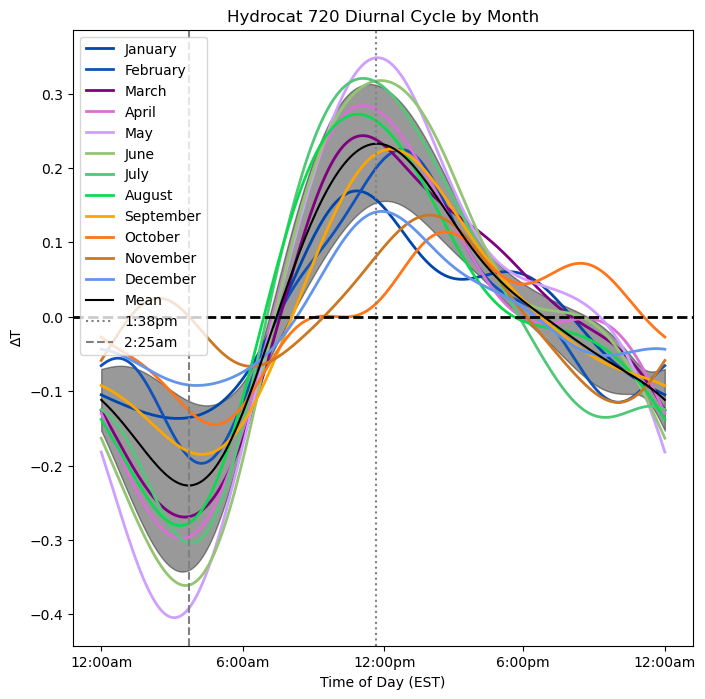

In [77]:
fig, ax = plt.subplots(figsize = [8,8])
[curve1,df1,seas1] = plot_seasonality(m_jan, 'daily', ax = ax, color = janclr)
[curve2,df2,seas2] = plot_seasonality(m_feb, 'daily', ax = ax, color = febclr)
[curve3,df3,seas3] = plot_seasonality(m_mar, 'daily', ax = ax, color = marclr)
[curve4,df4,seas4] = plot_seasonality(m_apr, 'daily', ax = ax, color = aprclr)
[curve5,df5,seas5] = plot_seasonality(m_may, 'daily', ax = ax, color = mayclr)
[curve6,df6,seas6] = plot_seasonality(m_jun, 'daily', ax = ax, color = junclr)
[curve7,df7,seas7] = plot_seasonality(m_jul, 'daily', ax = ax, color = julclr)
[curve8,df8,seas8] = plot_seasonality(m_aug, 'daily', ax = ax, color = augclr)
[curve9,df9,seas9] = plot_seasonality(m_sep, 'daily', ax = ax, color = sepclr)
[curve10,df10,seas10] = plot_seasonality(m_octo, 'daily', ax = ax, color = octclr)
[curve11,df11,seas11] = plot_seasonality(m_nov, 'daily', ax = ax, color = novclr)
[curve12,df12,seas12] = plot_seasonality(m_dec, 'daily', ax = ax, color = decclr)

meansph = np.zeros(len(df1))
stdph = np.zeros(len(df1))
for i in df1.index:
    meansph[i] = np.mean([seas1['daily'][i],seas2['daily'][i],seas3['daily'][i],seas4['daily'][i],
                          seas5['daily'][i],
                         seas6['daily'][i],seas7['daily'][i],seas8['daily'][i],seas9['daily'][i],
                         seas11['daily'][i],seas12['daily'][i]])
    stdph[i] = np.std([seas1['daily'][i],seas2['daily'][i],seas3['daily'][i],seas4['daily'][i],
                       seas5['daily'][i],
                         seas6['daily'][i],seas7['daily'][i],seas8['daily'][i],seas9['daily'][i],
                         seas11['daily'][i],seas12['daily'][i]])
ax.plot(df1['ds'],meansph,color = 'black')
ax.set_ylabel('∆T')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('Hydrocat 720 Diurnal Cycle by Month')
ax.set_xticks([df1['ds'][0],df1['ds'][50],df1['ds'][100],df1['ds'][149],df1['ds'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axvline(x = df1.iloc[np.argmax(meansph)]['ds'], ls = 'dotted', color = 'gray')
ax.axvline(x = df1.iloc[np.argmin(meansph)]['ds'], ls = 'dashed', color = 'gray')
ax.fill_between(df1['ds'], meansph + stdph, meansph - stdph, alpha = 0.4, color = 'k')
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.legend(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September',
           'October','November', 'December', 'Mean', '1:38pm','2:25am'], loc = 'upper left')

In [78]:
hydro720t = {'Time': df1['ds'],
           'Hydrocat 720 Jan': seas1['daily'],
           'Hydrocat 720 Feb': seas2['daily'],
           'Hydrocat 720 Mar': seas3['daily'],
           'Hydrocat 720 Apr': seas4['daily'],
            'Hydrocat 720 May': seas5['daily'],
           'Hydrocat 720 Jun': seas6['daily'],
           'Hydrocat 720 Jul': seas7['daily'],
           'Hydrocat 720 Aug': seas8['daily'],
           'Hydrocat 720 Sep': seas9['daily'],
           'Hydrocat 720 Oct': seas10['daily'],
           'Hydrocat 720 Nov': seas11['daily'],
           'Hydrocat 720 Dec': seas12['daily'],
           'Hydrocat 720 Mean pH': meansph,
           'Hydrocat 720 Std pH': stdph}
hydro720t = pd.DataFrame(hydro720t)
hydro720t

Time  Hydrocat 720 Jan  Hydrocat 720 Feb  \
0   2017-01-01 00:00:00.000000000         -0.104904         -0.065726   
1   2017-01-01 00:07:14.170854144         -0.106711         -0.062768   
2   2017-01-01 00:14:28.341708544         -0.108484         -0.060250   
3   2017-01-01 00:21:42.512562688         -0.110226         -0.058232   
4   2017-01-01 00:28:56.683417088         -0.111937         -0.056767   
..                            ...               ...               ...   
195 2017-01-01 23:31:03.316582912         -0.097280         -0.080606   
196 2017-01-01 23:38:17.487437312         -0.099252         -0.076579   
197 2017-01-01 23:45:31.658291456         -0.101176         -0.072707   
198 2017-01-01 23:52:45.829145856         -0.103058         -0.069068   
199 2017-01-02 00:00:00.000000000         -0.104904         -0.065726   

     Hydrocat 720 Mar  Hydrocat 720 Apr  Hydrocat 720 May  Hydrocat 720 Jun  \
0           -0.125836         -0.129720         -0.181758         -0.163251   
1           -0.132536         -0.138255         -0.193656         -0.171881   
2           -0.139332         -0.146860         -0.205706         -0.180594   
3           -0.146200         -0.155504         -0.217863         -0.189376   
4           -0.153116         -0.164156         -0.230081         -0.198210   
..                ...               ...               ...               ...   
195         -0.100401         -0.096862         -0.136432         -0.129828   
196         -0.106511         -0.104819         -0.147345         -0.137985   
197         -0.112797         -0.112963         -0.158554         -0.146280   
198         -0.119240         -0.121266         -0.170027         -0.154700   
199         -0.125836         -0.129720         -0.181758         -0.163251   

     Hydrocat 720 Jul  Hydrocat 720 Aug  Hydrocat 720 Sep  Hydrocat 720 Oct  \
0           -0.124926         -0.137881         -0.092484         -0.027209   
1           -0.127286         -0.144131         -0.094323         -0.030154   
2           -0.130159         -0.150502         -0.096281         -0.032954   
3           -0.133554         -0.156983         -0.098365         -0.035624   
4           -0.137475         -0.163557         -0.100579         -0.038183   
..                ...               ...               ...               ...   
195         -0.120237         -0.114280         -0.086147         -0.013762   
196         -0.120746         -0.119949         -0.087597         -0.017381   
197         -0.121677         -0.125775         -0.089129         -0.020826   
198         -0.123061         -0.131750         -0.090753         -0.024098   
199         -0.124926         -0.137881         -0.092484         -0.027209   

     Hydrocat 720 Nov  Hydrocat 720 Dec  Hydrocat 720 Mean pH  \
0           -0.058749         -0.043639             -0.111716   
1           -0.052746         -0.044247             -0.115322   
2           -0.046669         -0.045029             -0.119079   
3           -0.040565         -0.045984             -0.122986   
4           -0.034483         -0.047108             -0.127043   
..                ...               ...                   ...   
195         -0.081130         -0.042904             -0.098737   
196         -0.075870         -0.042844             -0.101772   
197         -0.070362         -0.042942             -0.104942   
198         -0.064645         -0.043204             -0.108252   
199         -0.058749         -0.043639             -0.111716   

     Hydrocat 720 Std pH  
0               0.041468  
1               0.046098  
2               0.050812  
3               0.055561  
4               0.060306  
..                   ...  
195             0.025252  
196             0.028756  
197             0.032706  
198             0.036972  
199             0.041468  

[200 rows x 15 columns]

In [74]:
hydro720o2 = {'Time': df1['ds'],
           'Hydrocat 720 Jan': seas1['daily'],
           'Hydrocat 720 Feb': seas2['daily'],
           'Hydrocat 720 Mar': seas3['daily'],
           'Hydrocat 720 Apr': seas4['daily'],
            'Hydrocat 720 May': seas5['daily'],
           'Hydrocat 720 Jun': seas6['daily'],
           'Hydrocat 720 Jul': seas7['daily'],
           'Hydrocat 720 Aug': seas8['daily'],
           'Hydrocat 720 Sep': seas9['daily'],
           'Hydrocat 720 Oct': seas10['daily'],
           'Hydrocat 720 Nov': seas11['daily'],
           'Hydrocat 720 Dec': seas12['daily'],
           'Hydrocat 720 Mean pH': meansph,
           'Hydrocat 720 Std pH': stdph}
hydro720o2 = pd.DataFrame(hydro720o2)
hydro720o2

Time  Hydrocat 720 Jan  Hydrocat 720 Feb  \
0   2017-01-01 00:00:00.000000000         -0.152798         -0.077769   
1   2017-01-01 00:07:14.170854144         -0.153860         -0.084758   
2   2017-01-01 00:14:28.341708544         -0.154744         -0.091810   
3   2017-01-01 00:21:42.512562688         -0.155476         -0.098888   
4   2017-01-01 00:28:56.683417088         -0.156081         -0.105957   
..                            ...               ...               ...   
195 2017-01-01 23:31:03.316582912         -0.146340         -0.051058   
196 2017-01-01 23:38:17.487437312         -0.148324         -0.057483   
197 2017-01-01 23:45:31.658291456         -0.150049         -0.064092   
198 2017-01-01 23:52:45.829145856         -0.151533         -0.070859   
199 2017-01-02 00:00:00.000000000         -0.152798         -0.077769   

     Hydrocat 720 Mar  Hydrocat 720 Apr  Hydrocat 720 May  Hydrocat 720 Jun  \
0           -0.028402         -0.060766         -0.176917         -0.374652   
1           -0.031103         -0.062584         -0.182404         -0.377576   
2           -0.034212         -0.064296         -0.187470         -0.379476   
3           -0.037705         -0.065883         -0.192092         -0.380366   
4           -0.041554         -0.067332         -0.196254         -0.380272   
..                ...               ...               ...               ...   
195         -0.022022         -0.052827         -0.151252         -0.352685   
196         -0.022931         -0.054867         -0.158162         -0.359691   
197         -0.024302         -0.056884         -0.164761         -0.365698   
198         -0.026127         -0.058857         -0.171018         -0.370686   
199         -0.028402         -0.060766         -0.176917         -0.374652   

     Hydrocat 720 Jul  Hydrocat 720 Aug  Hydrocat 720 Sep  Hydrocat 720 Oct  \
0           -0.477664         -0.452208         -0.223600          0.053045   
1           -0.482776         -0.464006         -0.229372          0.052746   
2           -0.488153         -0.475237         -0.234763          0.051182   
3           -0.493812         -0.485852         -0.239768          0.048399   
4           -0.499766         -0.495808         -0.244390          0.044457   
..                ...               ...               ...               ...   
195         -0.459327         -0.400427         -0.196897          0.041246   
196         -0.463653         -0.413929         -0.204075          0.046132   
197         -0.468127         -0.427097         -0.210929          0.049739   
198         -0.472783         -0.439867         -0.217438          0.052045   
199         -0.477664         -0.452208         -0.223600          0.053045   

     Hydrocat 720 Nov  Hydrocat 720 Dec  Hydrocat 720 Mean pH  \
0           -0.023783         -0.014918             -0.187589   
1           -0.027983         -0.016960             -0.192126   
2           -0.032277         -0.019015             -0.196496   
3           -0.036653         -0.021075             -0.200688   
4           -0.041096         -0.023134             -0.204695   
..                ...               ...                   ...   
195         -0.008094         -0.007010             -0.167994   
196         -0.011832         -0.008931             -0.173080   
197         -0.015695         -0.010893             -0.178048   
198         -0.019678         -0.012890             -0.182885   
199         -0.023783         -0.014918             -0.187589   

     Hydrocat 720 Std pH  
0               0.165670  
1               0.167223  
2               0.168623  
3               0.169876  
4               0.170990  
..                   ...  
195             0.157920  
196             0.160082  
197             0.162097  
198             0.163959  
199             0.165670  

[200 rows x 15 columns]

In [44]:
hydro720 = {'Time': df1['ds'],
           'Hydrocat 720 Jan': seas1['daily'],
           'Hydrocat 720 Feb': seas2['daily'],
           'Hydrocat 720 Mar': seas3['daily'],
           'Hydrocat 720 Apr': seas4['daily'],
            'Hydrocat 720 May': seas5['daily'],
           'Hydrocat 720 Jun': seas6['daily'],
           'Hydrocat 720 Jul': seas7['daily'],
           'Hydrocat 720 Aug': seas8['daily'],
           'Hydrocat 720 Sep': seas9['daily'],
           'Hydrocat 720 Oct': seas10['daily'],
           'Hydrocat 720 Nov': seas11['daily'],
           'Hydrocat 720 Dec': seas12['daily'],
           'Hydrocat 720 Mean pH': meansph,
           'Hydrocat 720 Std pH': stdph}
hydro720 = pd.DataFrame(hydro720)
hydro720

Time  Hydrocat 720 Jan  Hydrocat 720 Feb  \
0   2017-01-01 00:00:00.000000000      2.409599e-10      6.192640e-11   
1   2017-01-01 00:07:14.170854144      2.459551e-10      7.363569e-11   
2   2017-01-01 00:14:28.341708544      2.506381e-10      8.546147e-11   
3   2017-01-01 00:21:42.512562688      2.550213e-10      9.734057e-11   
4   2017-01-01 00:28:56.683417088      2.591186e-10      1.092093e-10   
..                            ...               ...               ...   
195 2017-01-01 23:31:03.316582912      2.176538e-10      1.743260e-11   
196 2017-01-01 23:38:17.487437312      2.239869e-10      2.808035e-11   
197 2017-01-01 23:45:31.658291456      2.299772e-10      3.907707e-11   
198 2017-01-01 23:52:45.829145856      2.356287e-10      5.036917e-11   
199 2017-01-02 00:00:00.000000000      2.409599e-10      6.192640e-11   

     Hydrocat 720 Mar  Hydrocat 720 Apr  Hydrocat 720 May  Hydrocat 720 Jun  \
0       -5.619683e-11      2.755503e-11      2.946309e-10      1.817464e-09   
1       -5.073757e-11      3.284464e-11      3.041662e-10      1.830118e-09   
2       -4.478221e-11      3.789833e-11      3.126565e-10      1.836195e-09   
3       -3.838640e-11      4.266559e-11      3.200456e-10      1.835855e-09   
4       -3.160957e-11      4.710216e-11      3.262874e-10      1.829315e-09   
..                ...               ...               ...               ...   
195     -7.213492e-11      5.216208e-12      2.474433e-10      1.699976e-09   
196     -6.911980e-11      1.084285e-11      2.604235e-10      1.739298e-09   
197     -6.543656e-11      1.648455e-11      2.726688e-10      1.772031e-09   
198     -6.111943e-11      2.207287e-11      2.840908e-10      1.798084e-09   
199     -5.619683e-11      2.755503e-11      2.946309e-10      1.817464e-09   

     Hydrocat 720 Jul  Hydrocat 720 Aug  Hydrocat 720 Sep  Hydrocat 720 Oct  \
0        1.383240e-09      2.017901e-09      8.827872e-10     -2.947102e-10   
1        1.383867e-09      2.088726e-09      9.135907e-10     -3.013694e-10   
2        1.386214e-09      2.155722e-09      9.424930e-10     -3.022824e-10   
3        1.390498e-09      2.218575e-09      9.693745e-10     -2.974952e-10   
4        1.396909e-09      2.277008e-09      9.941382e-10     -2.871255e-10   
..                ...               ...               ...               ...   
195      1.392831e-09      1.703523e-09      7.436057e-10     -2.121514e-10   
196      1.389179e-09      1.785895e-09      7.804029e-10     -2.408226e-10   
197      1.386169e-09      1.866004e-09      8.159829e-10     -2.642842e-10   
198      1.384096e-09      1.943419e-09      8.501471e-10     -2.822963e-10   
199      1.383240e-09      2.017901e-09      8.827872e-10     -2.947102e-10   

     Hydrocat 720 Nov  Hydrocat 720 Dec  Hydrocat 720 Mean pH  \
0        6.049424e-11     -2.954884e-11          6.092011e-10   
1        6.469549e-11     -2.603696e-11          6.237113e-10   
2        6.889469e-11     -2.200812e-11          6.372166e-10   
3        7.310437e-11     -1.748631e-11          6.496916e-10   
4        7.733625e-11     -1.250072e-11          6.611194e-10   
..                ...               ...                   ...   
195      4.340516e-11     -3.814151e-11          5.418918e-10   
196      4.774028e-11     -3.682849e-11          5.599909e-10   
197      5.202426e-11     -3.495791e-11          5.772750e-10   
198      5.626829e-11     -3.253141e-11          5.936841e-10   
199      6.049424e-11     -2.954884e-11          6.092011e-10   

     Hydrocat 720 Std pH  
0           7.472697e-10  
1           7.597619e-10  
2           7.709903e-10  
3           7.809321e-10  
4           7.895823e-10  
..                   ...  
195         6.857110e-10  
196         7.026732e-10  
197         7.186411e-10  
198         7.335220e-10  
199         7.472697e-10  

[200 rows x 15 columns]

# QP by month

In [45]:
QP['Month'] = np.zeros(len(QP['DateTime']))
QP['H'] = np.zeros(len(QP['DateTime']))
for i in QP.index:
    QP['Month'][i] = QP['DateTime'][i].month
    QP['H'][i] = np.power(10, -QP['pH final'][i])
QP['Month'].unique()

array([5., 6., 7., 8., 9.])

In [82]:
MAY = QP.where(QP['Month'] == 5).dropna()
JUN = QP.where(QP['Month'] == 6).dropna()
JUL = QP.where(QP['Month'] == 7).dropna()
AUG = QP.where(QP['Month'] == 8).dropna()
SEP = QP.where(QP['Month'] == 9).dropna()

var = 'Temperature [degC]'
# Create our data frames for ds and y
may = MAY[['DateTime', var]]
jun = JUN[['DateTime', var]]
jul = JUL[['DateTime', var]]
aug = AUG[['DateTime', var]]
sep = SEP[['DateTime', var]]

# Rename DateTime as ds and pH total as y
may = may.rename(columns = {'DateTime': 'ds', var: 'y'})
jun = jun.rename(columns = {'DateTime': 'ds', var: 'y'})
jul = jul.rename(columns = {'DateTime': 'ds', var: 'y'})
aug = aug.rename(columns = {'DateTime': 'ds', var: 'y'})
sep = sep.rename(columns = {'DateTime': 'ds', var: 'y'})

# Instatiate Prophet object
m_may = Prophet()
m_jun = Prophet()
m_jul = Prophet()
m_aug = Prophet()
m_sep = Prophet()

# Fit Prophet object
m_may.fit(may)
m_jun.fit(jun)
m_jul.fit(jul)
m_aug.fit(aug)
m_sep.fit(sep)

# Make history dataframes for each dataset
future_may = m_may.make_future_dataframe(periods=0)
future_jun = m_jun.make_future_dataframe(periods=0)
future_jul = m_jul.make_future_dataframe(periods=0)
future_aug = m_aug.make_future_dataframe(periods=0)
future_sep = m_sep.make_future_dataframe(periods=0)

forecast_may = m_may.predict(future_may)
forecast_jun = m_jun.predict(future_jun)
forecast_jul = m_jul.predict(future_jul)
forecast_aug = m_aug.predict(future_aug)
forecast_sep = m_sep.predict(future_sep)

17:50:59 - cmdstanpy - INFO - Chain [1] start processing
17:50:59 - cmdstanpy - INFO - Chain [1] done processing
17:51:00 - cmdstanpy - INFO - Chain [1] start processing
17:51:01 - cmdstanpy - INFO - Chain [1] done processing
17:51:01 - cmdstanpy - INFO - Chain [1] start processing
17:51:03 - cmdstanpy - INFO - Chain [1] done processing
17:51:03 - cmdstanpy - INFO - Chain [1] start processing
17:51:04 - cmdstanpy - INFO - Chain [1] done processing
17:51:04 - cmdstanpy - INFO - Chain [1] start processing
17:51:05 - cmdstanpy - INFO - Chain [1] done processing


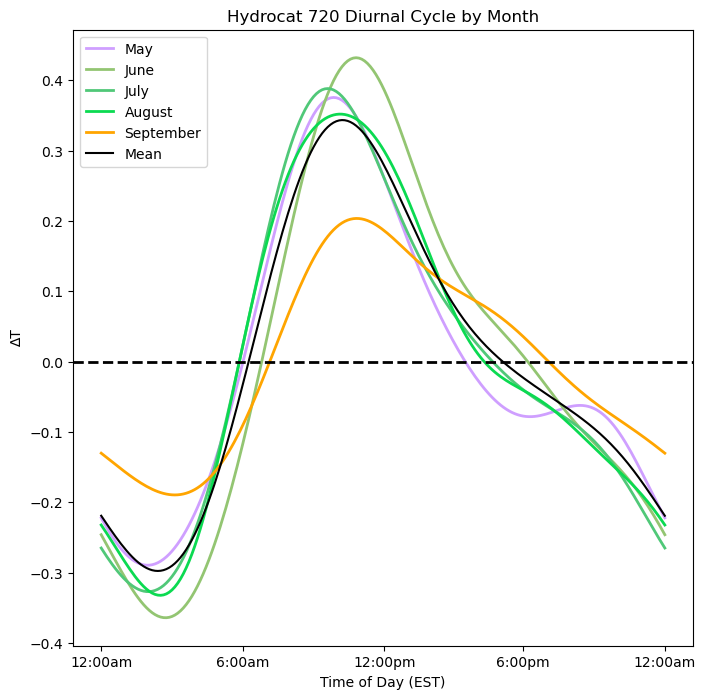

In [83]:
fig, ax = plt.subplots(figsize = [8,8])
# [curve1,df1,seas1] = plot_seasonality(m_jan, 'daily', ax = ax, color = janclr)
# [curve2,df2,seas2] = plot_seasonality(m_feb, 'daily', ax = ax, color = febclr)
# [curve3,df3,seas3] = plot_seasonality(m_mar, 'daily', ax = ax, color = marclr)
# [curve4,df4,seas4] = plot_seasonality(m_apr, 'daily', ax = ax, color = aprclr)
[curve5,df5,seas5] = plot_seasonality(m_may, 'daily', ax = ax, color = mayclr)
[curve6,df6,seas6] = plot_seasonality(m_jun, 'daily', ax = ax, color = junclr)
[curve7,df7,seas7] = plot_seasonality(m_jul, 'daily', ax = ax, color = julclr)
[curve8,df8,seas8] = plot_seasonality(m_aug, 'daily', ax = ax, color = augclr)
[curve9,df9,seas9] = plot_seasonality(m_sep, 'daily', ax = ax, color = sepclr)
# [curve10,df10,seas10] = plot_seasonality(m_octo, 'daily', ax = ax, color = octclr)
# [curve11,df11,seas11] = plot_seasonality(m_nov, 'daily', ax = ax, color = novclr)
# [curve12,df12,seas12] = plot_seasonality(m_dec, 'daily', ax = ax, color = decclr)

meansph = np.zeros(len(df1))
stdph = np.zeros(len(df1))
for i in df1.index:
    meansph[i] = np.mean([seas6['daily'][i],seas7['daily'][i],seas8['daily'][i],seas9['daily'][i],
                         seas5['daily'][i]])
    stdph[i] = np.std([seas6['daily'][i],seas7['daily'][i],seas8['daily'][i],seas9['daily'][i],
                         seas5['daily'][i]])
ax.plot(df1['ds'],meansph,color = 'black')
ax.set_ylabel('∆T')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('Hydrocat 720 Diurnal Cycle by Month')
ax.set_xticks([df1['ds'][0],df1['ds'][50],df1['ds'][100],df1['ds'][149],df1['ds'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
# ax.axvline(x = df1.iloc[np.argmax(meansph)]['ds'], ls = 'dotted', color = 'gray')
# ax.axvline(x = df1.iloc[np.argmin(meansph)]['ds'], ls = 'dashed', color = 'gray')
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.legend(['May', 'June', 'July', 'August', 'September',
            'Mean'], loc = 'upper left')

# fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/diurnalcycle_ph.png', bbox_inches='tight')



# ax2 = ax.twinx()
# plot_seasonality(M, 'daily', ax = ax2, color = 'orange')
# ax2.set_ylabel('∆ Tide Height [m]')

In [84]:
qpt = {'Time': df1['ds'],
           'QP 620 May': seas5['daily'],
           'QP 620 Jun': seas6['daily'],
           'QP 620 Jul': seas7['daily'],
           'QP 620 Aug': seas8['daily'],
           'QP 620 Sep': seas9['daily'],
           'QP 620 Mean pH': meansph,
           'QP 620 Std pH': stdph}
qpt = pd.DataFrame(qpt)
qpt

Time  QP 620 May  QP 620 Jun  QP 620 Jul  \
0   2017-01-01 00:00:00.000000000   -0.222198   -0.246168   -0.265085   
1   2017-01-01 00:07:14.170854144   -0.229470   -0.253445   -0.271374   
2   2017-01-01 00:14:28.341708544   -0.236463   -0.260791   -0.277462   
3   2017-01-01 00:21:42.512562688   -0.243139   -0.268173   -0.283321   
4   2017-01-01 00:28:56.683417088   -0.249465   -0.275557   -0.288923   
..                            ...         ...         ...         ...   
195 2017-01-01 23:31:03.316582912   -0.191082   -0.218261   -0.238443   
196 2017-01-01 23:38:17.487437312   -0.199074   -0.225006   -0.245265   
197 2017-01-01 23:45:31.658291456   -0.206950   -0.231916   -0.251995   
198 2017-01-01 23:52:45.829145856   -0.214666   -0.238972   -0.258606   
199 2017-01-02 00:00:00.000000000   -0.222198   -0.246168   -0.265085   

     QP 620 Aug  QP 620 Sep  QP 620 Mean pH  QP 620 Std pH  
0     -0.232359   -0.130256       -0.219213       0.046746  
1     -0.238391   -0.133443       -0.225225       0.048044  
2     -0.244548   -0.136643       -0.231181       0.049321  
3     -0.250808   -0.139848       -0.237058       0.050565  
4     -0.257141   -0.143050       -0.242827       0.051770  
..          ...         ...             ...            ...  
195   -0.209776   -0.117737       -0.195060       0.041549  
196   -0.215164   -0.120820       -0.201066       0.042823  
197   -0.220726   -0.123935       -0.207104       0.044121  
198   -0.226456   -0.127079       -0.213156       0.045432  
199   -0.232359   -0.130256       -0.219213       0.046746  

[200 rows x 8 columns]

In [81]:
qpo2 = {'Time': df1['ds'],
           'QP 620 May': seas5['daily'],
           'QP 620 Jun': seas6['daily'],
           'QP 620 Jul': seas7['daily'],
           'QP 620 Aug': seas8['daily'],
           'QP 620 Sep': seas9['daily'],
           'QP 620 Mean pH': meansph,
           'QP 620 Std pH': stdph}
qpo2 = pd.DataFrame(qpo2)
qpo2

Time  QP 620 May  QP 620 Jun  QP 620 Jul  \
0   2017-01-01 00:00:00.000000000   -0.076028   -0.145163   -0.274940   
1   2017-01-01 00:07:14.170854144   -0.074360   -0.146788   -0.275837   
2   2017-01-01 00:14:28.341708544   -0.072565   -0.148164   -0.276323   
3   2017-01-01 00:21:42.512562688   -0.070672   -0.149290   -0.276414   
4   2017-01-01 00:28:56.683417088   -0.068707   -0.150170   -0.276125   
..                            ...         ...         ...         ...   
195 2017-01-01 23:31:03.316582912   -0.080998   -0.136221   -0.267046   
196 2017-01-01 23:38:17.487437312   -0.080050   -0.138811   -0.269675   
197 2017-01-01 23:45:31.658291456   -0.078895   -0.141169   -0.271865   
198 2017-01-01 23:52:45.829145856   -0.077549   -0.143286   -0.273617   
199 2017-01-02 00:00:00.000000000   -0.076028   -0.145163   -0.274940   

     QP 620 Aug  QP 620 Sep  QP 620 Mean pH  QP 620 Std pH  
0     -0.288486   -0.311219       -0.219167       0.092038  
1     -0.294433   -0.312474       -0.220778       0.093571  
2     -0.300625   -0.313655       -0.222266       0.095200  
3     -0.307019   -0.314778       -0.223635       0.096923  
4     -0.313565   -0.315858       -0.224885       0.098731  
..          ...         ...             ...            ...  
195   -0.267790   -0.304962       -0.211403       0.086818  
196   -0.272449   -0.306768       -0.213551       0.087996  
197   -0.277461   -0.308391       -0.215556       0.089254  
198   -0.282810   -0.309865       -0.217426       0.090598  
199   -0.288486   -0.311219       -0.219167       0.092038  

[200 rows x 8 columns]

In [48]:
qp = {'Time': df1['ds'],
           'QP 620 May': seas5['daily'],
           'QP 620 Jun': seas6['daily'],
           'QP 620 Jul': seas7['daily'],
           'QP 620 Aug': seas8['daily'],
           'QP 620 Sep': seas9['daily'],
           'QP 620 Mean pH': meansph,
           'QP 620 Std pH': stdph}
qp = pd.DataFrame(qp)
qp

Time    QP 620 May    QP 620 Jun    QP 620 Jul  \
0   2017-01-01 00:00:00.000000000  1.289467e-10  4.033944e-10  7.409700e-10   
1   2017-01-01 00:07:14.170854144  1.132038e-10  4.045219e-10  7.403213e-10   
2   2017-01-01 00:14:28.341708544  9.722176e-11  4.042329e-10  7.387420e-10   
3   2017-01-01 00:21:42.512562688  8.116701e-11  4.025746e-10  7.362509e-10   
4   2017-01-01 00:28:56.683417088  6.521128e-11  3.996086e-10  7.328686e-10   
..                            ...           ...           ...           ...   
195 2017-01-01 23:31:03.316582912  1.865264e-10  3.842900e-10  7.339239e-10   
196 2017-01-01 23:38:17.487437312  1.732303e-10  3.912529e-10  7.371583e-10   
197 2017-01-01 23:45:31.658291456  1.591216e-10  3.967647e-10  7.394025e-10   
198 2017-01-01 23:52:45.829145856  1.443262e-10  4.008102e-10  7.406685e-10   
199 2017-01-02 00:00:00.000000000  1.289467e-10  4.033944e-10  7.409700e-10   

       QP 620 Aug    QP 620 Sep  QP 620 Mean pH  QP 620 Std pH  
0    8.273387e-10  9.356403e-10    6.072580e-10   2.981582e-10  
1    8.377136e-10  9.308243e-10    6.053170e-10   3.035403e-10  
2    8.492993e-10  9.267185e-10    6.032429e-10   3.095812e-10  
3    8.619359e-10  9.234990e-10    6.010855e-10   3.162230e-10  
4    8.754393e-10  9.213093e-10    5.988874e-10   3.233914e-10  
..            ...           ...             ...            ...  
195  8.001853e-10  9.575478e-10    6.124947e-10   2.837467e-10  
196  8.046613e-10  9.521828e-10    6.116971e-10   2.862709e-10  
197  8.107115e-10  9.465682e-10    6.105137e-10   2.895056e-10  
198  8.182888e-10  9.409737e-10    6.090135e-10   2.934654e-10  
199  8.273387e-10  9.356403e-10    6.072580e-10   2.981582e-10  

[200 rows x 8 columns]

In [49]:
MV['Month'] = np.zeros(len(MV['DateTime']))
MV['H'] = np.zeros(len(MV['DateTime']))
for i in MV.index:
    MV['Month'][i] = MV['DateTime'][i].month
    MV['H'][i] = np.power(10, -MV['pH final'][i])
MV['Month'].unique()

array([ 5.,  6.,  7.,  8.,  9., 10., 11.])

In [388]:
MV.keys()

Index(['DateTime', 'Temperature [degC]', 'Salinity [PSU]', 'DO [mg/L]',
       'raw pH [total]', 'pH final', 'pH (normalized to 15°C)', 'Month'],
      dtype='object')

In [88]:
MAY = MV.where(MV['Month'] == 5).dropna()
JUN = MV.where(MV['Month'] == 6).dropna()
JUL = MV.where(MV['Month'] == 7).dropna()
AUG = MV.where(MV['Month'] == 8).dropna()
SEP = MV.where(MV['Month'] == 9).dropna()
OCT = MV.where(MV['Month'] == 10).dropna()
NOV = MV.where(MV['Month'] == 11).dropna()

var = 'Temperature [degC]'
# Create our data frames for ds and y
may = MAY[['DateTime', var]]
jun = JUN[['DateTime', var]]
jul = JUL[['DateTime', var]]
aug = AUG[['DateTime', var]]
sep = SEP[['DateTime', var]]
octo = OCT[['DateTime', var]]
nov = NOV[['DateTime', var]]

# Rename DateTime as ds and pH total as y
may = may.rename(columns = {'DateTime': 'ds', var: 'y'})
jun = jun.rename(columns = {'DateTime': 'ds', var: 'y'})
jul = jul.rename(columns = {'DateTime': 'ds', var: 'y'})
aug = aug.rename(columns = {'DateTime': 'ds', var: 'y'})
sep = sep.rename(columns = {'DateTime': 'ds', var: 'y'})
octo = octo.rename(columns = {'DateTime': 'ds', var: 'y'})
nov = nov.rename(columns = {'DateTime': 'ds', var: 'y'})

# Instatiate Prophet object
m_may = Prophet()
m_jun = Prophet()
m_jul = Prophet()
m_aug = Prophet()
m_sep = Prophet()
m_octo = Prophet()
m_nov = Prophet()

# Fit Prophet object
m_may.fit(may)
m_jun.fit(jun)
m_jul.fit(jul)
m_aug.fit(aug)
m_sep.fit(sep)
m_octo.fit(octo)
m_nov.fit(nov)

# Make history dataframes for each dataset
future_may = m_may.make_future_dataframe(periods=0)
future_jun = m_jun.make_future_dataframe(periods=0)
future_jul = m_jul.make_future_dataframe(periods=0)
future_aug = m_aug.make_future_dataframe(periods=0)
future_sep = m_sep.make_future_dataframe(periods=0)
future_octo = m_octo.make_future_dataframe(periods=0)
future_nov = m_nov.make_future_dataframe(periods=0)

forecast_may = m_may.predict(future_may)
forecast_jun = m_jun.predict(future_jun)
forecast_jul = m_jul.predict(future_jul)
forecast_aug = m_aug.predict(future_aug)
forecast_sep = m_sep.predict(future_sep)
forecast_octo = m_sep.predict(future_octo)
forecast_nov = m_sep.predict(future_nov)

17:51:46 - cmdstanpy - INFO - Chain [1] start processing
17:51:46 - cmdstanpy - INFO - Chain [1] done processing
17:51:46 - cmdstanpy - INFO - Chain [1] start processing
17:51:48 - cmdstanpy - INFO - Chain [1] done processing
17:51:48 - cmdstanpy - INFO - Chain [1] start processing
17:51:49 - cmdstanpy - INFO - Chain [1] done processing
17:51:49 - cmdstanpy - INFO - Chain [1] start processing
17:51:49 - cmdstanpy - INFO - Chain [1] done processing
17:51:49 - cmdstanpy - INFO - Chain [1] start processing
17:51:50 - cmdstanpy - INFO - Chain [1] done processing
17:51:50 - cmdstanpy - INFO - Chain [1] start processing
17:51:52 - cmdstanpy - INFO - Chain [1] done processing
17:51:52 - cmdstanpy - INFO - Chain [1] start processing
17:51:52 - cmdstanpy - INFO - Chain [1] done processing


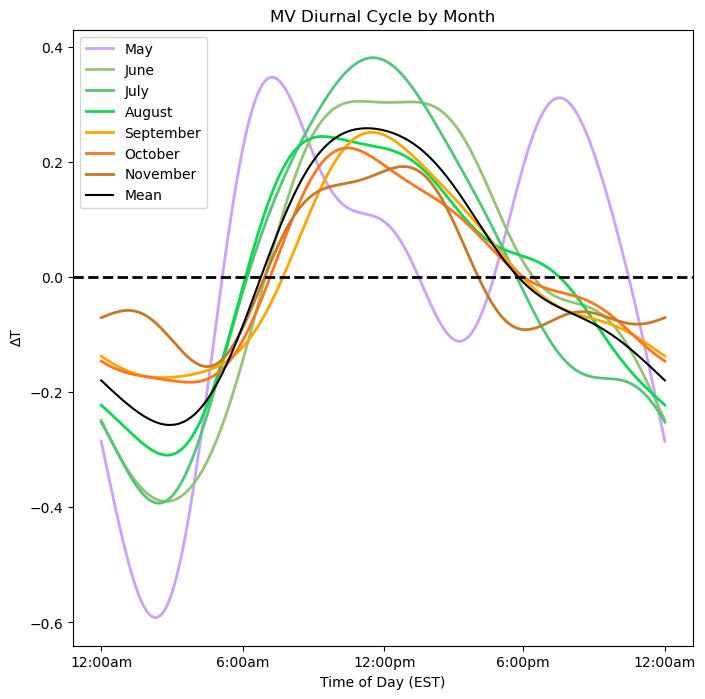

In [89]:
fig, ax = plt.subplots(figsize = [8,8])
# [curve1,df1,seas1] = plot_seasonality(m_jan, 'daily', ax = ax, color = janclr)
# [curve2,df2,seas2] = plot_seasonality(m_feb, 'daily', ax = ax, color = febclr)
# [curve3,df3,seas3] = plot_seasonality(m_mar, 'daily', ax = ax, color = marclr)
# [curve4,df4,seas4] = plot_seasonality(m_apr, 'daily', ax = ax, color = aprclr)
[curve5,df5,seas5] = plot_seasonality(m_may, 'daily', ax = ax, color = mayclr)
[curve6,df6,seas6] = plot_seasonality(m_jun, 'daily', ax = ax, color = junclr)
[curve7,df7,seas7] = plot_seasonality(m_jul, 'daily', ax = ax, color = julclr)
[curve8,df8,seas8] = plot_seasonality(m_aug, 'daily', ax = ax, color = augclr)
[curve9,df9,seas9] = plot_seasonality(m_sep, 'daily', ax = ax, color = sepclr)
[curve10,df10,seas10] = plot_seasonality(m_octo, 'daily', ax = ax, color = octclr)
[curve11,df11,seas11] = plot_seasonality(m_nov, 'daily', ax = ax, color = novclr)
# [curve12,df12,seas12] = plot_seasonality(m_dec, 'daily', ax = ax, color = decclr)

meansph = np.zeros(len(df1))
stdph = np.zeros(len(df1))
for i in df1.index:
    meansph[i] = np.mean([seas6['daily'][i],seas7['daily'][i],seas8['daily'][i],seas9['daily'][i],
                         seas10['daily'][i],seas11['daily'][i]])
    stdph[i] = np.std([seas6['daily'][i],seas7['daily'][i],seas8['daily'][i],seas9['daily'][i],
                         seas10['daily'][i],seas11['daily'][i]])
ax.plot(df1['ds'],meansph,color = 'black')
ax.set_ylabel('∆T')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('MV Diurnal Cycle by Month')
ax.set_xticks([df1['ds'][0],df1['ds'][50],df1['ds'][100],df1['ds'][149],df1['ds'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
# ax.axvline(x = df1.iloc[np.argmax(meansph)]['ds'], ls = 'dotted', color = 'gray')
# ax.axvline(x = df1.iloc[np.argmin(meansph)]['ds'], ls = 'dashed', color = 'gray')
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.legend(['May', 'June', 'July', 'August', 'September', 'October', 'November',
            'Mean'], loc = 'upper left')

# fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/diurnalcycle_ph.png', bbox_inches='tight')



# ax2 = ax.twinx()
# plot_seasonality(M, 'daily', ax = ax2, color = 'orange')
# ax2.set_ylabel('∆ Tide Height [m]')

In [90]:
mvt = {'Time': df1['ds'],
           'MV 620 May': seas5['daily'],
           'MV 620 Jun': seas6['daily'],
           'MV 620 Jul': seas7['daily'],
           'MV 620 Aug': seas8['daily'],
           'MV 620 Sep': seas9['daily'],
           'MV 620 Oct': seas10['daily'],
           'MV 620 Nov': seas11['daily'],
           'MV 620 Mean pH': meansph,
           'MV 620 Std pH': stdph}
mvt = pd.DataFrame(mvt)
mvt

Time  MV 620 May  MV 620 Jun  MV 620 Jul  \
0   2017-01-01 00:00:00.000000000   -0.284912   -0.248374   -0.251900   
1   2017-01-01 00:07:14.170854144   -0.308470   -0.258735   -0.260590   
2   2017-01-01 00:14:28.341708544   -0.331924   -0.268932   -0.269579   
3   2017-01-01 00:21:42.512562688   -0.355176   -0.278923   -0.278799   
4   2017-01-01 00:28:56.683417088   -0.378117   -0.288668   -0.288179   
..                            ...         ...         ...         ...   
195 2017-01-01 23:31:03.316582912   -0.191166   -0.206182   -0.221180   
196 2017-01-01 23:38:17.487437312   -0.214374   -0.216739   -0.228156   
197 2017-01-01 23:45:31.658291456   -0.237765   -0.227318   -0.235624   
198 2017-01-01 23:52:45.829145856   -0.261282   -0.237871   -0.243547   
199 2017-01-02 00:00:00.000000000   -0.284912   -0.248374   -0.251900   

     MV 620 Aug  MV 620 Sep  MV 620 Oct  MV 620 Nov  MV 620 Mean pH  \
0     -0.222274   -0.137237   -0.145863   -0.070305       -0.179326   
1     -0.226741   -0.140522   -0.148898   -0.068366       -0.183975   
2     -0.231228   -0.143721   -0.151719   -0.066446       -0.188604   
3     -0.235745   -0.146817   -0.154327   -0.064595       -0.193201   
4     -0.240298   -0.149793   -0.156723   -0.062865       -0.197754   
..          ...         ...         ...         ...             ...   
195   -0.204291   -0.123619   -0.131676   -0.077304       -0.160709   
196   -0.208835   -0.127053   -0.135509   -0.075755       -0.165341   
197   -0.213332   -0.130479   -0.139157   -0.074047       -0.169993   
198   -0.217803   -0.133878   -0.142609   -0.072217       -0.174654   
199   -0.222274   -0.137237   -0.145863   -0.070305       -0.179326   

     MV 620 Std pH  
0         0.066653  
1         0.070441  
2         0.074301  
3         0.078196  
4         0.082088  
..             ...  
195       0.052913  
196       0.056067  
197       0.059428  
198       0.062965  
199       0.066653  

[200 rows x 10 columns]

In [87]:
mvo2 = {'Time': df1['ds'],
           'MV 620 May': seas5['daily'],
           'MV 620 Jun': seas6['daily'],
           'MV 620 Jul': seas7['daily'],
           'MV 620 Aug': seas8['daily'],
           'MV 620 Sep': seas9['daily'],
           'MV 620 Oct': seas10['daily'],
           'MV 620 Nov': seas11['daily'],
           'MV 620 Mean pH': meansph,
           'MV 620 Std pH': stdph}
mvo2 = pd.DataFrame(mvo2)
mvo2

Time  MV 620 May  MV 620 Jun  MV 620 Jul  \
0   2017-01-01 00:00:00.000000000   -0.158932   -0.315613   -0.496234   
1   2017-01-01 00:07:14.170854144   -0.159287   -0.320574   -0.505148   
2   2017-01-01 00:14:28.341708544   -0.159309   -0.325083   -0.513559   
3   2017-01-01 00:21:42.512562688   -0.158979   -0.329125   -0.521429   
4   2017-01-01 00:28:56.683417088   -0.158283   -0.332689   -0.528721   
..                            ...         ...         ...         ...   
195 2017-01-01 23:31:03.316582912   -0.154710   -0.291630   -0.456371   
196 2017-01-01 23:38:17.487437312   -0.156121   -0.298195   -0.466870   
197 2017-01-01 23:45:31.658291456   -0.157317   -0.304395   -0.477040   
198 2017-01-01 23:52:45.829145856   -0.158265   -0.310205   -0.486836   
199 2017-01-02 00:00:00.000000000   -0.158932   -0.315613   -0.496234   

     MV 620 Aug  MV 620 Sep  MV 620 Oct  MV 620 Nov  MV 620 Mean pH  \
0     -0.456657   -0.300898   -0.143595   -0.089347       -0.300391   
1     -0.459479   -0.305675   -0.146765   -0.095163       -0.305467   
2     -0.461858   -0.310161   -0.149770   -0.100960       -0.310232   
3     -0.463820   -0.314366   -0.152606   -0.106696       -0.314674   
4     -0.465390   -0.318299   -0.155272   -0.112330       -0.318784   
..          ...         ...         ...         ...             ...   
195   -0.440416   -0.278636   -0.129309   -0.066593       -0.277159   
196   -0.445265   -0.284692   -0.133110   -0.072131       -0.283377   
197   -0.449572   -0.290411   -0.136760   -0.077789       -0.289328   
198   -0.453358   -0.295806   -0.140253   -0.083534       -0.294999   
199   -0.456657   -0.300898   -0.143595   -0.089347       -0.300391   

     MV 620 Std pH  
0         0.148397  
1         0.149016  
2         0.149497  
3         0.149846  
4         0.150067  
..             ...  
195       0.144441  
196       0.145661  
197       0.146724  
198       0.147634  
199       0.148397  

[200 rows x 10 columns]

In [52]:
mv = {'Time': df1['ds'],
           'MV 620 May': seas5['daily'],
           'MV 620 Jun': seas6['daily'],
           'MV 620 Jul': seas7['daily'],
           'MV 620 Aug': seas8['daily'],
           'MV 620 Sep': seas9['daily'],
           'MV 620 Oct': seas10['daily'],
           'MV 620 Nov': seas11['daily'],
           'MV 620 Mean pH': meansph,
           'MV 620 Std pH': stdph}
mv = pd.DataFrame(mv)
mv

Time    MV 620 May    MV 620 Jun    MV 620 Jul  \
0   2017-01-01 00:00:00.000000000  4.340964e-10  1.205848e-09  1.950093e-09   
1   2017-01-01 00:07:14.170854144  4.526819e-10  1.228009e-09  1.991581e-09   
2   2017-01-01 00:14:28.341708544  4.702127e-10  1.248365e-09  2.030208e-09   
3   2017-01-01 00:21:42.512562688  4.865197e-10  1.266914e-09  2.065817e-09   
4   2017-01-01 00:28:56.683417088  5.014530e-10  1.283667e-09  2.098275e-09   
..                            ...           ...           ...           ...   
195 2017-01-01 23:31:03.316582912  3.530215e-10  1.099573e-09  1.759265e-09   
196 2017-01-01 23:38:17.487437312  3.738720e-10  1.128682e-09  1.810229e-09   
197 2017-01-01 23:45:31.658291456  3.944668e-10  1.156121e-09  1.859157e-09   
198 2017-01-01 23:52:45.829145856  4.145956e-10  1.181840e-09  1.905818e-09   
199 2017-01-02 00:00:00.000000000  4.340964e-10  1.205848e-09  1.950093e-09   

       MV 620 Aug    MV 620 Sep    MV 620 Oct    MV 620 Nov  MV 620 Mean pH  \
0    1.974261e-09  1.320898e-09  2.815131e-10  1.205769e-10    1.142198e-09   
1    1.993021e-09  1.341785e-09  2.886230e-10  1.284134e-10    1.161905e-09   
2    2.009948e-09  1.359760e-09  2.948915e-10  1.361727e-10    1.179891e-09   
3    2.025183e-09  1.374842e-09  3.002954e-10  1.437873e-10    1.196140e-09   
4    2.038859e-09  1.387068e-09  3.048174e-10  1.511901e-10    1.210646e-09   
..            ...           ...           ...           ...             ...   
195  1.877866e-09  1.208472e-09  2.453067e-10  8.975455e-11    1.046706e-09   
196  1.905442e-09  1.240805e-09  2.554338e-10  9.724885e-11    1.072973e-09   
197  1.930596e-09  1.270349e-09  2.648710e-10  1.049212e-10    1.097669e-09   
198  1.953471e-09  1.297043e-09  2.735719e-10  1.127122e-10    1.120743e-09   
199  1.974261e-09  1.320898e-09  2.815131e-10  1.205769e-10    1.142198e-09   

     MV 620 Std pH  
0     7.263490e-10  
1     7.355915e-10  
2     7.440483e-10  
3     7.517289e-10  
4     7.586448e-10  
..             ...  
195   6.813623e-10  
196   6.938096e-10  
197   7.054511e-10  
198   7.162888e-10  
199   7.263490e-10  

[200 rows x 10 columns]

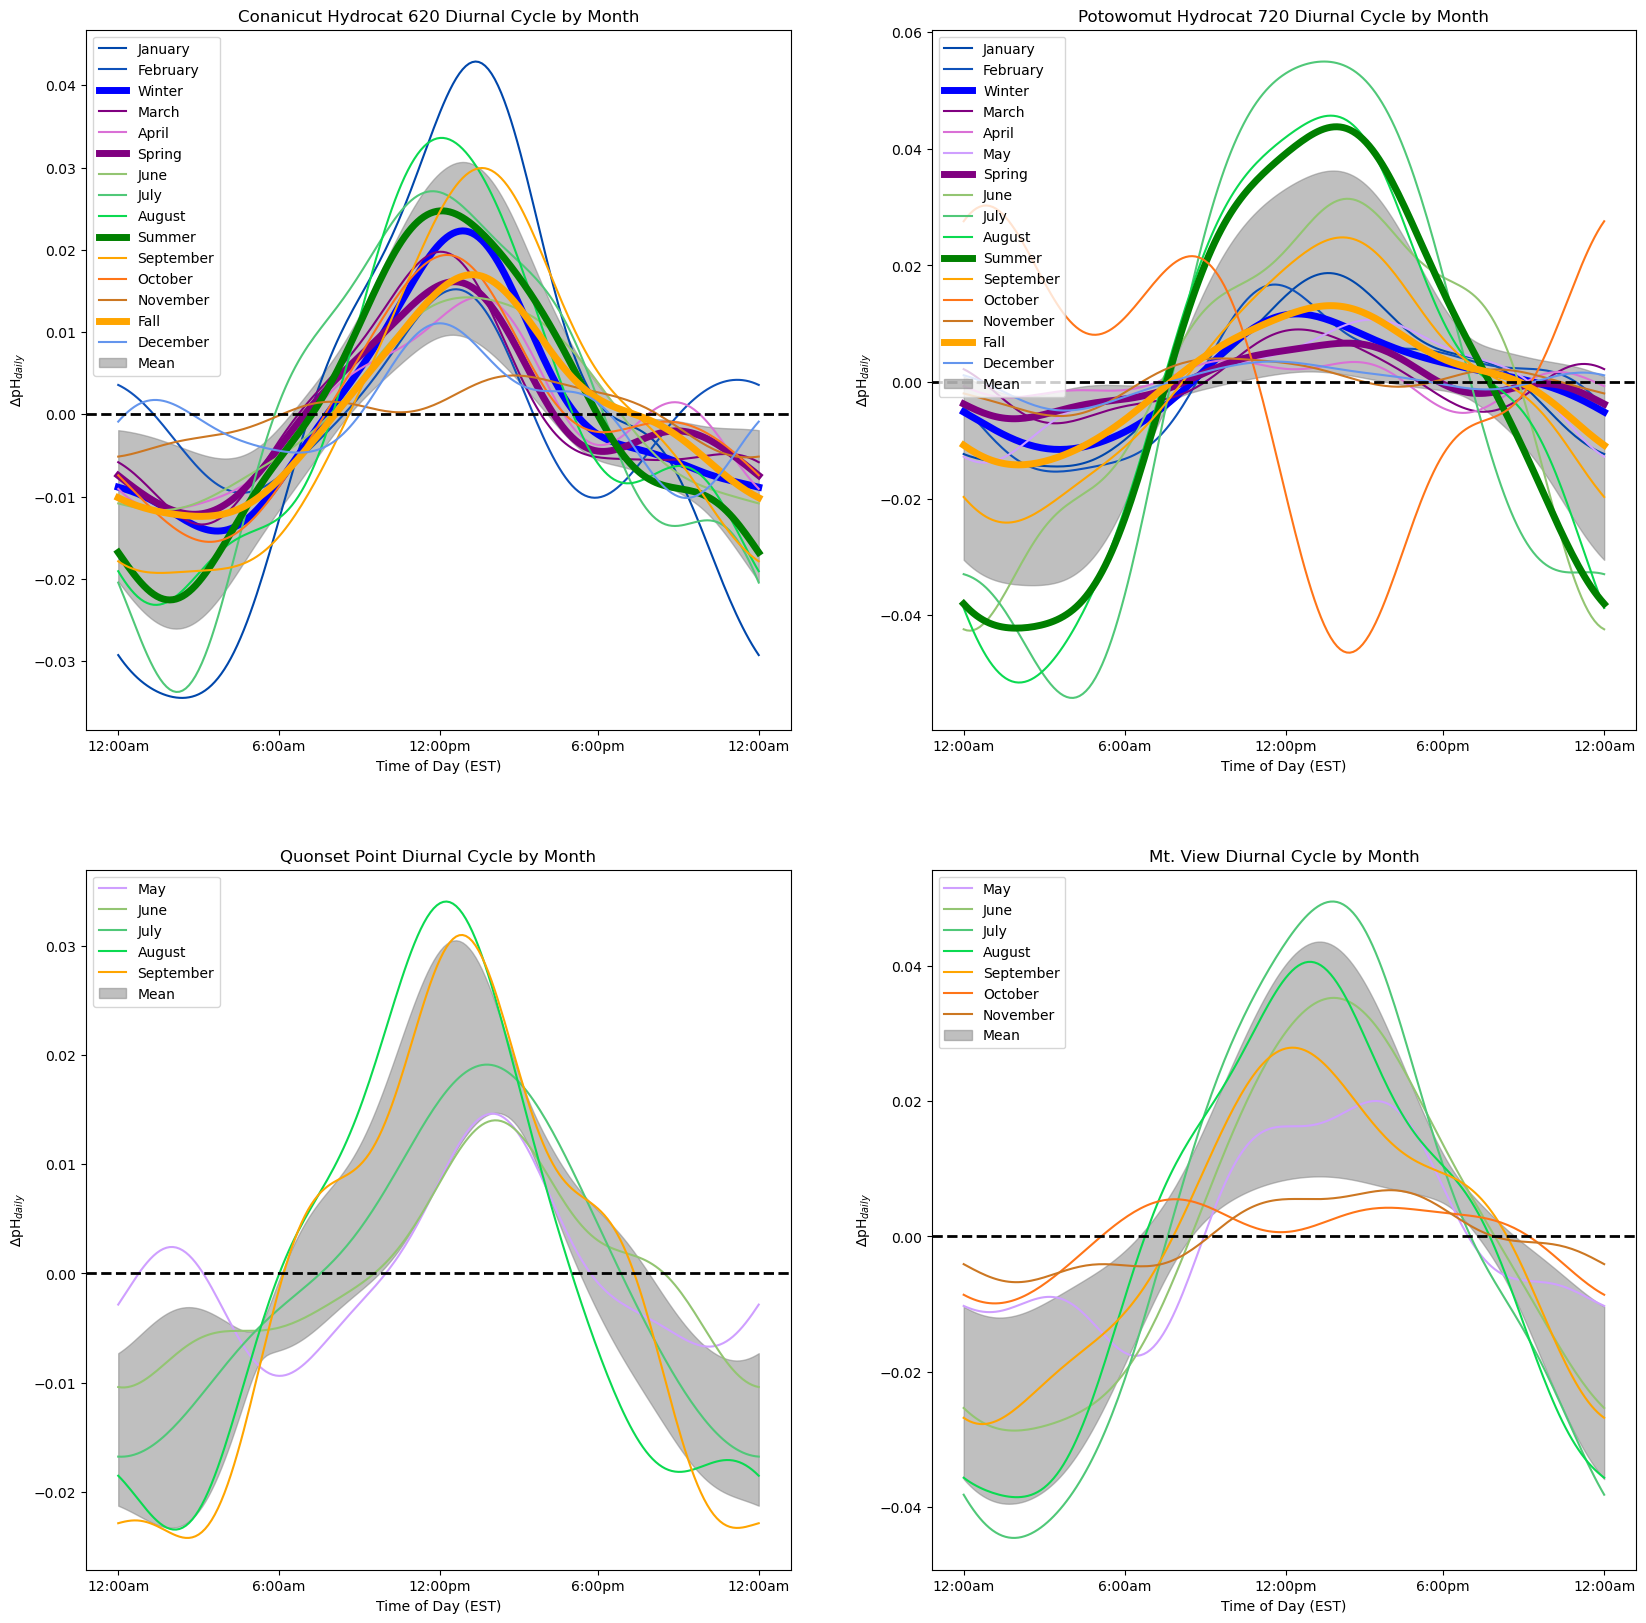

In [395]:
fig, axarr = plt.subplots(nrows = 2, ncols = 2, figsize = [20,20])
axarr = axarr.flatten()

ax = axarr[0]
df = hydro620
ax.plot(df['Time'], df['Hydrocat 620 Jan'], color = janclr, label = 'January')
ax.plot(df['Time'], df['Hydrocat 620 Feb'], color = febclr, label = 'February')
winter = (df['Hydrocat 620 Jan'] + df['Hydrocat 620 Feb'] + df['Hydrocat 620 Dec'])/3
ax.plot(df['Time'], winter, color = 'blue', lw = 5, label = 'Winter')
ax.plot(df['Time'], df['Hydrocat 620 Mar'], color = marclr, label = 'March')
ax.plot(df['Time'], df['Hydrocat 620 Apr'], color = aprclr, label = 'April')
spring = (df['Hydrocat 620 Mar'] + df['Hydrocat 620 Apr'])/2
ax.plot(df['Time'], spring, color = 'purple', lw = 5, label = 'Spring')
ax.plot(df['Time'], df['Hydrocat 620 Jun'], color = junclr, label = 'June')
ax.plot(df['Time'], df['Hydrocat 620 Jul'], color = julclr, label = 'July')
ax.plot(df['Time'], df['Hydrocat 620 Aug'], color = augclr, label = 'August')
summer = (df['Hydrocat 620 Jun'] + df['Hydrocat 620 Jul'] + df['Hydrocat 620 Aug'])/3
ax.plot(df['Time'], summer, color = 'green', lw = 5, label = 'Summer')
ax.plot(df['Time'], df['Hydrocat 620 Sep'], color = sepclr, label = 'September')
ax.plot(df['Time'], df['Hydrocat 620 Oct'], color = octclr, label = 'October')
ax.plot(df['Time'], df['Hydrocat 620 Nov'], color = novclr, label = 'November')
fall = (df['Hydrocat 620 Nov'] + df['Hydrocat 620 Sep'] + df['Hydrocat 620 Oct'])/3
ax.plot(df['Time'], fall, color = 'orange', lw = 5, label = 'Fall')
ax.plot(df['Time'], df['Hydrocat 620 Dec'], color = decclr, label = 'December')
ax.fill_between(df['Time'], df['Hydrocat 620 Mean pH'] - df['Hydrocat 620 Std pH'], df['Hydrocat 620 Mean pH'] + df['Hydrocat 620 Std pH'],
                color = 'gray', alpha = 0.5, label = 'Mean')
ax.set_ylabel('∆pH$_{daily}$')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('Conanicut Hydrocat 620 Diurnal Cycle by Month')
ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.legend(loc = 'upper left')

ax = axarr[1]
df = hydro720
ax.plot(df['Time'], df['Hydrocat 720 Jan'], color = janclr, label = 'January')
ax.plot(df['Time'], df['Hydrocat 720 Feb'], color = febclr, label = 'February')
winter = (df['Hydrocat 720 Jan'] + df['Hydrocat 720 Feb'] + df['Hydrocat 720 Dec'])/3
ax.plot(df['Time'], winter, color = 'blue', lw = 5, label = 'Winter')
ax.plot(df['Time'], df['Hydrocat 720 Mar'], color = marclr, label = 'March')
ax.plot(df['Time'], df['Hydrocat 720 Apr'], color = aprclr, label = 'April')
ax.plot(df['Time'], df['Hydrocat 720 May'], color = mayclr, label = 'May')
spring = (df['Hydrocat 720 Mar'] + df['Hydrocat 720 Apr'] + df['Hydrocat 720 May'])/3
ax.plot(df['Time'], spring, color = 'purple', lw = 5, label = 'Spring')
ax.plot(df['Time'], df['Hydrocat 720 Jun'], color = junclr, label = 'June')
ax.plot(df['Time'], df['Hydrocat 720 Jul'], color = julclr, label = 'July')
ax.plot(df['Time'], df['Hydrocat 720 Aug'], color = augclr, label = 'August')
summer = (df['Hydrocat 720 Jun'] + df['Hydrocat 720 Jul'] + df['Hydrocat 720 Aug'])/3
ax.plot(df['Time'], summer, color = 'green', lw = 5, label = 'Summer')
ax.plot(df['Time'], df['Hydrocat 720 Sep'], color = sepclr, label = 'September')
ax.plot(df['Time'], df['Hydrocat 720 Oct'], color = octclr, label = 'October')
ax.plot(df['Time'], df['Hydrocat 720 Nov'], color = novclr, label = 'November')
fall = (df['Hydrocat 720 Nov'] + df['Hydrocat 720 Sep'])/2
ax.plot(df['Time'], fall, color = 'orange', lw = 5, label = 'Fall')
ax.plot(df['Time'], df['Hydrocat 720 Dec'], color = decclr, label = 'December')
ax.fill_between(df['Time'], df['Hydrocat 720 Mean pH'] - df['Hydrocat 720 Std pH'], df['Hydrocat 720 Mean pH'] + df['Hydrocat 720 Std pH'],
                color = 'gray', alpha = 0.5, label = 'Mean')
ax.set_ylabel('∆pH$_{daily}$')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('Potowomut Hydrocat 720 Diurnal Cycle by Month')
ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.legend(loc = 'upper left')

ax = axarr[2]
df = qp
ax.plot(df['Time'], df['QP 620 May'], color = mayclr, label = 'May')
ax.plot(df['Time'], df['QP 620 Jun'], color = junclr, label = 'June')
ax.plot(df['Time'], df['QP 620 Jul'], color = julclr, label = 'July')
ax.plot(df['Time'], df['QP 620 Aug'], color = augclr, label = 'August')
ax.plot(df['Time'], df['QP 620 Sep'], color = sepclr, label = 'September')
ax.fill_between(df['Time'], df['QP 620 Mean pH'] + df['QP 620 Std pH'], df['QP 620 Mean pH'] - df['QP 620 Std pH'],
                color = 'gray', alpha = 0.5, label = 'Mean')
ax.set_ylabel('∆pH$_{daily}$')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('Quonset Point Diurnal Cycle by Month')
ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.legend(loc = 'upper left')

ax = axarr[3]
df = mv
ax.plot(df['Time'], df['MV 620 May'], color = mayclr, label = 'May')
ax.plot(df['Time'], df['MV 620 Jun'], color = junclr, label = 'June')
ax.plot(df['Time'], df['MV 620 Jul'], color = julclr, label = 'July')
ax.plot(df['Time'], df['MV 620 Aug'], color = augclr, label = 'August')
ax.plot(df['Time'], df['MV 620 Sep'], color = sepclr, label = 'September')
ax.plot(df['Time'], df['MV 620 Oct'], color = octclr, label = 'October')
ax.plot(df['Time'], df['MV 620 Nov'], color = novclr, label = 'November')
ax.fill_between(df['Time'], df['MV 620 Mean pH'] - df['MV 620 Std pH'], df['MV 620 Mean pH'] + df['MV 620 Std pH'],
                color = 'gray', alpha = 0.5, label = 'Mean')
ax.set_ylabel('∆pH$_{daily}$')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('Mt. View Diurnal Cycle by Month')
ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.legend(loc = 'upper left')

fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/seasonaldiurnalcycle_ph_sensor.png', bbox_inches='tight')

In [53]:
STD = np.sqrt(qp['QP 620 Std pH']**2 + mv['MV 620 Std pH']**2 + hydro620['Hydrocat 620 Std pH']**2 + hydro720['Hydrocat 720 Std pH']**2)
MN = (mv['MV 620 Mean pH'] + qp['QP 620 Mean pH'] + hydro620['Hydrocat 620 Mean pH'] + hydro720['Hydrocat 720 Mean pH'])/4

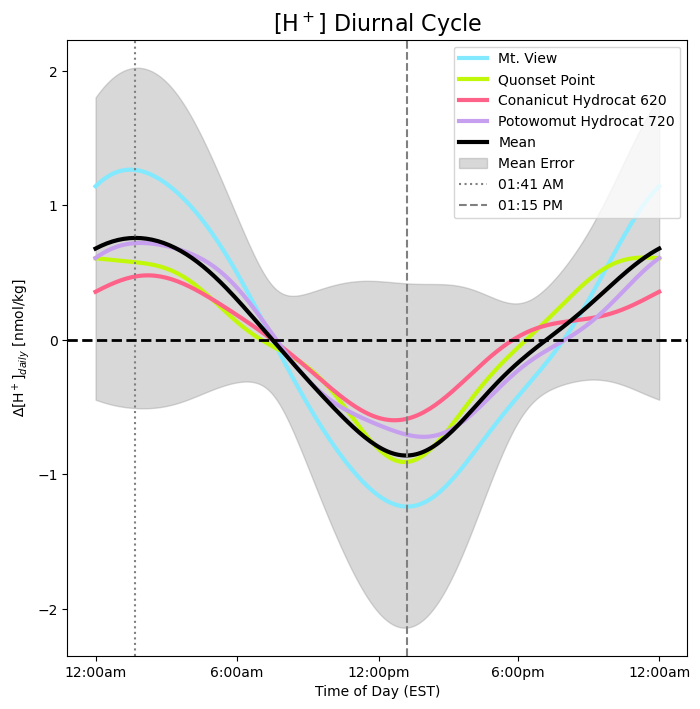

In [96]:
fig,ax = plt.subplots(figsize = [8,8])
pink = '#ff6289'
purple = '#C79FEF'
blue = '#82e9ff'
green = '#C1F80A'
LW = 3

df = mv
ax.plot(df['Time'], mv['MV 620 Mean pH']/1e-9, color = blue, lw = LW,
        label = 'Mt. View')
ax.plot(df['Time'], qp['QP 620 Mean pH']/1e-9, color = green, lw = LW,
        label = 'Quonset Point')
ax.plot(df['Time'], hydro620['Hydrocat 620 Mean pH']/1e-9, color = pink, lw = LW,
        label = 'Conanicut Hydrocat 620')
ax.plot(df['Time'], hydro720['Hydrocat 720 Mean pH']/1e-9, color = purple, lw = LW,
        label = 'Potowomut Hydrocat 720')
ax.plot(df['Time'], MN/1e-9, color = 'black', lw = LW,
        label = 'Mean')
ax.fill_between(df['Time'], (MN - STD)/1e-9, (MN + STD)/1e-9, color = 'gray', alpha = 0.3, label = 'Mean Error')
ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axvline(x = df['Time'].iloc[np.argmax(MN)], ls = 'dotted', color = 'gray',
          label = datetime.strftime(df['Time'].iloc[np.argmax(MN)], "%I:%M %p"))
ax.axvline(x = df['Time'].iloc[np.argmin(MN)], ls = 'dashed', color = 'gray',
          label = datetime.strftime(df['Time'].iloc[np.argmin(MN)], "%I:%M %p"))
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.set_ylabel('∆[H$^+$]$_{daily}$ [nmol/kg]')
ax.set_title('[H$^+$] Diurnal Cycle', fontsize = 16)
ax.set_xlabel('Time of Day (EST)')
ax.legend(loc = 'upper right')

# fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/diurnalcycle_ph_error.png', bbox_inches='tight')

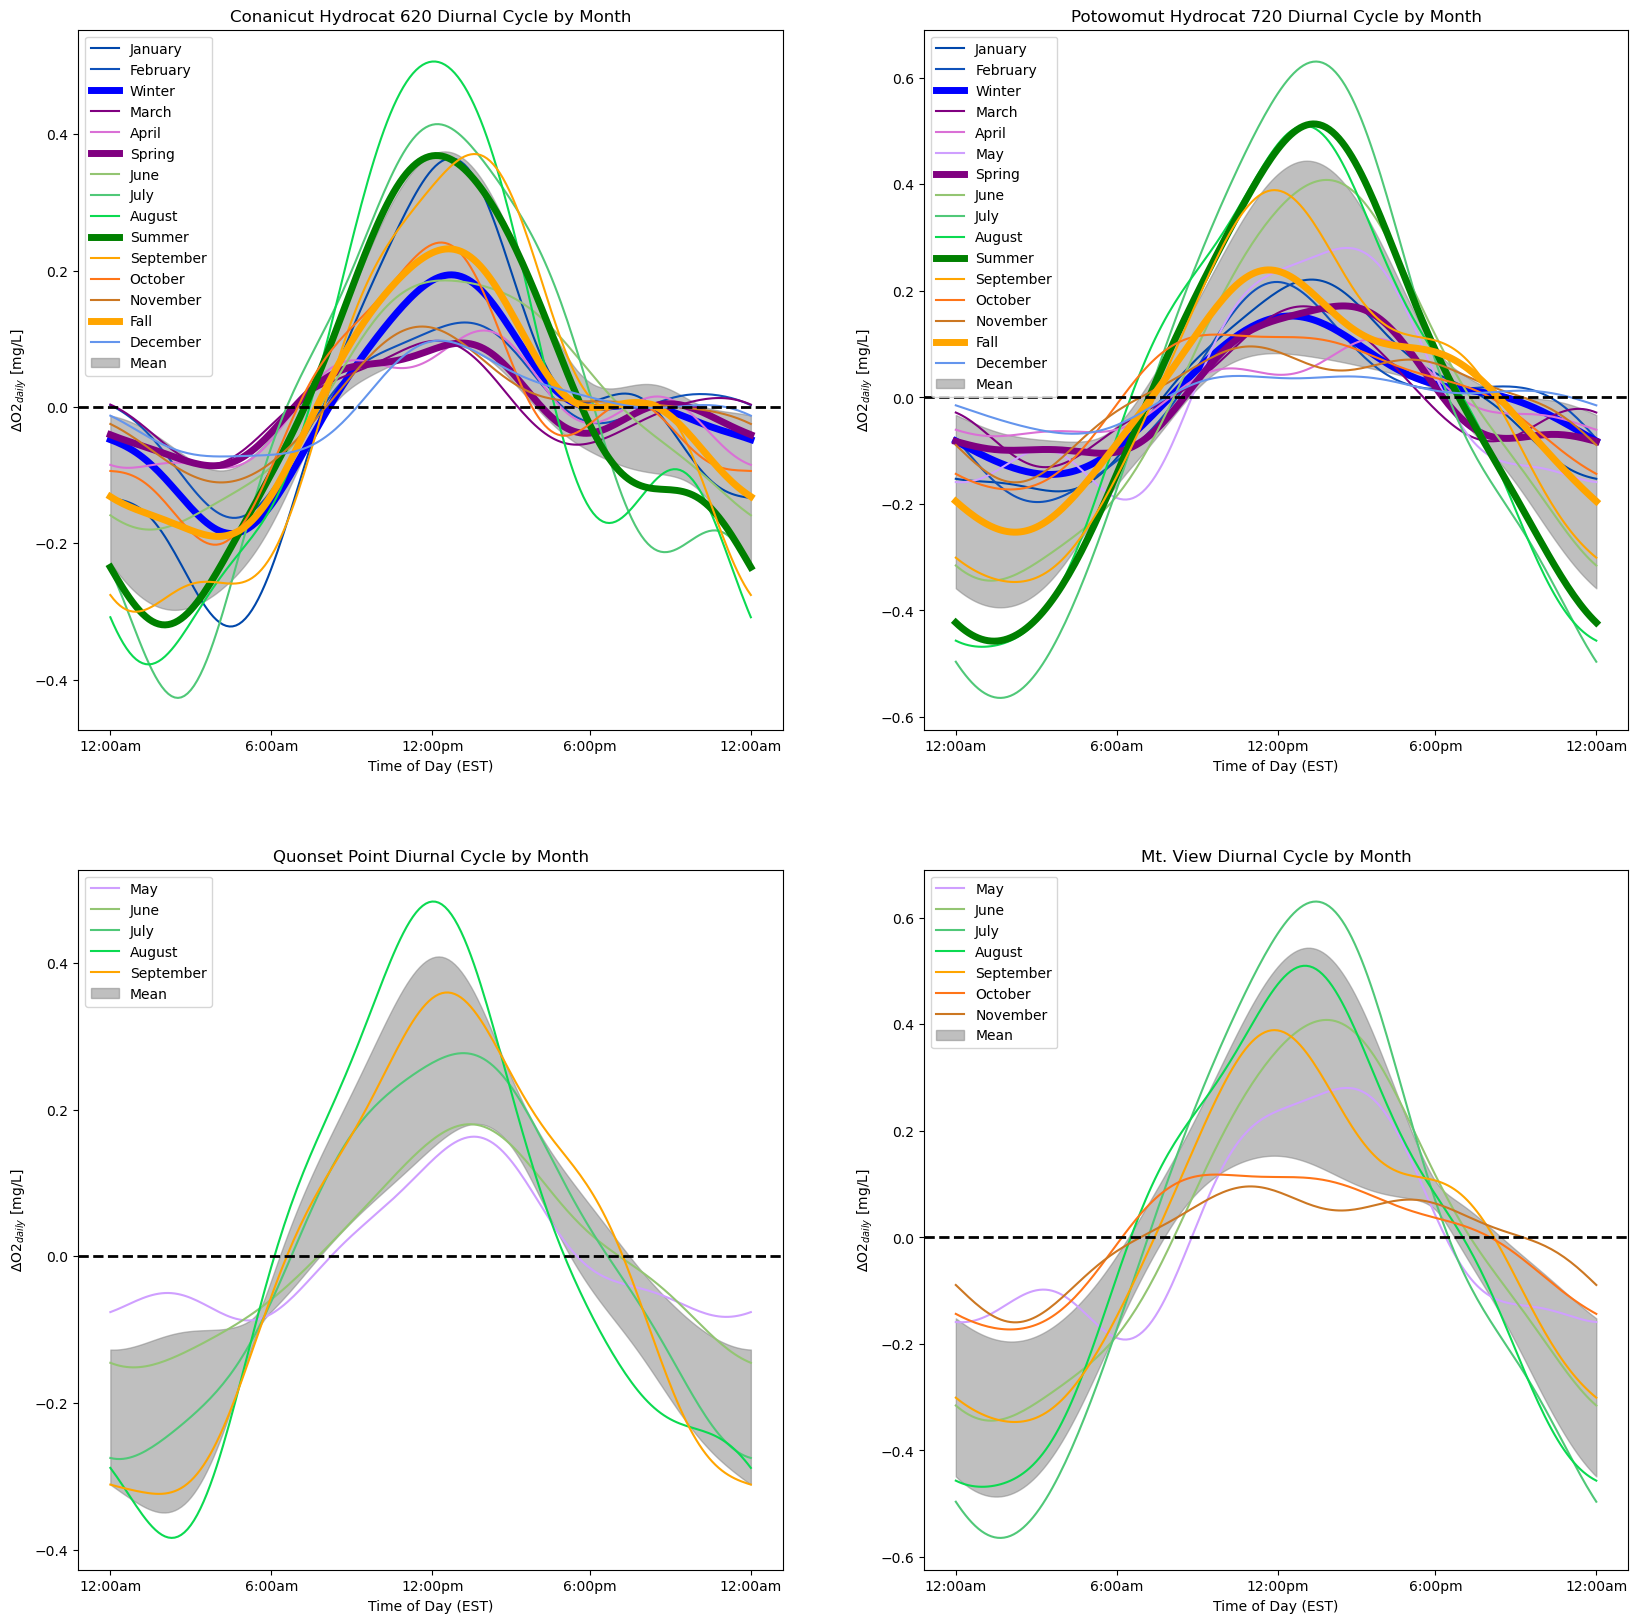

In [398]:
fig, axarr = plt.subplots(nrows = 2, ncols = 2, figsize = [20,20])
axarr = axarr.flatten()

ax = axarr[0]
df = hydro620o2
ax.plot(df['Time'], df['Hydrocat 620 Jan'], color = janclr, label = 'January')
ax.plot(df['Time'], df['Hydrocat 620 Feb'], color = febclr, label = 'February')
winter = (df['Hydrocat 620 Jan'] + df['Hydrocat 620 Feb'] + df['Hydrocat 620 Dec'])/3
ax.plot(df['Time'], winter, color = 'blue', lw = 5, label = 'Winter')
ax.plot(df['Time'], df['Hydrocat 620 Mar'], color = marclr, label = 'March')
ax.plot(df['Time'], df['Hydrocat 620 Apr'], color = aprclr, label = 'April')
spring = (df['Hydrocat 620 Mar'] + df['Hydrocat 620 Apr'])/2
ax.plot(df['Time'], spring, color = 'purple', lw = 5, label = 'Spring')
ax.plot(df['Time'], df['Hydrocat 620 Jun'], color = junclr, label = 'June')
ax.plot(df['Time'], df['Hydrocat 620 Jul'], color = julclr, label = 'July')
ax.plot(df['Time'], df['Hydrocat 620 Aug'], color = augclr, label = 'August')
summer = (df['Hydrocat 620 Jun'] + df['Hydrocat 620 Jul'] + df['Hydrocat 620 Aug'])/3
ax.plot(df['Time'], summer, color = 'green', lw = 5, label = 'Summer')
ax.plot(df['Time'], df['Hydrocat 620 Sep'], color = sepclr, label = 'September')
ax.plot(df['Time'], df['Hydrocat 620 Oct'], color = octclr, label = 'October')
ax.plot(df['Time'], df['Hydrocat 620 Nov'], color = novclr, label = 'November')
fall = (df['Hydrocat 620 Nov'] + df['Hydrocat 620 Sep'] + df['Hydrocat 620 Oct'])/3
ax.plot(df['Time'], fall, color = 'orange', lw = 5, label = 'Fall')
ax.plot(df['Time'], df['Hydrocat 620 Dec'], color = decclr, label = 'December')
ax.fill_between(df['Time'], df['Hydrocat 620 Mean pH'] - df['Hydrocat 620 Std pH'], df['Hydrocat 620 Mean pH'] + df['Hydrocat 620 Std pH'],
                color = 'gray', alpha = 0.5, label = 'Mean')
ax.set_ylabel('∆O2$_{daily}$ [mg/L]')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('Conanicut Hydrocat 620 Diurnal Cycle by Month')
ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.legend(loc = 'upper left')

ax = axarr[1]
df = hydro720o2
ax.plot(df['Time'], df['Hydrocat 720 Jan'], color = janclr, label = 'January')
ax.plot(df['Time'], df['Hydrocat 720 Feb'], color = febclr, label = 'February')
winter = (df['Hydrocat 720 Jan'] + df['Hydrocat 720 Feb'] + df['Hydrocat 720 Dec'])/3
ax.plot(df['Time'], winter, color = 'blue', lw = 5, label = 'Winter')
ax.plot(df['Time'], df['Hydrocat 720 Mar'], color = marclr, label = 'March')
ax.plot(df['Time'], df['Hydrocat 720 Apr'], color = aprclr, label = 'April')
ax.plot(df['Time'], df['Hydrocat 720 May'], color = mayclr, label = 'May')
spring = (df['Hydrocat 720 Mar'] + df['Hydrocat 720 Apr'] + df['Hydrocat 720 May'])/3
ax.plot(df['Time'], spring, color = 'purple', lw = 5, label = 'Spring')
ax.plot(df['Time'], df['Hydrocat 720 Jun'], color = junclr, label = 'June')
ax.plot(df['Time'], df['Hydrocat 720 Jul'], color = julclr, label = 'July')
ax.plot(df['Time'], df['Hydrocat 720 Aug'], color = augclr, label = 'August')
summer = (df['Hydrocat 720 Jun'] + df['Hydrocat 720 Jul'] + df['Hydrocat 720 Aug'])/3
ax.plot(df['Time'], summer, color = 'green', lw = 5, label = 'Summer')
ax.plot(df['Time'], df['Hydrocat 720 Sep'], color = sepclr, label = 'September')
ax.plot(df['Time'], df['Hydrocat 720 Oct'], color = octclr, label = 'October')
ax.plot(df['Time'], df['Hydrocat 720 Nov'], color = novclr, label = 'November')
fall = (df['Hydrocat 720 Nov'] + df['Hydrocat 720 Sep'])/2
ax.plot(df['Time'], fall, color = 'orange', lw = 5, label = 'Fall')
ax.plot(df['Time'], df['Hydrocat 720 Dec'], color = decclr, label = 'December')
ax.fill_between(df['Time'], df['Hydrocat 720 Mean pH'] - df['Hydrocat 720 Std pH'], df['Hydrocat 720 Mean pH'] + df['Hydrocat 720 Std pH'],
                color = 'gray', alpha = 0.5, label = 'Mean')
ax.set_ylabel('∆O2$_{daily}$ [mg/L]')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('Potowomut Hydrocat 720 Diurnal Cycle by Month')
ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.legend(loc = 'upper left')

ax = axarr[2]
df = qpo2
ax.plot(df['Time'], df['QP 620 May'], color = mayclr, label = 'May')
ax.plot(df['Time'], df['QP 620 Jun'], color = junclr, label = 'June')
ax.plot(df['Time'], df['QP 620 Jul'], color = julclr, label = 'July')
ax.plot(df['Time'], df['QP 620 Aug'], color = augclr, label = 'August')
ax.plot(df['Time'], df['QP 620 Sep'], color = sepclr, label = 'September')
ax.fill_between(df['Time'], df['QP 620 Mean pH'] + df['QP 620 Std pH'], df['QP 620 Mean pH'] - df['QP 620 Std pH'],
                color = 'gray', alpha = 0.5, label = 'Mean')
ax.set_ylabel('∆O2$_{daily}$ [mg/L]')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('Quonset Point Diurnal Cycle by Month')
ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.legend(loc = 'upper left')

ax = axarr[3]
df = mvo2
ax.plot(df['Time'], df['MV 620 May'], color = mayclr, label = 'May')
ax.plot(df['Time'], df['MV 620 Jun'], color = junclr, label = 'June')
ax.plot(df['Time'], df['MV 620 Jul'], color = julclr, label = 'July')
ax.plot(df['Time'], df['MV 620 Aug'], color = augclr, label = 'August')
ax.plot(df['Time'], df['MV 620 Sep'], color = sepclr, label = 'September')
ax.plot(df['Time'], df['MV 620 Oct'], color = octclr, label = 'October')
ax.plot(df['Time'], df['MV 620 Nov'], color = novclr, label = 'November')
ax.fill_between(df['Time'], df['MV 620 Mean pH'] - df['MV 620 Std pH'], df['MV 620 Mean pH'] + df['MV 620 Std pH'],
                color = 'gray', alpha = 0.5, label = 'Mean')
ax.set_ylabel('∆O2$_{daily}$ [mg/L]')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('Mt. View Diurnal Cycle by Month')
ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.legend(loc = 'upper left')

fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/seasonaldiurnalcycle_o2_sensor.png', bbox_inches='tight')

In [399]:
STDo2 = np.sqrt(qpo2['QP 620 Std pH']**2 + mvo2['MV 620 Std pH']**2 + hydro620o2['Hydrocat 620 Std pH']**2 + hydro720o2['Hydrocat 720 Std pH']**2)
MNo2 = (mvo2['MV 620 Mean pH'] + qpo2['QP 620 Mean pH'] + hydro620o2['Hydrocat 620 Mean pH'] + hydro720o2['Hydrocat 720 Mean pH'])/4

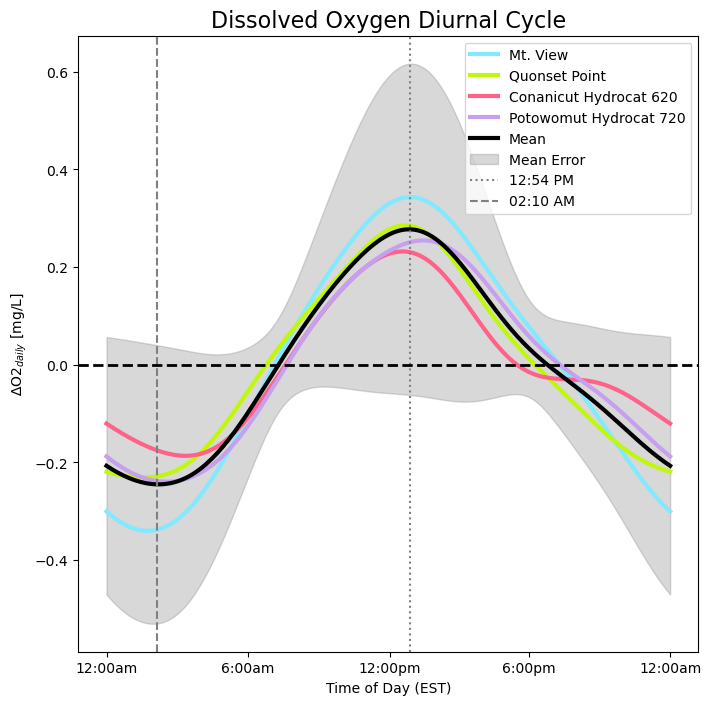

In [98]:
fig,ax = plt.subplots(figsize = [8,8])
LW = 3

STDo2 = np.sqrt(qpo2['QP 620 Std pH']**2 + mvo2['MV 620 Std pH']**2 + hydro620o2['Hydrocat 620 Std pH']**2 + hydro720o2['Hydrocat 720 Std pH']**2)
MNo2 = (mvo2['MV 620 Mean pH'] + qpo2['QP 620 Mean pH'] + hydro620o2['Hydrocat 620 Mean pH'] + hydro720o2['Hydrocat 720 Mean pH'])/4

ax.plot(df['Time'], mvo2['MV 620 Mean pH'], color = blue, lw = LW,
        label = 'Mt. View')
ax.plot(df['Time'], qpo2['QP 620 Mean pH'], color = green, lw = LW,
        label = 'Quonset Point')
ax.plot(df['Time'], hydro620o2['Hydrocat 620 Mean pH'], color = pink, lw = LW,
        label = 'Conanicut Hydrocat 620')
ax.plot(df['Time'], hydro720o2['Hydrocat 720 Mean pH'], color = purple, lw = LW,
        label = 'Potowomut Hydrocat 720')
ax.plot(df['Time'], MNo2, color = 'black', lw = LW,
        label = 'Mean')
ax.fill_between(df['Time'], MNo2 - STDo2, MNo2 + STDo2, color = 'gray', alpha = 0.3, label = 'Mean Error')
ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axvline(x = df['Time'].iloc[np.argmax(MNo2)], ls = 'dotted', color = 'gray',
          label = datetime.strftime(df['Time'].iloc[np.argmax(MNo2)], "%I:%M %p"))
ax.axvline(x = df['Time'].iloc[np.argmin(MNo2)], ls = 'dashed', color = 'gray',
          label = datetime.strftime(df['Time'].iloc[np.argmin(MNo2)], "%I:%M %p"))
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.set_ylabel('∆O2$_{daily}$ [mg/L]')
ax.set_title('Dissolved Oxygen Diurnal Cycle', fontsize = 16)
ax.set_xlabel('Time of Day (EST)')
ax.legend(loc = 'upper right')

# fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/diurnalcycle_o2_error.png', bbox_inches='tight')

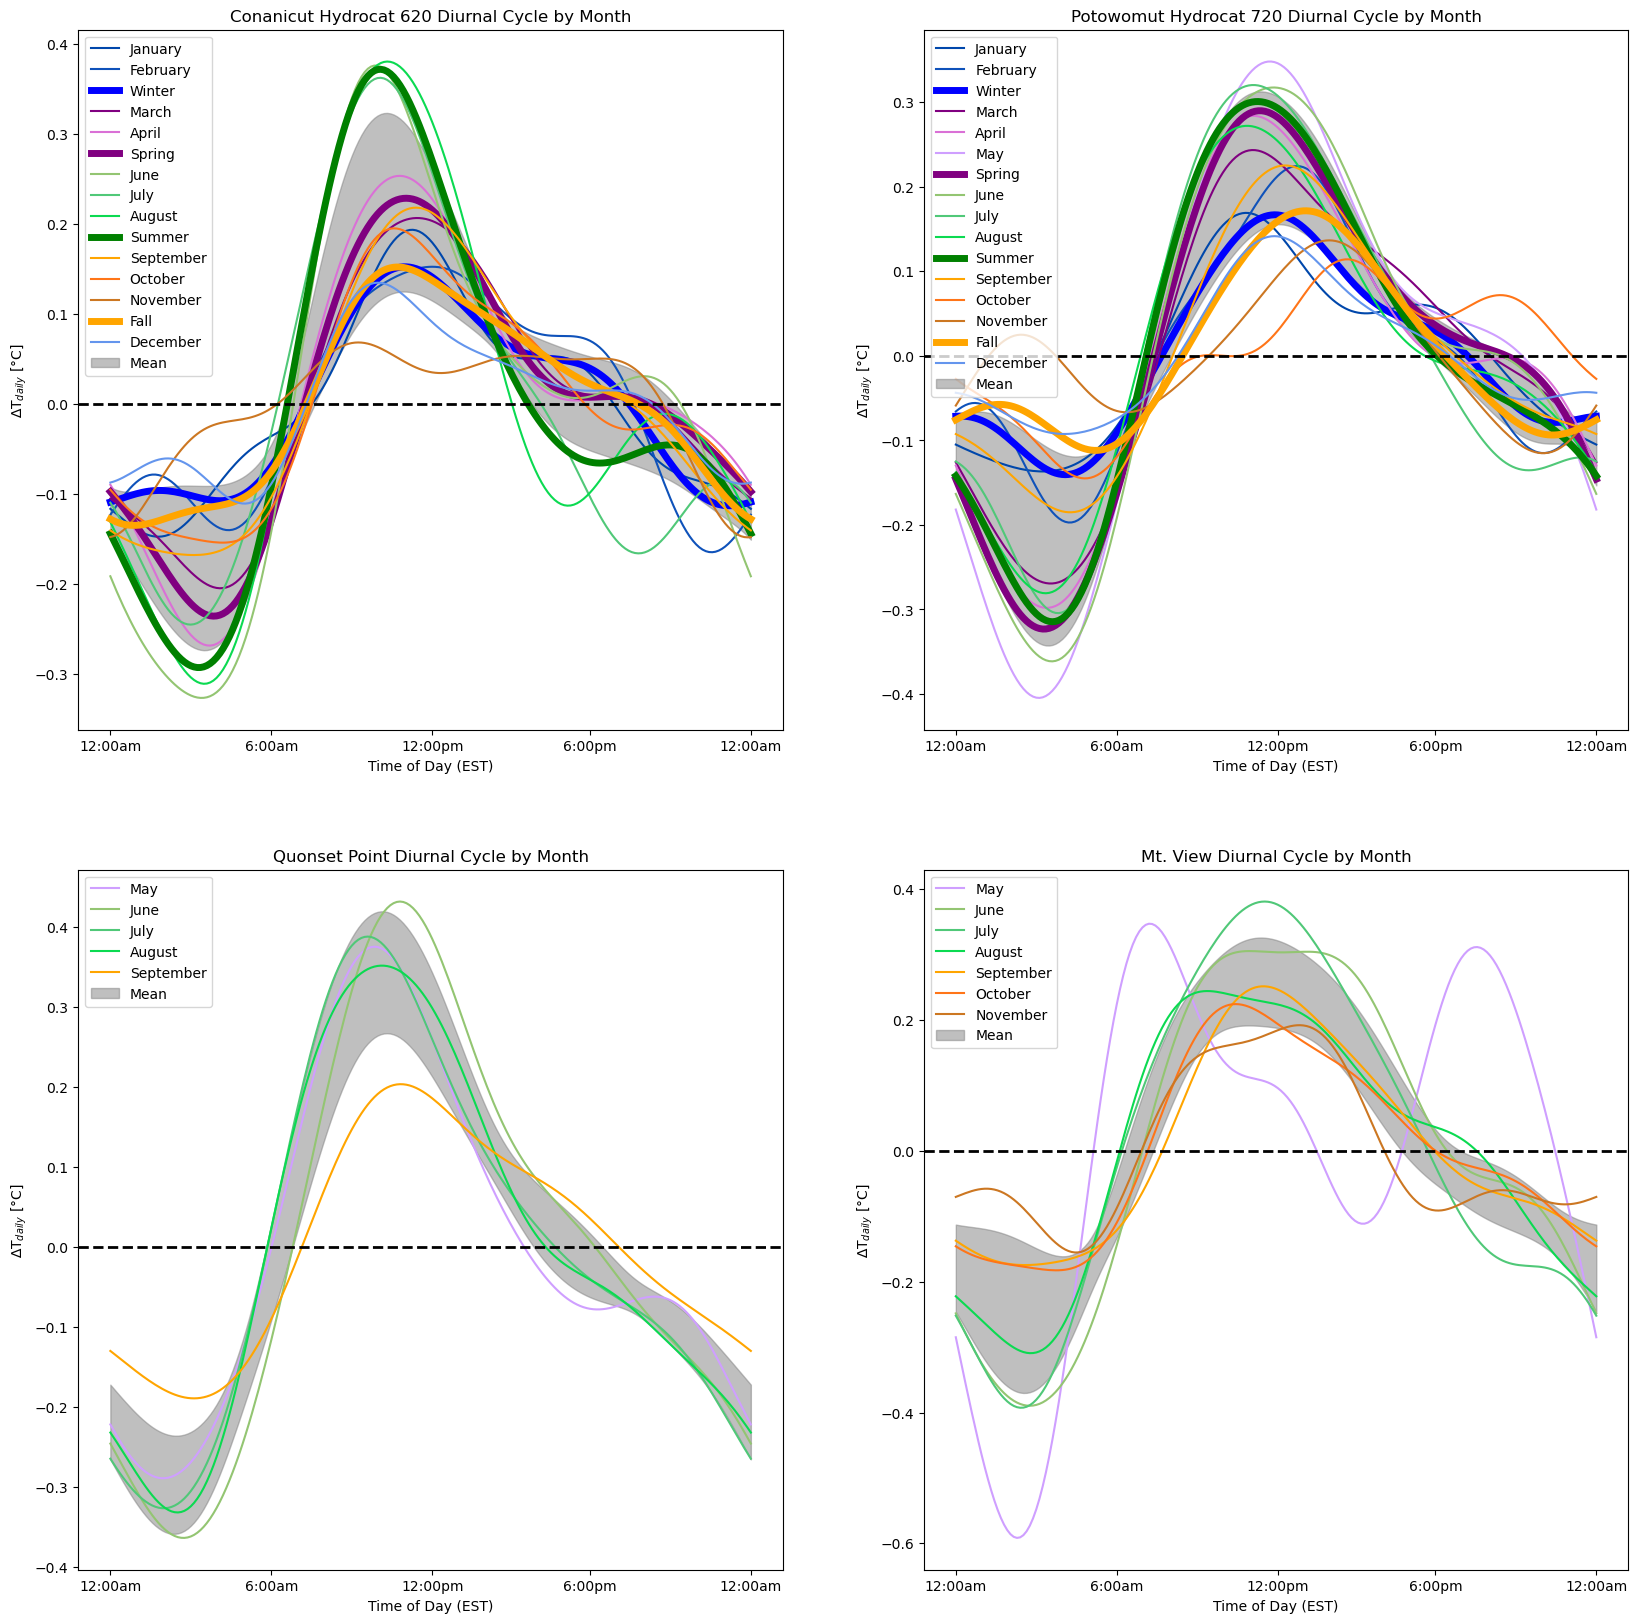

In [401]:
fig, axarr = plt.subplots(nrows = 2, ncols = 2, figsize = [20,20])
axarr = axarr.flatten()

ax = axarr[0]
df = hydro620t
ax.plot(df['Time'], df['Hydrocat 620 Jan'], color = janclr, label = 'January')
ax.plot(df['Time'], df['Hydrocat 620 Feb'], color = febclr, label = 'February')
winter = (df['Hydrocat 620 Jan'] + df['Hydrocat 620 Feb'] + df['Hydrocat 620 Dec'])/3
ax.plot(df['Time'], winter, color = 'blue', lw = 5, label = 'Winter')
ax.plot(df['Time'], df['Hydrocat 620 Mar'], color = marclr, label = 'March')
ax.plot(df['Time'], df['Hydrocat 620 Apr'], color = aprclr, label = 'April')
spring = (df['Hydrocat 620 Mar'] + df['Hydrocat 620 Apr'])/2
ax.plot(df['Time'], spring, color = 'purple', lw = 5, label = 'Spring')
ax.plot(df['Time'], df['Hydrocat 620 Jun'], color = junclr, label = 'June')
ax.plot(df['Time'], df['Hydrocat 620 Jul'], color = julclr, label = 'July')
ax.plot(df['Time'], df['Hydrocat 620 Aug'], color = augclr, label = 'August')
summer = (df['Hydrocat 620 Jun'] + df['Hydrocat 620 Jul'] + df['Hydrocat 620 Aug'])/3
ax.plot(df['Time'], summer, color = 'green', lw = 5, label = 'Summer')
ax.plot(df['Time'], df['Hydrocat 620 Sep'], color = sepclr, label = 'September')
ax.plot(df['Time'], df['Hydrocat 620 Oct'], color = octclr, label = 'October')
ax.plot(df['Time'], df['Hydrocat 620 Nov'], color = novclr, label = 'November')
fall = (df['Hydrocat 620 Nov'] + df['Hydrocat 620 Sep'] + df['Hydrocat 620 Oct'])/3
ax.plot(df['Time'], fall, color = 'orange', lw = 5, label = 'Fall')
ax.plot(df['Time'], df['Hydrocat 620 Dec'], color = decclr, label = 'December')
ax.fill_between(df['Time'], df['Hydrocat 620 Mean pH'] - df['Hydrocat 620 Std pH'], df['Hydrocat 620 Mean pH'] + df['Hydrocat 620 Std pH'],
                color = 'gray', alpha = 0.5, label = 'Mean')
ax.set_ylabel('∆T$_{daily}$ [°C]')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('Conanicut Hydrocat 620 Diurnal Cycle by Month')
ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.legend(loc = 'upper left')

ax = axarr[1]
df = hydro720t
ax.plot(df['Time'], df['Hydrocat 720 Jan'], color = janclr, label = 'January')
ax.plot(df['Time'], df['Hydrocat 720 Feb'], color = febclr, label = 'February')
winter = (df['Hydrocat 720 Jan'] + df['Hydrocat 720 Feb'] + df['Hydrocat 720 Dec'])/3
ax.plot(df['Time'], winter, color = 'blue', lw = 5, label = 'Winter')
ax.plot(df['Time'], df['Hydrocat 720 Mar'], color = marclr, label = 'March')
ax.plot(df['Time'], df['Hydrocat 720 Apr'], color = aprclr, label = 'April')
ax.plot(df['Time'], df['Hydrocat 720 May'], color = mayclr, label = 'May')
spring = (df['Hydrocat 720 Mar'] + df['Hydrocat 720 Apr'] + df['Hydrocat 720 May'])/3
ax.plot(df['Time'], spring, color = 'purple', lw = 5, label = 'Spring')
ax.plot(df['Time'], df['Hydrocat 720 Jun'], color = junclr, label = 'June')
ax.plot(df['Time'], df['Hydrocat 720 Jul'], color = julclr, label = 'July')
ax.plot(df['Time'], df['Hydrocat 720 Aug'], color = augclr, label = 'August')
summer = (df['Hydrocat 720 Jun'] + df['Hydrocat 720 Jul'] + df['Hydrocat 720 Aug'])/3
ax.plot(df['Time'], summer, color = 'green', lw = 5, label = 'Summer')
ax.plot(df['Time'], df['Hydrocat 720 Sep'], color = sepclr, label = 'September')
ax.plot(df['Time'], df['Hydrocat 720 Oct'], color = octclr, label = 'October')
ax.plot(df['Time'], df['Hydrocat 720 Nov'], color = novclr, label = 'November')
fall = (df['Hydrocat 720 Nov'] + df['Hydrocat 720 Sep'])/2
ax.plot(df['Time'], fall, color = 'orange', lw = 5, label = 'Fall')
ax.plot(df['Time'], df['Hydrocat 720 Dec'], color = decclr, label = 'December')
ax.fill_between(df['Time'], df['Hydrocat 720 Mean pH'] - df['Hydrocat 720 Std pH'], df['Hydrocat 720 Mean pH'] + df['Hydrocat 720 Std pH'],
                color = 'gray', alpha = 0.5, label = 'Mean')
ax.set_ylabel('∆T$_{daily}$ [°C]')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('Potowomut Hydrocat 720 Diurnal Cycle by Month')
ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.legend(loc = 'upper left')

ax = axarr[2]
df = qpt
ax.plot(df['Time'], df['QP 620 May'], color = mayclr, label = 'May')
ax.plot(df['Time'], df['QP 620 Jun'], color = junclr, label = 'June')
ax.plot(df['Time'], df['QP 620 Jul'], color = julclr, label = 'July')
ax.plot(df['Time'], df['QP 620 Aug'], color = augclr, label = 'August')
ax.plot(df['Time'], df['QP 620 Sep'], color = sepclr, label = 'September')
ax.fill_between(df['Time'], df['QP 620 Mean pH'] + df['QP 620 Std pH'], df['QP 620 Mean pH'] - df['QP 620 Std pH'],
                color = 'gray', alpha = 0.5, label = 'Mean')
ax.set_ylabel('∆T$_{daily}$ [°C]')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('Quonset Point Diurnal Cycle by Month')
ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.legend(loc = 'upper left')

ax = axarr[3]
df = mvt
ax.plot(df['Time'], df['MV 620 May'], color = mayclr, label = 'May')
ax.plot(df['Time'], df['MV 620 Jun'], color = junclr, label = 'June')
ax.plot(df['Time'], df['MV 620 Jul'], color = julclr, label = 'July')
ax.plot(df['Time'], df['MV 620 Aug'], color = augclr, label = 'August')
ax.plot(df['Time'], df['MV 620 Sep'], color = sepclr, label = 'September')
ax.plot(df['Time'], df['MV 620 Oct'], color = octclr, label = 'October')
ax.plot(df['Time'], df['MV 620 Nov'], color = novclr, label = 'November')
ax.fill_between(df['Time'], df['MV 620 Mean pH'] - df['MV 620 Std pH'], df['MV 620 Mean pH'] + df['MV 620 Std pH'],
                color = 'gray', alpha = 0.5, label = 'Mean')
ax.set_ylabel('∆T$_{daily}$ [°C]')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('Mt. View Diurnal Cycle by Month')
ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.legend(loc = 'upper left')

fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/seasonaldiurnalcycle_T_sensor.png', bbox_inches='tight')

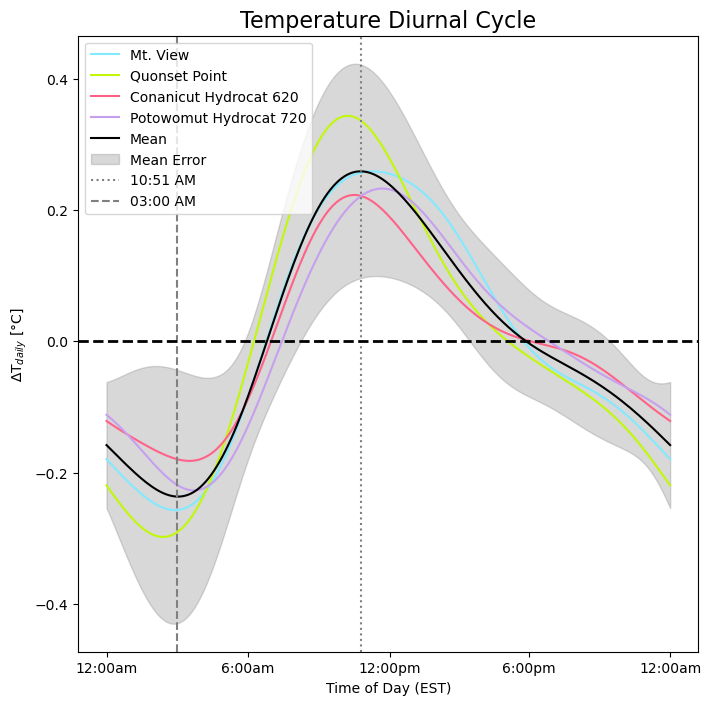

In [507]:
STDt = np.sqrt(qpt['QP 620 Std pH']**2 + mvt['MV 620 Std pH']**2 + hydro620t['Hydrocat 620 Std pH']**2 + hydro720t['Hydrocat 720 Std pH']**2)
MNt = (mvt['MV 620 Mean pH'] + qpt['QP 620 Mean pH'] + hydro620t['Hydrocat 620 Mean pH'] + hydro720t['Hydrocat 720 Mean pH'])/4

fig,ax = plt.subplots(figsize = [8,8])

ax.plot(df['Time'], mvt['MV 620 Mean pH'], color = blue, label = 'Mt. View')
ax.plot(df['Time'], qpt['QP 620 Mean pH'], color = green, label = 'Quonset Point')
ax.plot(df['Time'], hydro620t['Hydrocat 620 Mean pH'], color = pink, label = 'Conanicut Hydrocat 620')
ax.plot(df['Time'], hydro720t['Hydrocat 720 Mean pH'], color = purple, label = 'Potowomut Hydrocat 720')
ax.plot(df['Time'], MNt, color = 'black', label = 'Mean')
ax.fill_between(df['Time'], MNt - STDt, MNt + STDt, color = 'gray', alpha = 0.3, label = 'Mean Error')
ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axvline(x = df['Time'].iloc[np.argmax(MNt)], ls = 'dotted', color = 'gray',
          label = datetime.strftime(df['Time'].iloc[np.argmax(MNt)], "%I:%M %p"))
ax.axvline(x = df['Time'].iloc[np.argmin(MNt)], ls = 'dashed', color = 'gray',
          label = datetime.strftime(df['Time'].iloc[np.argmin(MNt)], "%I:%M %p"))
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.set_ylabel('∆T$_{daily}$ [°C]')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('Temperature Diurnal Cycle', fontsize = 16)
ax.legend(loc = 'upper left')

fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/diurnalcycle_T_error.png', bbox_inches='tight')

<AxesSubplot:>

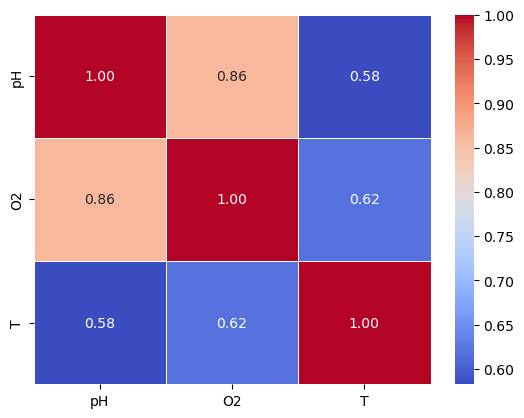

In [330]:
temp = {
        'pH': hydro620[['Hydrocat 620 Jan', 'Hydrocat 620 Feb', 'Hydrocat 620 Mar',
                        'Hydrocat 620 Apr', 'Hydrocat 620 Jun', 'Hydrocat 620 Jul',
                        'Hydrocat 620 Aug', 'Hydrocat 620 Sep', 'Hydrocat 620 Oct',
                        'Hydrocat 620 Nov', 'Hydrocat 620 Dec']].values.flatten(), 
        'O2': hydro620o2[['Hydrocat 620 Jan', 'Hydrocat 620 Feb', 'Hydrocat 620 Mar',
                        'Hydrocat 620 Apr', 'Hydrocat 620 Jun', 'Hydrocat 620 Jul',
                        'Hydrocat 620 Aug', 'Hydrocat 620 Sep', 'Hydrocat 620 Oct',
                        'Hydrocat 620 Nov', 'Hydrocat 620 Dec']].values.flatten(),
        'T': hydro620t[['Hydrocat 620 Jan', 'Hydrocat 620 Feb', 'Hydrocat 620 Mar',
                        'Hydrocat 620 Apr', 'Hydrocat 620 Jun', 'Hydrocat 620 Jul',
                        'Hydrocat 620 Aug', 'Hydrocat 620 Sep', 'Hydrocat 620 Oct',
                        'Hydrocat 620 Nov', 'Hydrocat 620 Dec']].values.flatten()}
dftemp = pd.DataFrame(temp)
corr = dftemp.corr(method = 'pearson')

sns.heatmap(corr**2,annot=True,fmt=".2f", linewidth=.5, cmap = 'coolwarm')

<AxesSubplot:>

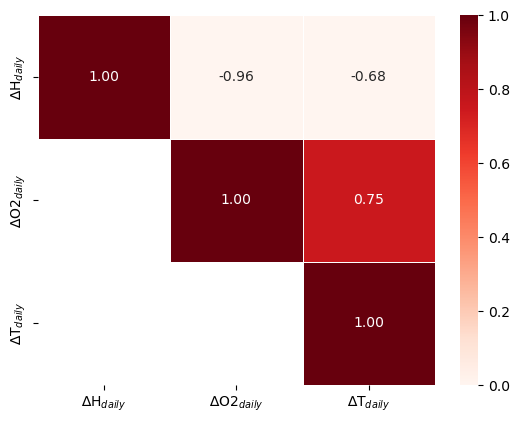

In [197]:
ap = hydro620[['Hydrocat 620 Jan', 'Hydrocat 620 Feb', 'Hydrocat 620 Mar',
          'Hydrocat 620 Apr', 'Hydrocat 620 Jun', 'Hydrocat 620 Jul',
          'Hydrocat 620 Aug', 'Hydrocat 620 Sep', 'Hydrocat 620 Oct',
          'Hydrocat 620 Nov', 'Hydrocat 620 Dec']].values.flatten()
bp = hydro720[['Hydrocat 720 Jan', 'Hydrocat 720 Feb', 'Hydrocat 720 Mar',
          'Hydrocat 720 Apr', 'Hydrocat 720 May', 'Hydrocat 720 Jun', 'Hydrocat 720 Jul',
          'Hydrocat 720 Aug', 'Hydrocat 720 Sep', 'Hydrocat 720 Oct',
          'Hydrocat 720 Nov', 'Hydrocat 720 Dec']].values.flatten()
cp = qp[['QP 620 May', 'QP 620 Jun', 'QP 620 Jul',
    'QP 620 Aug', 'QP 620 Sep']].values.flatten()
dp = mv[['MV 620 May', 'MV 620 Jun', 'MV 620 Jul',
    'MV 620 Aug', 'MV 620 Sep', 'MV 620 Oct', 'MV 620 Nov']].values.flatten()

ao = hydro620o2[['Hydrocat 620 Jan', 'Hydrocat 620 Feb', 'Hydrocat 620 Mar',
          'Hydrocat 620 Apr', 'Hydrocat 620 Jun', 'Hydrocat 620 Jul',
          'Hydrocat 620 Aug', 'Hydrocat 620 Sep', 'Hydrocat 620 Oct',
          'Hydrocat 620 Nov', 'Hydrocat 620 Dec']].values.flatten()
bo = hydro720o2[['Hydrocat 720 Jan', 'Hydrocat 720 Feb', 'Hydrocat 720 Mar',
          'Hydrocat 720 Apr', 'Hydrocat 720 May', 'Hydrocat 720 Jun', 'Hydrocat 720 Jul',
          'Hydrocat 720 Aug', 'Hydrocat 720 Sep', 'Hydrocat 720 Oct',
          'Hydrocat 720 Nov', 'Hydrocat 720 Dec']].values.flatten()
co = qpo2[['QP 620 May', 'QP 620 Jun', 'QP 620 Jul',
    'QP 620 Aug', 'QP 620 Sep']].values.flatten()
do = mvo2[['MV 620 May', 'MV 620 Jun', 'MV 620 Jul',
    'MV 620 Aug', 'MV 620 Sep', 'MV 620 Oct', 'MV 620 Nov']].values.flatten()

at = hydro620t[['Hydrocat 620 Jan', 'Hydrocat 620 Feb', 'Hydrocat 620 Mar',
          'Hydrocat 620 Apr', 'Hydrocat 620 Jun', 'Hydrocat 620 Jul',
          'Hydrocat 620 Aug', 'Hydrocat 620 Sep', 'Hydrocat 620 Oct',
          'Hydrocat 620 Nov', 'Hydrocat 620 Dec']].values.flatten()
bt = hydro720t[['Hydrocat 720 Jan', 'Hydrocat 720 Feb', 'Hydrocat 720 Mar',
          'Hydrocat 720 Apr', 'Hydrocat 720 May', 'Hydrocat 720 Jun', 'Hydrocat 720 Jul',
          'Hydrocat 720 Aug', 'Hydrocat 720 Sep', 'Hydrocat 720 Oct',
          'Hydrocat 720 Nov', 'Hydrocat 720 Dec']].values.flatten()
ct = qpt[['QP 620 May', 'QP 620 Jun', 'QP 620 Jul',
    'QP 620 Aug', 'QP 620 Sep']].values.flatten()
dt = mvt[['MV 620 May', 'MV 620 Jun', 'MV 620 Jul',
    'MV 620 Aug', 'MV 620 Sep', 'MV 620 Oct', 'MV 620 Nov']].values.flatten()

P1 = np.append(ap,bp)
P2 = np.append(cp,dp)
P = np.append(P1,P2)
O1 = np.append(ao,bo)
O2 = np.append(co,do)
O = np.append(O1,O2)
T1 = np.append(at,bt)
T2 = np.append(ct,dt)
T = np.append(T1,T2)

temp = {'∆H$_{daily}$': P, '∆O2$_{daily}$': O, '∆T$_{daily}$': T}
dftemp = pd.DataFrame(temp)
corr = dftemp.corr(method = 'pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots()
sns.heatmap(corr,ax = ax, mask = ~mask, annot=True,fmt=".2f", linewidth=.5, cmap = 'Reds', vmin = 0, vmax = 1)
# fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/diurnalcycle_corr.png', bbox_inches='tight')

Text(0.5, 1.0, 'December')

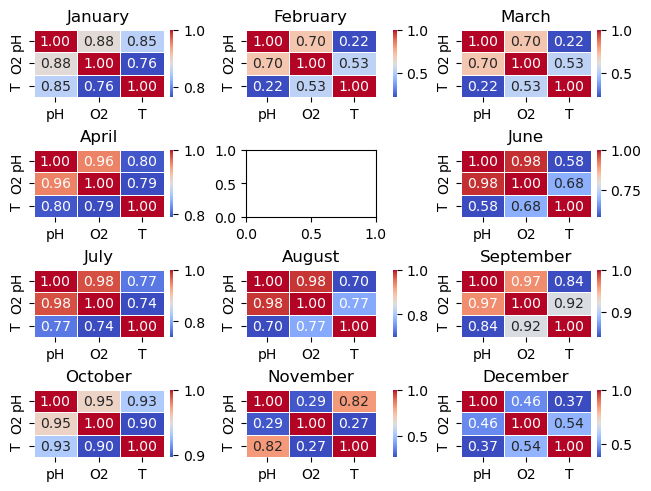

In [364]:
fig, axarr = plt.subplots(nrows = 4, ncols = 3, constrained_layout=True)
axarr = axarr.flatten()
# January
ax = axarr[0]
lab = 'Hydrocat 620 Jan'
temp = {'pH': hydro620[lab], 'O2': hydro620o2[lab], 'T': hydro620t[lab]}
dftemp = pd.DataFrame(temp)
corr = dftemp.corr(method = 'pearson')
sns.heatmap(corr**2, ax = ax, annot=True,fmt=".2f", linewidth=.5, cmap = 'coolwarm')
ax.set_title('January')

# Feb
ax = axarr[1]
lab = 'Hydrocat 620 Feb'
temp = {'pH': hydro620[lab], 'O2': hydro620o2[lab], 'T': hydro620t[lab]}
dftemp = pd.DataFrame(temp)
corr = dftemp.corr(method = 'pearson')
sns.heatmap(corr**2, ax = ax, annot=True,fmt=".2f", linewidth=.5, cmap = 'coolwarm')
ax.set_title('February')

# Mar
ax = axarr[2]
lab = 'Hydrocat 620 Feb'
temp = {'pH': hydro620[lab], 'O2': hydro620o2[lab], 'T': hydro620t[lab]}
dftemp = pd.DataFrame(temp)
corr = dftemp.corr(method = 'pearson')
sns.heatmap(corr**2, ax = ax, annot=True,fmt=".2f", linewidth=.5, cmap = 'coolwarm')
ax.set_title('March')

# Apr
ax = axarr[3]
lab = 'Hydrocat 620 Apr'
temp = {'pH': hydro620[lab], 'O2': hydro620o2[lab], 'T': hydro620t[lab]}
dftemp = pd.DataFrame(temp)
corr = dftemp.corr(method = 'pearson')
sns.heatmap(corr**2, ax = ax, annot=True,fmt=".2f", linewidth=.5, cmap = 'coolwarm')
ax.set_title('April')

# Jun
ax = axarr[5]
lab = 'Hydrocat 620 Jun'
temp = {'pH': hydro620[lab], 'O2': hydro620o2[lab], 'T': hydro620t[lab]}
dftemp = pd.DataFrame(temp)
corr = dftemp.corr(method = 'pearson')
sns.heatmap(corr**2, ax = ax, annot=True,fmt=".2f", linewidth=.5, cmap = 'coolwarm')
ax.set_title('June')

# Jul
ax = axarr[6]
lab = 'Hydrocat 620 Jul'
temp = {'pH': hydro620[lab], 'O2': hydro620o2[lab], 'T': hydro620t[lab]}
dftemp = pd.DataFrame(temp)
corr = dftemp.corr(method = 'pearson')
sns.heatmap(corr**2, ax = ax, annot=True,fmt=".2f", linewidth=.5, cmap = 'coolwarm')
ax.set_title('July')

# Aug
ax = axarr[7]
lab = 'Hydrocat 620 Aug'
temp = {'pH': hydro620[lab], 'O2': hydro620o2[lab], 'T': hydro620t[lab]}
dftemp = pd.DataFrame(temp)
corr = dftemp.corr(method = 'pearson')
sns.heatmap(corr**2, ax = ax, annot=True,fmt=".2f", linewidth=.5, cmap = 'coolwarm')
ax.set_title('August')

# Sep
ax = axarr[8]
lab = 'Hydrocat 620 Sep'
temp = {'pH': hydro620[lab], 'O2': hydro620o2[lab], 'T': hydro620t[lab]}
dftemp = pd.DataFrame(temp)
corr = dftemp.corr(method = 'pearson')
sns.heatmap(corr**2, ax = ax, annot=True,fmt=".2f", linewidth=.5, cmap = 'coolwarm')
ax.set_title('September')

# Oct
ax = axarr[9]
lab = 'Hydrocat 620 Oct'
temp = {'pH': hydro620[lab], 'O2': hydro620o2[lab], 'T': hydro620t[lab]}
dftemp = pd.DataFrame(temp)
corr = dftemp.corr(method = 'pearson')
sns.heatmap(corr**2, ax = ax, annot=True,fmt=".2f", linewidth=.5, cmap = 'coolwarm')
ax.set_title('October')

# Nov
ax = axarr[10]
lab = 'Hydrocat 620 Nov'
temp = {'pH': hydro620[lab], 'O2': hydro620o2[lab], 'T': hydro620t[lab]}
dftemp = pd.DataFrame(temp)
corr = dftemp.corr(method = 'pearson')
sns.heatmap(corr**2, ax = ax, annot=True,fmt=".2f", linewidth=.5, cmap = 'coolwarm')
ax.set_title('November')

# Dec
ax = axarr[11]
lab = 'Hydrocat 620 Dec'
temp = {'pH': hydro620[lab], 'O2': hydro620o2[lab], 'T': hydro620t[lab]}
dftemp = pd.DataFrame(temp)
corr = dftemp.corr(method = 'pearson')
sns.heatmap(corr**2, ax = ax, annot=True,fmt=".2f", linewidth=.5, cmap = 'coolwarm')
ax.set_title('December')

Text(0.5, 1.0, 'December')

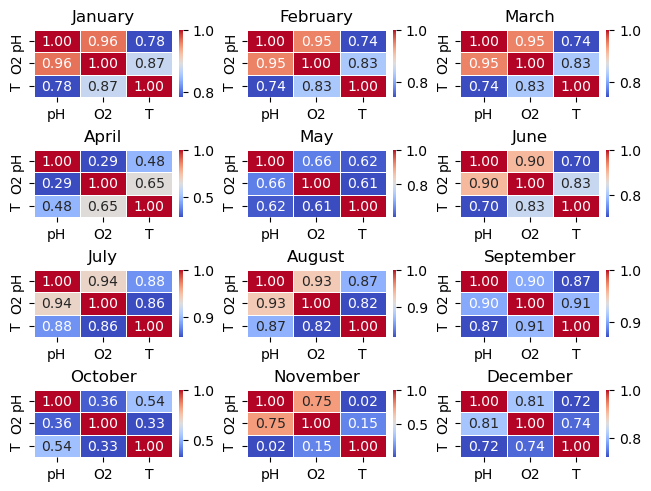

In [365]:
fig, axarr = plt.subplots(nrows = 4, ncols = 3, constrained_layout=True)
axarr = axarr.flatten()
# January
ax = axarr[0]
lab = 'Hydrocat 720 Jan'
temp = {'pH': hydro720[lab], 'O2': hydro720o2[lab], 'T': hydro720t[lab]}
dftemp = pd.DataFrame(temp)
corr = dftemp.corr(method = 'pearson')
sns.heatmap(corr**2, ax = ax, annot=True,fmt=".2f", linewidth=.5, cmap = 'coolwarm')
ax.set_title('January')

# Feb
ax = axarr[1]
lab = 'Hydrocat 720 Feb'
temp = {'pH': hydro720[lab], 'O2': hydro720o2[lab], 'T': hydro720t[lab]}
dftemp = pd.DataFrame(temp)
corr = dftemp.corr(method = 'pearson')
sns.heatmap(corr**2, ax = ax, annot=True,fmt=".2f", linewidth=.5, cmap = 'coolwarm')
ax.set_title('February')

# Mar
ax = axarr[2]
lab = 'Hydrocat 720 Feb'
temp = {'pH': hydro720[lab], 'O2': hydro720o2[lab], 'T': hydro720t[lab]}
dftemp = pd.DataFrame(temp)
corr = dftemp.corr(method = 'pearson')
sns.heatmap(corr**2, ax = ax, annot=True,fmt=".2f", linewidth=.5, cmap = 'coolwarm')
ax.set_title('March')

# Apr
ax = axarr[3]
lab = 'Hydrocat 720 Apr'
temp = {'pH': hydro720[lab], 'O2': hydro720o2[lab], 'T': hydro720t[lab]}
dftemp = pd.DataFrame(temp)
corr = dftemp.corr(method = 'pearson')
sns.heatmap(corr**2, ax = ax, annot=True,fmt=".2f", linewidth=.5, cmap = 'coolwarm')
ax.set_title('April')

# May
ax = axarr[4]
lab = 'Hydrocat 720 May'
temp = {'pH': hydro720[lab], 'O2': hydro720o2[lab], 'T': hydro720t[lab]}
dftemp = pd.DataFrame(temp)
corr = dftemp.corr(method = 'pearson')
sns.heatmap(corr**2, ax = ax, annot=True,fmt=".2f", linewidth=.5, cmap = 'coolwarm')
ax.set_title('May')

# Jun
ax = axarr[5]
lab = 'Hydrocat 720 Jun'
temp = {'pH': hydro720[lab], 'O2': hydro720o2[lab], 'T': hydro720t[lab]}
dftemp = pd.DataFrame(temp)
corr = dftemp.corr(method = 'pearson')
sns.heatmap(corr**2, ax = ax, annot=True,fmt=".2f", linewidth=.5, cmap = 'coolwarm')
ax.set_title('June')

# Jul
ax = axarr[6]
lab = 'Hydrocat 720 Jul'
temp = {'pH': hydro720[lab], 'O2': hydro720o2[lab], 'T': hydro720t[lab]}
dftemp = pd.DataFrame(temp)
corr = dftemp.corr(method = 'pearson')
sns.heatmap(corr**2, ax = ax, annot=True,fmt=".2f", linewidth=.5, cmap = 'coolwarm')
ax.set_title('July')

# Aug
ax = axarr[7]
lab = 'Hydrocat 720 Aug'
temp = {'pH': hydro720[lab], 'O2': hydro720o2[lab], 'T': hydro720t[lab]}
dftemp = pd.DataFrame(temp)
corr = dftemp.corr(method = 'pearson')
sns.heatmap(corr**2, ax = ax, annot=True,fmt=".2f", linewidth=.5, cmap = 'coolwarm')
ax.set_title('August')

# Sep
ax = axarr[8]
lab = 'Hydrocat 720 Sep'
temp = {'pH': hydro720[lab], 'O2': hydro720o2[lab], 'T': hydro720t[lab]}
dftemp = pd.DataFrame(temp)
corr = dftemp.corr(method = 'pearson')
sns.heatmap(corr**2, ax = ax, annot=True,fmt=".2f", linewidth=.5, cmap = 'coolwarm')
ax.set_title('September')

# Oct
ax = axarr[9]
lab = 'Hydrocat 720 Oct'
temp = {'pH': hydro720[lab], 'O2': hydro720o2[lab], 'T': hydro720t[lab]}
dftemp = pd.DataFrame(temp)
corr = dftemp.corr(method = 'pearson')
sns.heatmap(corr**2, ax = ax, annot=True,fmt=".2f", linewidth=.5, cmap = 'coolwarm')
ax.set_title('October')

# Nov
ax = axarr[10]
lab = 'Hydrocat 720 Nov'
temp = {'pH': hydro720[lab], 'O2': hydro720o2[lab], 'T': hydro720t[lab]}
dftemp = pd.DataFrame(temp)
corr = dftemp.corr(method = 'pearson')
sns.heatmap(corr**2, ax = ax, annot=True,fmt=".2f", linewidth=.5, cmap = 'coolwarm')
ax.set_title('November')

# Dec
ax = axarr[11]
lab = 'Hydrocat 720 Dec'
temp = {'pH': hydro720[lab], 'O2': hydro720o2[lab], 'T': hydro720t[lab]}
dftemp = pd.DataFrame(temp)
corr = dftemp.corr(method = 'pearson')
sns.heatmap(corr**2, ax = ax, annot=True,fmt=".2f", linewidth=.5, cmap = 'coolwarm')
ax.set_title('December')

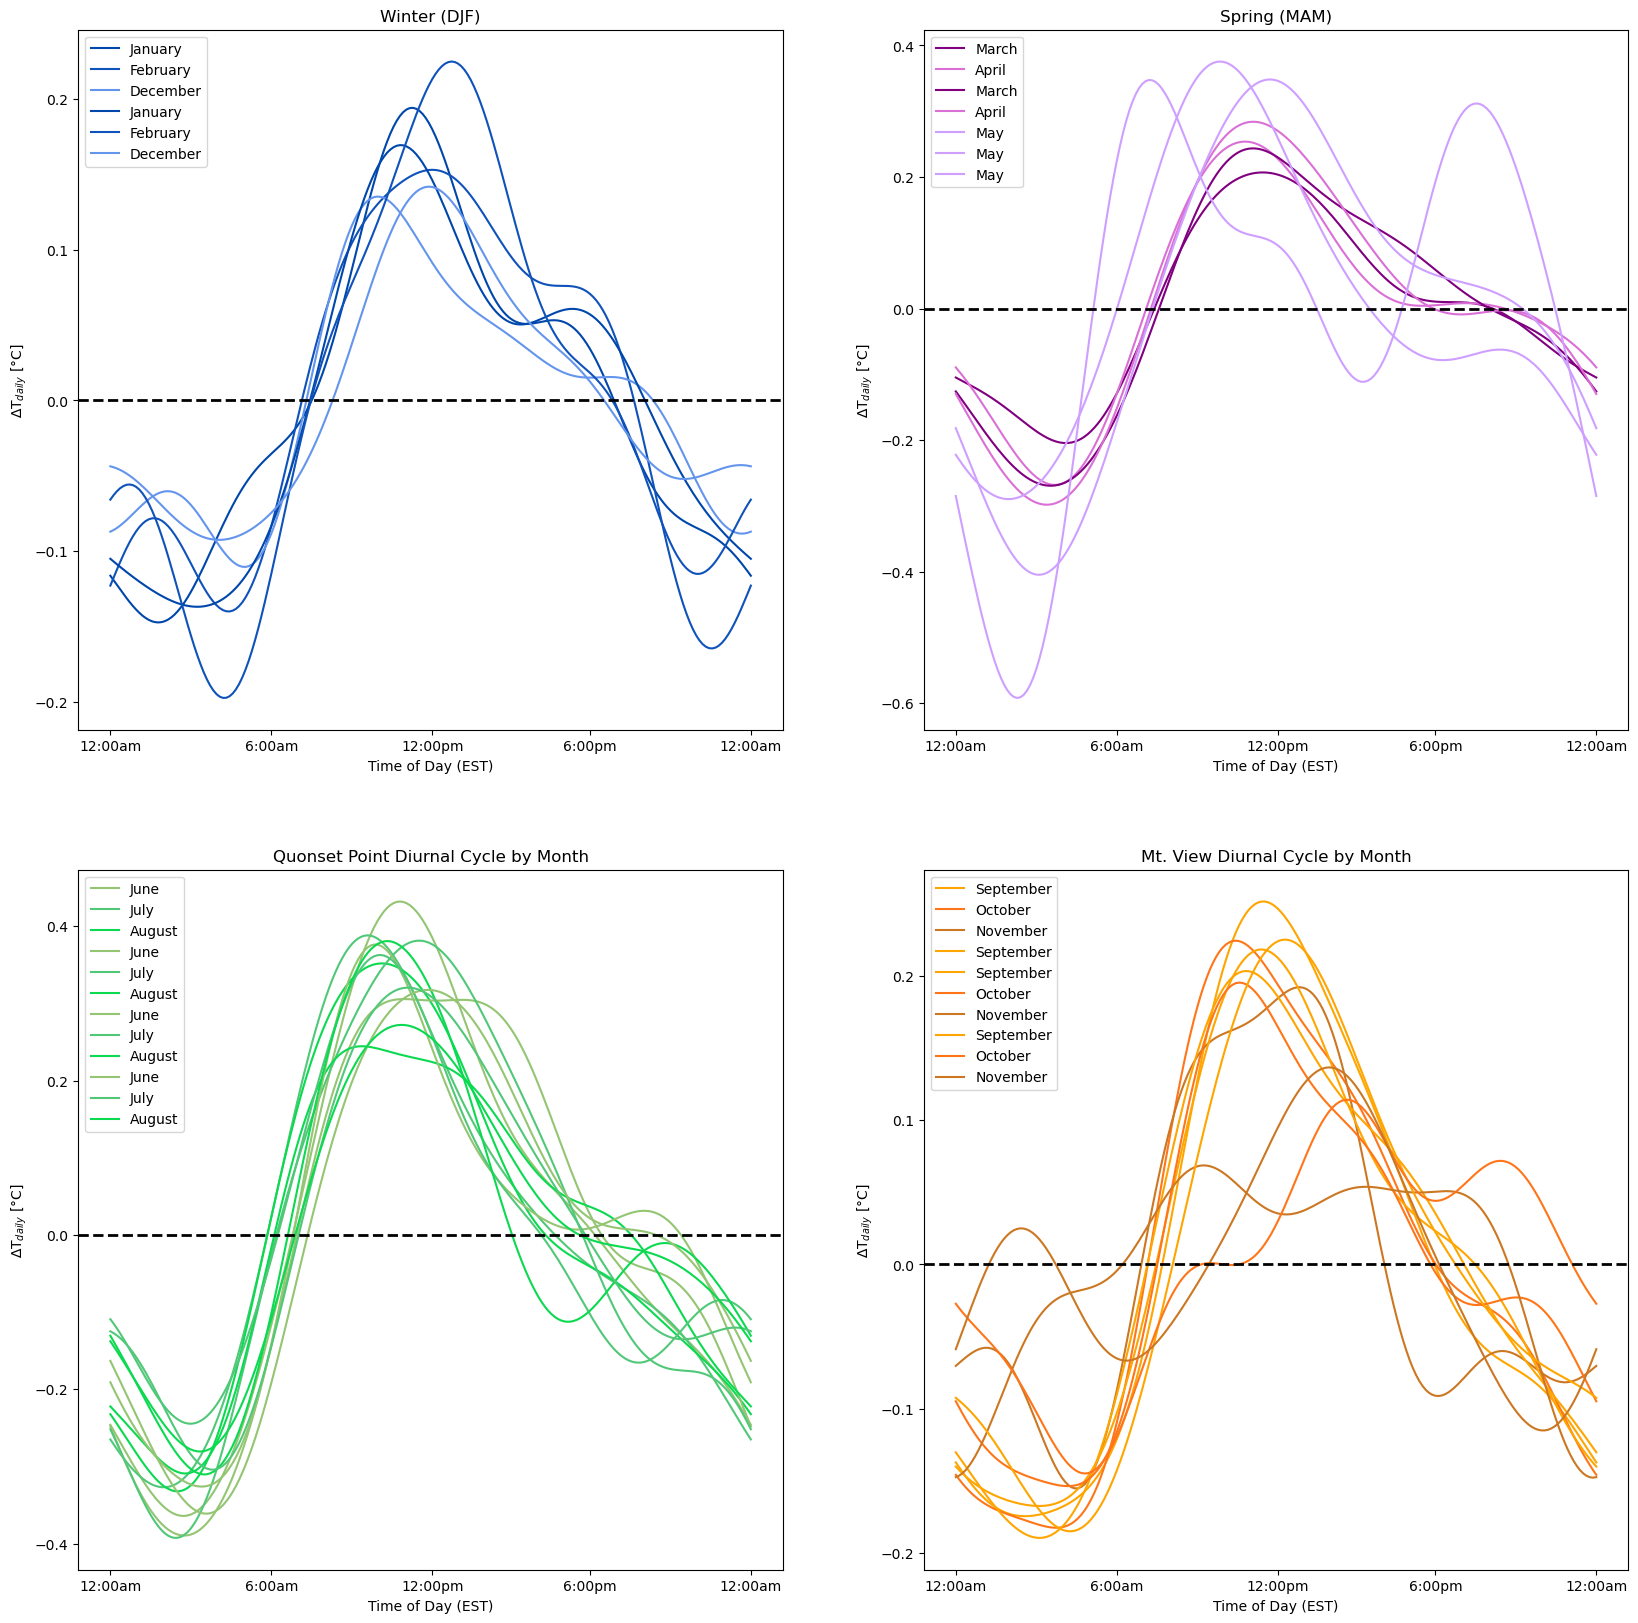

In [404]:
fig, axarr = plt.subplots(nrows = 2, ncols = 2, figsize = [20,20])
axarr = axarr.flatten()

# Winter
ax = axarr[0]
# 620
df = hydro620t
ax.plot(df['Time'], df['Hydrocat 620 Jan'], color = janclr, label = 'January')
ax.plot(df['Time'], df['Hydrocat 620 Feb'], color = febclr, label = 'February')
ax.plot(df['Time'], df['Hydrocat 620 Dec'], color = decclr, label = 'December')

# 720
df = hydro720t
ax.plot(df['Time'], df['Hydrocat 720 Jan'], color = janclr, label = 'January')
ax.plot(df['Time'], df['Hydrocat 720 Feb'], color = febclr, label = 'February')
ax.plot(df['Time'], df['Hydrocat 720 Dec'], color = decclr, label = 'December')

ax.set_ylabel('∆T$_{daily}$ [°C]')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('Winter (DJF)')
ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.legend(loc = 'upper left')

# Spring
ax = axarr[1]

# 620
df = hydro620t
ax.plot(df['Time'], df['Hydrocat 620 Mar'], color = marclr, label = 'March')
ax.plot(df['Time'], df['Hydrocat 620 Apr'], color = aprclr, label = 'April')

# 720
df = hydro720t
ax.plot(df['Time'], df['Hydrocat 720 Mar'], color = marclr, label = 'March')
ax.plot(df['Time'], df['Hydrocat 720 Apr'], color = aprclr, label = 'April')
ax.plot(df['Time'], df['Hydrocat 720 May'], color = mayclr, label = 'May')

# MV

df = mvt
ax.plot(df['Time'], df['MV 620 May'], color = mayclr, label = 'May')

# QP

df = qpt
ax.plot(df['Time'], df['QP 620 May'], color = mayclr, label = 'May')

ax.set_ylabel('∆T$_{daily}$ [°C]')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('Spring (MAM)')
ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.legend(loc = 'upper left')

# Summer
ax = axarr[2]
df = qpt
ax.plot(df['Time'], df['QP 620 Jun'], color = junclr, label = 'June')
ax.plot(df['Time'], df['QP 620 Jul'], color = julclr, label = 'July')
ax.plot(df['Time'], df['QP 620 Aug'], color = augclr, label = 'August')

df = mvt
ax.plot(df['Time'], df['MV 620 Jun'], color = junclr, label = 'June')
ax.plot(df['Time'], df['MV 620 Jul'], color = julclr, label = 'July')
ax.plot(df['Time'], df['MV 620 Aug'], color = augclr, label = 'August')

df = hydro620t
ax.plot(df['Time'], df['Hydrocat 620 Jun'], color = junclr, label = 'June')
ax.plot(df['Time'], df['Hydrocat 620 Jul'], color = julclr, label = 'July')
ax.plot(df['Time'], df['Hydrocat 620 Aug'], color = augclr, label = 'August')

df = hydro720t
ax.plot(df['Time'], df['Hydrocat 720 Jun'], color = junclr, label = 'June')
ax.plot(df['Time'], df['Hydrocat 720 Jul'], color = julclr, label = 'July')
ax.plot(df['Time'], df['Hydrocat 720 Aug'], color = augclr, label = 'August')

ax.set_ylabel('∆T$_{daily}$ [°C]')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('Quonset Point Diurnal Cycle by Month')
ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.legend(loc = 'upper left')

# Fall
ax = axarr[3]
df = mvt
ax.plot(df['Time'], df['MV 620 Sep'], color = sepclr, label = 'September')
ax.plot(df['Time'], df['MV 620 Oct'], color = octclr, label = 'October')
ax.plot(df['Time'], df['MV 620 Nov'], color = novclr, label = 'November')

df = qpt
ax.plot(df['Time'], df['QP 620 Sep'], color = sepclr, label = 'September')

df = hydro620t
ax.plot(df['Time'], df['Hydrocat 620 Sep'], color = sepclr, label = 'September')
ax.plot(df['Time'], df['Hydrocat 620 Oct'], color = octclr, label = 'October')
ax.plot(df['Time'], df['Hydrocat 620 Nov'], color = novclr, label = 'November')

df = hydro720t
ax.plot(df['Time'], df['Hydrocat 720 Sep'], color = sepclr, label = 'September')
ax.plot(df['Time'], df['Hydrocat 720 Oct'], color = octclr, label = 'October')
ax.plot(df['Time'], df['Hydrocat 720 Nov'], color = novclr, label = 'November')

ax.set_ylabel('∆T$_{daily}$ [°C]')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('Mt. View Diurnal Cycle by Month')
ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.legend(loc = 'upper left')

# fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/seasonaldiurnalcycle_T_sensor.png', bbox_inches='tight')

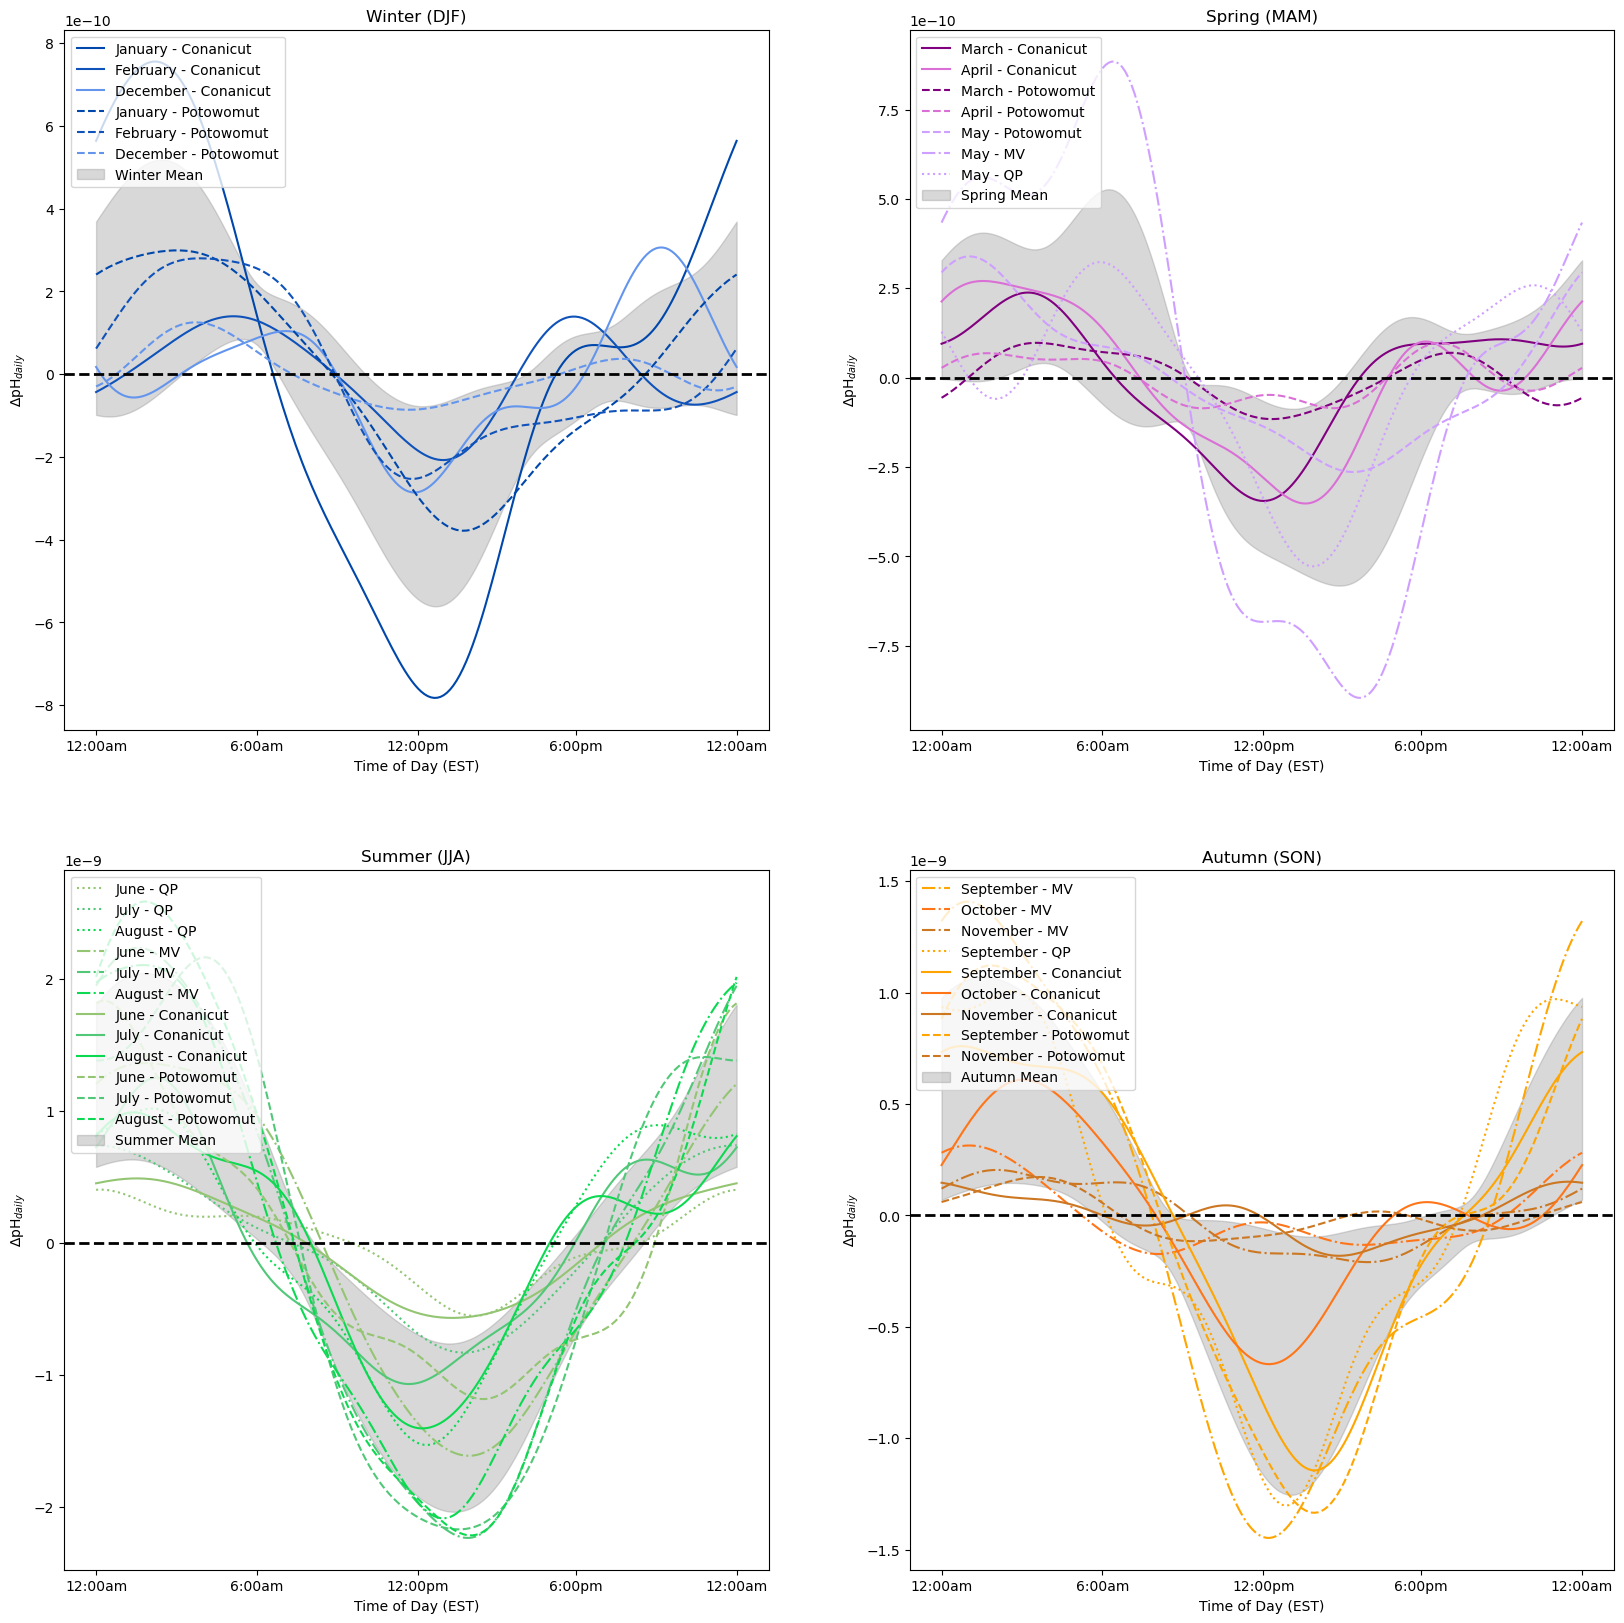

In [59]:
fig, axarr = plt.subplots(nrows = 2, ncols = 2, figsize = [20,20])
axarr = axarr.flatten()

# Winter
ax = axarr[0]
# 620
df = hydro620
ax.plot(df['Time'], df['Hydrocat 620 Jan'], color = janclr, label = 'January - Conanicut')
ax.plot(df['Time'], df['Hydrocat 620 Feb'], color = febclr, label = 'February - Conanicut')
ax.plot(df['Time'], df['Hydrocat 620 Dec'], color = decclr, label = 'December - Conanicut')

# 720
df = hydro720
ax.plot(df['Time'], df['Hydrocat 720 Jan'], color = janclr, ls = 'dashed', label = 'January - Potowomut')
ax.plot(df['Time'], df['Hydrocat 720 Feb'], color = febclr, ls = 'dashed', label = 'February - Potowomut')
ax.plot(df['Time'], df['Hydrocat 720 Dec'], color = decclr, ls = 'dashed', label = 'December - Potowomut')

winterph = np.zeros(len(df['Time']))
winterphstd = np.zeros(len(df['Time']))
for i in range(len(winterph)):
    winterph[i] = np.mean([hydro620['Hydrocat 620 Jan'][i], hydro620['Hydrocat 620 Feb'][i], hydro620['Hydrocat 620 Dec'][i],
                          hydro720['Hydrocat 720 Jan'][i], hydro720['Hydrocat 720 Feb'][i], hydro720['Hydrocat 720 Dec'][i]])
    winterphstd[i] = np.std([hydro620['Hydrocat 620 Jan'][i], hydro620['Hydrocat 620 Feb'][i], hydro620['Hydrocat 620 Dec'][i],
                          hydro720['Hydrocat 720 Jan'][i], hydro720['Hydrocat 720 Feb'][i], hydro720['Hydrocat 720 Dec'][i]], ddof = 1)
    
ax.fill_between(df['Time'], winterph + winterphstd, winterph - winterphstd, color = 'gray', alpha = 0.3, label = 'Winter Mean')
ax.set_ylabel('∆pH$_{daily}$')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('Winter (DJF)')
ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.legend(loc = 'upper left')

# Spring
ax = axarr[1]

# 620
df = hydro620
ax.plot(df['Time'], df['Hydrocat 620 Mar'], color = marclr, label = 'March - Conanicut')
ax.plot(df['Time'], df['Hydrocat 620 Apr'], color = aprclr, label = 'April - Conanicut')

# 720
df = hydro720
ax.plot(df['Time'], df['Hydrocat 720 Mar'], color = marclr, ls = 'dashed', label = 'March - Potowomut')
ax.plot(df['Time'], df['Hydrocat 720 Apr'], color = aprclr, ls = 'dashed', label = 'April - Potowomut')
ax.plot(df['Time'], df['Hydrocat 720 May'], color = mayclr, ls = 'dashed', label = 'May - Potowomut')

# MV

df = mv
ax.plot(df['Time'], df['MV 620 May'], color = mayclr, ls = 'dashdot', label = 'May - MV')

# QP

df = qp
ax.plot(df['Time'], df['QP 620 May'], color = mayclr, ls = 'dotted', label = 'May - QP')

springph = np.zeros(len(df['Time']))
springphstd = np.zeros(len(df['Time']))
for i in range(len(winterph)):
    springph[i] = np.mean([hydro620['Hydrocat 620 Mar'][i], hydro620['Hydrocat 620 Apr'][i], mv['MV 620 May'][i],
                          hydro720['Hydrocat 720 Mar'][i], hydro720['Hydrocat 720 Apr'][i], hydro720['Hydrocat 720 May'][i],
                          qp['QP 620 May'][i]])
    springphstd[i] = np.std([hydro620['Hydrocat 620 Mar'][i], hydro620['Hydrocat 620 Apr'][i], mv['MV 620 May'][i],
                          hydro720['Hydrocat 720 Mar'][i], hydro720['Hydrocat 720 Apr'][i], hydro720['Hydrocat 720 May'][i],
                          qp['QP 620 May'][i]], ddof = 1)
    
ax.fill_between(df['Time'], springph + springphstd, springph - springphstd, color = 'gray', alpha = 0.3, label = 'Spring Mean')

ax.set_ylabel('∆pH$_{daily}$')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('Spring (MAM)')
ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.legend(loc = 'upper left')

# Summer
ax = axarr[2]
df = qp
ax.plot(df['Time'], df['QP 620 Jun'], color = junclr, ls = 'dotted', label = 'June - QP')
ax.plot(df['Time'], df['QP 620 Jul'], color = julclr, ls = 'dotted', label = 'July - QP')
ax.plot(df['Time'], df['QP 620 Aug'], color = augclr, ls = 'dotted', label = 'August - QP')

df = mv
ax.plot(df['Time'], df['MV 620 Jun'], color = junclr, ls = 'dashdot', label = 'June - MV')
ax.plot(df['Time'], df['MV 620 Jul'], color = julclr, ls = 'dashdot', label = 'July - MV')
ax.plot(df['Time'], df['MV 620 Aug'], color = augclr, ls = 'dashdot', label = 'August - MV')

df = hydro620
ax.plot(df['Time'], df['Hydrocat 620 Jun'], color = junclr, label = 'June - Conanicut')
ax.plot(df['Time'], df['Hydrocat 620 Jul'], color = julclr, label = 'July - Conanicut')
ax.plot(df['Time'], df['Hydrocat 620 Aug'], color = augclr, label = 'August - Conanicut')

df = hydro720
ax.plot(df['Time'], df['Hydrocat 720 Jun'], color = junclr, ls = 'dashed', label = 'June - Potowomut')
ax.plot(df['Time'], df['Hydrocat 720 Jul'], color = julclr, ls = 'dashed', label = 'July - Potowomut')
ax.plot(df['Time'], df['Hydrocat 720 Aug'], color = augclr, ls = 'dashed', label = 'August - Potowomut')

summerph = np.zeros(len(df['Time']))
summerphstd = np.zeros(len(df['Time']))
for i in range(len(winterph)):
    summerph[i] = np.mean([hydro620['Hydrocat 620 Jun'][i], hydro620['Hydrocat 620 Jul'][i], hydro620['Hydrocat 620 Aug'][i],
                           mv['MV 620 Jun'][i], mv['MV 620 Jul'][i], mv['MV 620 Aug'][i],
                           hydro720['Hydrocat 720 Jun'][i], hydro720['Hydrocat 720 Jul'][i], hydro720['Hydrocat 720 Aug'][i],
                           qp['QP 620 Jul'][i], qp['QP 620 Jun'][i], qp['QP 620 Aug'][i]])
    summerphstd[i] = np.std([hydro620['Hydrocat 620 Jun'][i], hydro620['Hydrocat 620 Jul'][i], hydro620['Hydrocat 620 Aug'][i],
                           mv['MV 620 Jun'][i], mv['MV 620 Jul'][i], mv['MV 620 Aug'][i],
                           hydro720['Hydrocat 720 Jun'][i], hydro720['Hydrocat 720 Jul'][i], hydro720['Hydrocat 720 Aug'][i],
                           qp['QP 620 Jul'][i], qp['QP 620 Jun'][i], qp['QP 620 Aug'][i]], ddof = 1)
    
ax.fill_between(df['Time'], summerph + summerphstd, summerph - summerphstd, color = 'gray', alpha = 0.3, label = 'Summer Mean')

ax.set_ylabel('∆pH$_{daily}$')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('Summer (JJA)')
ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.legend(loc = 'upper left')

# Fall
ax = axarr[3]
df = mv
ax.plot(df['Time'], df['MV 620 Sep'], color = sepclr, ls = 'dashdot', label = 'September - MV')
ax.plot(df['Time'], df['MV 620 Oct'], color = octclr, ls = 'dashdot', label = 'October - MV')
ax.plot(df['Time'], df['MV 620 Nov'], color = novclr, ls = 'dashdot', label = 'November - MV')

df = qp
ax.plot(df['Time'], df['QP 620 Sep'], color = sepclr, ls = 'dotted', label = 'September - QP')

df = hydro620
ax.plot(df['Time'], df['Hydrocat 620 Sep'], color = sepclr, label = 'September - Conanciut')
ax.plot(df['Time'], df['Hydrocat 620 Oct'], color = octclr, label = 'October - Conanicut')
ax.plot(df['Time'], df['Hydrocat 620 Nov'], color = novclr, label = 'November - Conanicut')

df = hydro720
ax.plot(df['Time'], df['Hydrocat 720 Sep'], color = sepclr, ls = 'dashed', label = 'September - Potowomut')
# ax.plot(df['Time'], df['Hydrocat 720 Oct'], color = octclr, ls = 'dashed', label = 'October')
ax.plot(df['Time'], df['Hydrocat 720 Nov'], color = novclr, ls = 'dashed', label = 'November - Potowomut')

fallph = np.zeros(len(df['Time']))
fallphstd = np.zeros(len(df['Time']))
for i in range(len(winterph)):
    fallph[i] = np.mean([hydro620['Hydrocat 620 Sep'][i], hydro620['Hydrocat 620 Oct'][i], hydro620['Hydrocat 620 Nov'][i],
                           mv['MV 620 Sep'][i], mv['MV 620 Oct'][i], mv['MV 620 Nov'][i],
                           hydro720['Hydrocat 720 Sep'][i], hydro720['Hydrocat 720 Nov'][i], 
                           qp['QP 620 Sep'][i]])
    fallphstd[i] = np.std([hydro620['Hydrocat 620 Sep'][i], hydro620['Hydrocat 620 Oct'][i], hydro620['Hydrocat 620 Nov'][i],
                           mv['MV 620 Sep'][i], mv['MV 620 Oct'][i], mv['MV 620 Nov'][i],
                           hydro720['Hydrocat 720 Sep'][i], hydro720['Hydrocat 720 Nov'][i], 
                           qp['QP 620 Sep'][i]], ddof = 1)
    
ax.fill_between(df['Time'], fallph + fallphstd, fallph - fallphstd, color = 'gray', alpha = 0.3, label = 'Autumn Mean')

ax.set_ylabel('∆pH$_{daily}$')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('Autumn (SON)')
ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.legend(loc = 'upper left')

# fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/seasonaldiurnalcycle_T_sensor.png', bbox_inches='tight')

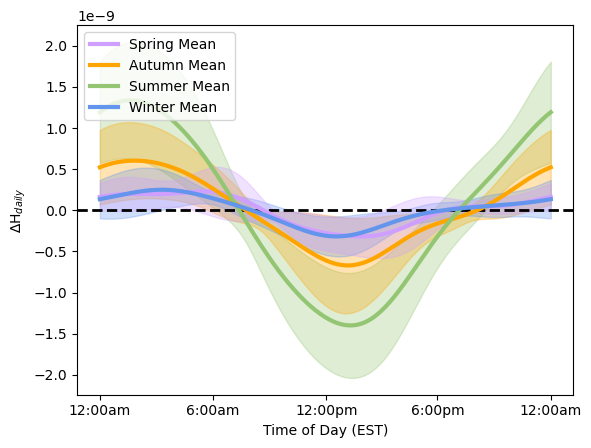

In [60]:
fig, ax = plt.subplots()

# ax.fill_between(df['Time'], summerph + summerphstd, summerph - summerphstd, 
#                 alpha = 0.5, hatch = 'OO', facecolors = 'none', edgecolors = junclr, label = 'Summer Mean')

# ax.fill_between(df['Time'], fallph + fallphstd, fallph - fallphstd, 
#                 alpha = 0.5, hatch = '**', facecolors = 'none', edgecolors = sepclr, label = 'Autumn Mean')

# ax.fill_between(df['Time'], winterph + winterphstd, winterph - winterphstd, 
#                 alpha = 0.5, hatch = '++', facecolors = 'none', edgecolors = decclr, label = 'Winter Mean')

# ax.fill_between(df['Time'], springph + springphstd, springph - springphstd, 
#                 alpha = 0.5, hatch = 'oo', facecolors = 'none', edgecolors = mayclr, label = 'Spring Mean')

ax.fill_between(df['Time'], summerph + summerphstd, summerph - summerphstd, 
                alpha = 0.3, color = junclr)

ax.fill_between(df['Time'], fallph + fallphstd, fallph - fallphstd, 
                alpha = 0.3, color = sepclr)

ax.fill_between(df['Time'], winterph + winterphstd, winterph - winterphstd, 
                alpha = 0.3, color = decclr)

ax.fill_between(df['Time'], springph + springphstd, springph - springphstd, 
                alpha = 0.3, color = mayclr)

ax.plot(df['Time'], springph, lw = 3,
       color = mayclr, label = 'Spring Mean', zorder = 3)
ax.plot(df['Time'], fallph, lw = 3,
       color = sepclr, label = 'Autumn Mean', zorder = 3)
ax.plot(df['Time'], summerph, lw = 3,
       color = junclr, label = 'Summer Mean', zorder = 3)
ax.plot(df['Time'], winterph, lw = 3,
       color = decclr, label = 'Winter Mean', zorder = 3)

ax.set_ylabel('∆H$_{daily}$')
ax.set_xlabel('Time of Day (EST)')
# ax.set_title('Autumn (SON)')
ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.legend(loc = 'upper left')


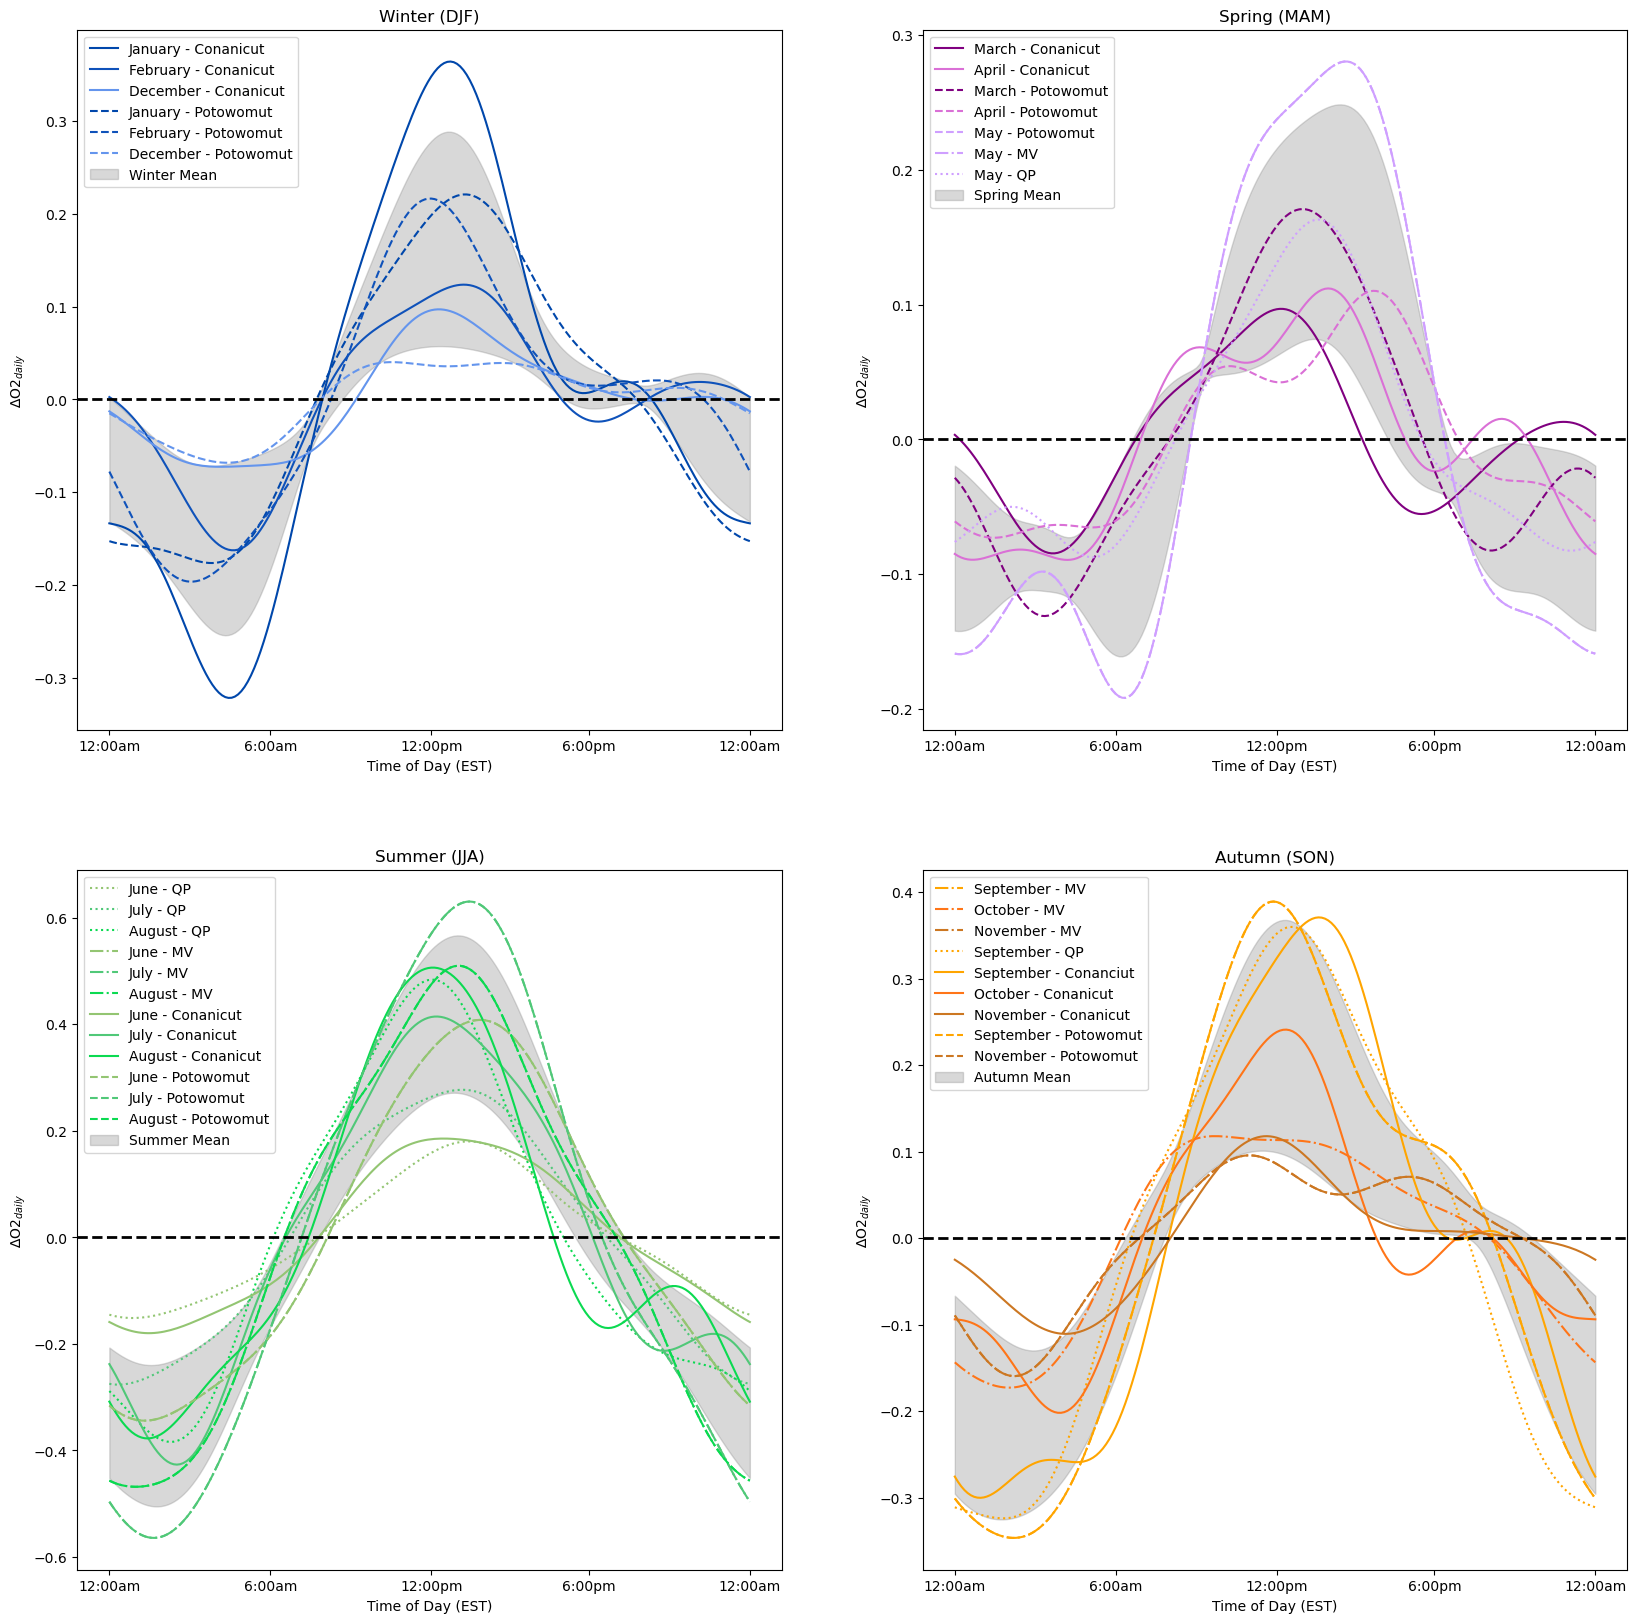

In [473]:
fig, axarr = plt.subplots(nrows = 2, ncols = 2, figsize = [20,20])
axarr = axarr.flatten()

# Winter
ax = axarr[0]
# 620
df = hydro620o2
ax.plot(df['Time'], df['Hydrocat 620 Jan'], color = janclr, label = 'January - Conanicut')
ax.plot(df['Time'], df['Hydrocat 620 Feb'], color = febclr, label = 'February - Conanicut')
ax.plot(df['Time'], df['Hydrocat 620 Dec'], color = decclr, label = 'December - Conanicut')

# 720
df = hydro720o2
ax.plot(df['Time'], df['Hydrocat 720 Jan'], color = janclr, ls = 'dashed', label = 'January - Potowomut')
ax.plot(df['Time'], df['Hydrocat 720 Feb'], color = febclr, ls = 'dashed', label = 'February - Potowomut')
ax.plot(df['Time'], df['Hydrocat 720 Dec'], color = decclr, ls = 'dashed', label = 'December - Potowomut')

wintero2 = np.zeros(len(df['Time']))
wintero2std = np.zeros(len(df['Time']))
for i in range(len(winterph)):
    wintero2[i] = np.mean([hydro620o2['Hydrocat 620 Jan'][i], hydro620o2['Hydrocat 620 Feb'][i], hydro620o2['Hydrocat 620 Dec'][i],
                          hydro720o2['Hydrocat 720 Jan'][i], hydro720o2['Hydrocat 720 Feb'][i], hydro720o2['Hydrocat 720 Dec'][i]])
    wintero2std[i] = np.std([hydro620o2['Hydrocat 620 Jan'][i], hydro620o2['Hydrocat 620 Feb'][i], hydro620o2['Hydrocat 620 Dec'][i],
                          hydro720o2['Hydrocat 720 Jan'][i], hydro720o2['Hydrocat 720 Feb'][i], hydro720o2['Hydrocat 720 Dec'][i]], ddof = 1)
    
ax.fill_between(df['Time'], wintero2 + wintero2std, wintero2 - wintero2std, color = 'gray', alpha = 0.3, label = 'Winter Mean')
ax.set_ylabel('∆O2$_{daily}$')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('Winter (DJF)')
ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.legend(loc = 'upper left')

# Spring
ax = axarr[1]

# 620
df = hydro620o2
ax.plot(df['Time'], df['Hydrocat 620 Mar'], color = marclr, label = 'March - Conanicut')
ax.plot(df['Time'], df['Hydrocat 620 Apr'], color = aprclr, label = 'April - Conanicut')

# 720
df = hydro720o2
ax.plot(df['Time'], df['Hydrocat 720 Mar'], color = marclr, ls = 'dashed', label = 'March - Potowomut')
ax.plot(df['Time'], df['Hydrocat 720 Apr'], color = aprclr, ls = 'dashed', label = 'April - Potowomut')
ax.plot(df['Time'], df['Hydrocat 720 May'], color = mayclr, ls = 'dashed', label = 'May - Potowomut')

# MV

df = mvo2
ax.plot(df['Time'], df['MV 620 May'], color = mayclr, ls = 'dashdot', label = 'May - MV')

# QP

df = qpo2
ax.plot(df['Time'], df['QP 620 May'], color = mayclr, ls = 'dotted', label = 'May - QP')

springo2 = np.zeros(len(df['Time']))
springo2std = np.zeros(len(df['Time']))
for i in range(len(winterph)):
    springo2[i] = np.mean([hydro620o2['Hydrocat 620 Mar'][i], hydro620o2['Hydrocat 620 Apr'][i], mvo2['MV 620 May'][i],
                          hydro720o2['Hydrocat 720 Mar'][i], hydro720o2['Hydrocat 720 Apr'][i], hydro720o2['Hydrocat 720 May'][i],
                          qpo2['QP 620 May'][i]])
    springo2std[i] = np.std([hydro620o2['Hydrocat 620 Mar'][i], hydro620o2['Hydrocat 620 Apr'][i], mvo2['MV 620 May'][i],
                          hydro720o2['Hydrocat 720 Mar'][i], hydro720o2['Hydrocat 720 Apr'][i], hydro720o2['Hydrocat 720 May'][i],
                          qpo2['QP 620 May'][i]], ddof = 1)
    
ax.fill_between(df['Time'], springo2 + springo2std, springo2 - springo2std, color = 'gray', alpha = 0.3, label = 'Spring Mean')

ax.set_ylabel('∆O2$_{daily}$')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('Spring (MAM)')
ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.legend(loc = 'upper left')

# Summer
ax = axarr[2]
df = qpo2
ax.plot(df['Time'], df['QP 620 Jun'], color = junclr, ls = 'dotted', label = 'June - QP')
ax.plot(df['Time'], df['QP 620 Jul'], color = julclr, ls = 'dotted', label = 'July - QP')
ax.plot(df['Time'], df['QP 620 Aug'], color = augclr, ls = 'dotted', label = 'August - QP')

df = mvo2
ax.plot(df['Time'], df['MV 620 Jun'], color = junclr, ls = 'dashdot', label = 'June - MV')
ax.plot(df['Time'], df['MV 620 Jul'], color = julclr, ls = 'dashdot', label = 'July - MV')
ax.plot(df['Time'], df['MV 620 Aug'], color = augclr, ls = 'dashdot', label = 'August - MV')

df = hydro620o2
ax.plot(df['Time'], df['Hydrocat 620 Jun'], color = junclr, label = 'June - Conanicut')
ax.plot(df['Time'], df['Hydrocat 620 Jul'], color = julclr, label = 'July - Conanicut')
ax.plot(df['Time'], df['Hydrocat 620 Aug'], color = augclr, label = 'August - Conanicut')

df = hydro720o2
ax.plot(df['Time'], df['Hydrocat 720 Jun'], color = junclr, ls = 'dashed', label = 'June - Potowomut')
ax.plot(df['Time'], df['Hydrocat 720 Jul'], color = julclr, ls = 'dashed', label = 'July - Potowomut')
ax.plot(df['Time'], df['Hydrocat 720 Aug'], color = augclr, ls = 'dashed', label = 'August - Potowomut')

summero2 = np.zeros(len(df['Time']))
summero2std = np.zeros(len(df['Time']))
for i in range(len(winterph)):
    summero2[i] = np.mean([hydro620o2['Hydrocat 620 Jun'][i], hydro620o2['Hydrocat 620 Jul'][i], hydro620o2['Hydrocat 620 Aug'][i],
                           mvo2['MV 620 Jun'][i], mvo2['MV 620 Jul'][i], mvo2['MV 620 Aug'][i],
                           hydro720o2['Hydrocat 720 Jun'][i], hydro720o2['Hydrocat 720 Jul'][i], hydro720o2['Hydrocat 720 Aug'][i],
                           qpo2['QP 620 Jul'][i], qpo2['QP 620 Jun'][i], qpo2['QP 620 Aug'][i]])
    summero2std[i] = np.std([hydro620o2['Hydrocat 620 Jun'][i], hydro620o2['Hydrocat 620 Jul'][i], hydro620o2['Hydrocat 620 Aug'][i],
                           mvo2['MV 620 Jun'][i], mvo2['MV 620 Jul'][i], mvo2['MV 620 Aug'][i],
                           hydro720o2['Hydrocat 720 Jun'][i], hydro720o2['Hydrocat 720 Jul'][i], hydro720o2['Hydrocat 720 Aug'][i],
                           qpo2['QP 620 Jul'][i], qpo2['QP 620 Jun'][i], qpo2['QP 620 Aug'][i]], ddof = 1)
    
ax.fill_between(df['Time'], summero2 + summero2std, summero2 - summero2std, color = 'gray', alpha = 0.3, label = 'Summer Mean')

ax.set_ylabel('∆O2$_{daily}$')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('Summer (JJA)')
ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.legend(loc = 'upper left')

# Fall
ax = axarr[3]
df = mvo2
ax.plot(df['Time'], df['MV 620 Sep'], color = sepclr, ls = 'dashdot', label = 'September - MV')
ax.plot(df['Time'], df['MV 620 Oct'], color = octclr, ls = 'dashdot', label = 'October - MV')
ax.plot(df['Time'], df['MV 620 Nov'], color = novclr, ls = 'dashdot', label = 'November - MV')

df = qpo2
ax.plot(df['Time'], df['QP 620 Sep'], color = sepclr, ls = 'dotted', label = 'September - QP')

df = hydro620o2
ax.plot(df['Time'], df['Hydrocat 620 Sep'], color = sepclr, label = 'September - Conanciut')
ax.plot(df['Time'], df['Hydrocat 620 Oct'], color = octclr, label = 'October - Conanicut')
ax.plot(df['Time'], df['Hydrocat 620 Nov'], color = novclr, label = 'November - Conanicut')

df = hydro720o2
ax.plot(df['Time'], df['Hydrocat 720 Sep'], color = sepclr, ls = 'dashed', label = 'September - Potowomut')
# ax.plot(df['Time'], df['Hydrocat 720 Oct'], color = octclr, ls = 'dashed', label = 'October')
ax.plot(df['Time'], df['Hydrocat 720 Nov'], color = novclr, ls = 'dashed', label = 'November - Potowomut')

fallo2 = np.zeros(len(df['Time']))
fallo2std = np.zeros(len(df['Time']))
for i in range(len(winterph)):
    fallo2[i] = np.mean([hydro620o2['Hydrocat 620 Sep'][i], hydro620o2['Hydrocat 620 Oct'][i], hydro620o2['Hydrocat 620 Nov'][i],
                           mvo2['MV 620 Sep'][i], mvo2['MV 620 Oct'][i], mvo2['MV 620 Nov'][i],
                           hydro720o2['Hydrocat 720 Sep'][i], hydro720o2['Hydrocat 720 Nov'][i], 
                           qpo2['QP 620 Sep'][i]])
    fallo2std[i] = np.std([hydro620o2['Hydrocat 620 Sep'][i], hydro620o2['Hydrocat 620 Oct'][i], hydro620o2['Hydrocat 620 Nov'][i],
                           mvo2['MV 620 Sep'][i], mvo2['MV 620 Oct'][i], mvo2['MV 620 Nov'][i],
                           hydro720o2['Hydrocat 720 Sep'][i], hydro720o2['Hydrocat 720 Nov'][i], 
                           qpo2['QP 620 Sep'][i]], ddof = 1)
    
ax.fill_between(df['Time'], fallo2 + fallo2std, fallo2 - fallo2std, color = 'gray', alpha = 0.3, label = 'Autumn Mean')

ax.set_ylabel('∆O2$_{daily}$')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('Autumn (SON)')
ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.legend(loc = 'upper left')

# fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/seasonaldiurnalcycle_T_sensor.png', bbox_inches='tight')

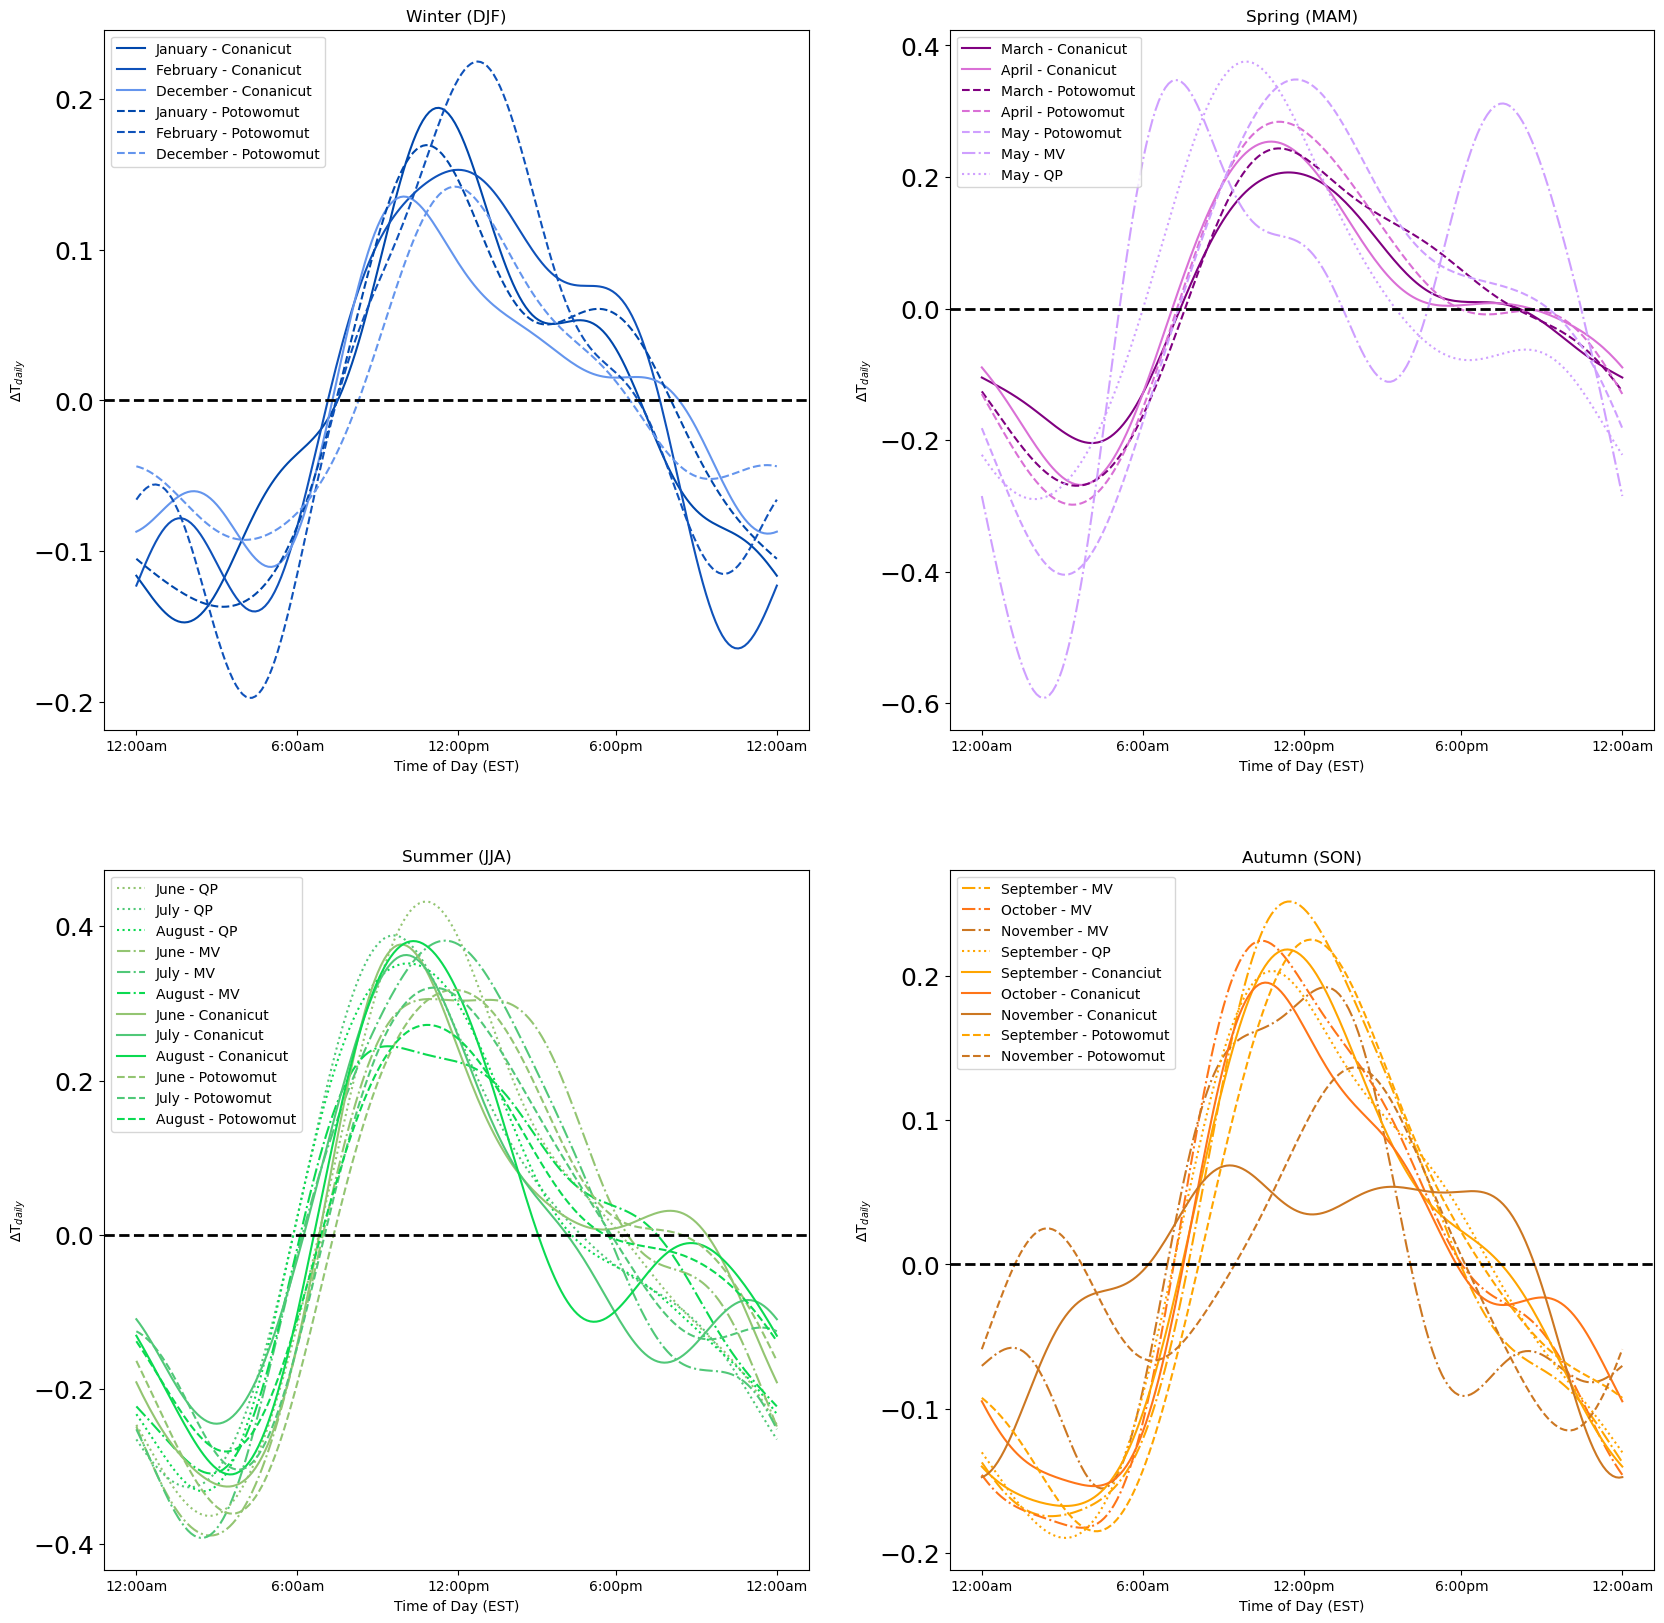

In [605]:
fig, axarr = plt.subplots(nrows = 2, ncols = 2, figsize = [20,20])
axarr = axarr.flatten()

# Winter
ax = axarr[0]
# 620
df = hydro620t
ax.plot(df['Time'], df['Hydrocat 620 Jan'], color = janclr, label = 'January - Conanicut')
ax.plot(df['Time'], df['Hydrocat 620 Feb'], color = febclr, label = 'February - Conanicut')
ax.plot(df['Time'], df['Hydrocat 620 Dec'], color = decclr, label = 'December - Conanicut')

# 720
df = hydro720t
ax.plot(df['Time'], df['Hydrocat 720 Jan'], color = janclr, ls = 'dashed', label = 'January - Potowomut')
ax.plot(df['Time'], df['Hydrocat 720 Feb'], color = febclr, ls = 'dashed', label = 'February - Potowomut')
ax.plot(df['Time'], df['Hydrocat 720 Dec'], color = decclr, ls = 'dashed', label = 'December - Potowomut')

# wintero2 = np.zeros(len(df['Time']))
# wintero2std = np.zeros(len(df['Time']))
# for i in range(len(winterph)):
#     wintero2[i] = np.mean([hydro620o2['Hydrocat 620 Jan'][i], hydro620o2['Hydrocat 620 Feb'][i], hydro620o2['Hydrocat 620 Dec'][i],
#                           hydro720o2['Hydrocat 720 Jan'][i], hydro720o2['Hydrocat 720 Feb'][i], hydro720o2['Hydrocat 720 Dec'][i]])
#     wintero2std[i] = np.std([hydro620o2['Hydrocat 620 Jan'][i], hydro620o2['Hydrocat 620 Feb'][i], hydro620o2['Hydrocat 620 Dec'][i],
#                           hydro720o2['Hydrocat 720 Jan'][i], hydro720o2['Hydrocat 720 Feb'][i], hydro720o2['Hydrocat 720 Dec'][i]], ddof = 1)
    
# ax.fill_between(df['Time'], wintero2 + wintero2std, wintero2 - wintero2std, color = 'gray', alpha = 0.3, label = 'Winter Mean')
ax.set_ylabel('∆T$_{daily}$')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('Winter (DJF)')
ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.legend(loc = 'upper left')

# Spring
ax = axarr[1]

# 620
df = hydro620t
ax.plot(df['Time'], df['Hydrocat 620 Mar'], color = marclr, label = 'March - Conanicut')
ax.plot(df['Time'], df['Hydrocat 620 Apr'], color = aprclr, label = 'April - Conanicut')

# 720
df = hydro720t
ax.plot(df['Time'], df['Hydrocat 720 Mar'], color = marclr, ls = 'dashed', label = 'March - Potowomut')
ax.plot(df['Time'], df['Hydrocat 720 Apr'], color = aprclr, ls = 'dashed', label = 'April - Potowomut')
ax.plot(df['Time'], df['Hydrocat 720 May'], color = mayclr, ls = 'dashed', label = 'May - Potowomut')

# MV

df = mvt
ax.plot(df['Time'], df['MV 620 May'], color = mayclr, ls = 'dashdot', label = 'May - MV')

# QP

df = qpt
ax.plot(df['Time'], df['QP 620 May'], color = mayclr, ls = 'dotted', label = 'May - QP')

# springo2 = np.zeros(len(df['Time']))
# springo2std = np.zeros(len(df['Time']))
# for i in range(len(winterph)):
#     springo2[i] = np.mean([hydro620o2['Hydrocat 620 Mar'][i], hydro620o2['Hydrocat 620 Apr'][i], mvo2['MV 620 May'][i],
#                           hydro720o2['Hydrocat 720 Mar'][i], hydro720o2['Hydrocat 720 Apr'][i], hydro720o2['Hydrocat 720 May'][i],
#                           qpo2['QP 620 May'][i]])
#     springo2std[i] = np.std([hydro620o2['Hydrocat 620 Mar'][i], hydro620o2['Hydrocat 620 Apr'][i], mvo2['MV 620 May'][i],
#                           hydro720o2['Hydrocat 720 Mar'][i], hydro720o2['Hydrocat 720 Apr'][i], hydro720o2['Hydrocat 720 May'][i],
#                           qpo2['QP 620 May'][i]], ddof = 1)
    
# ax.fill_between(df['Time'], springo2 + springo2std, springo2 - springo2std, color = 'gray', alpha = 0.3, label = 'Spring Mean')

ax.set_ylabel('∆T$_{daily}$')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('Spring (MAM)')
ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.legend(loc = 'upper left')

# Summer
ax = axarr[2]
df = qpt
ax.plot(df['Time'], df['QP 620 Jun'], color = junclr, ls = 'dotted', label = 'June - QP')
ax.plot(df['Time'], df['QP 620 Jul'], color = julclr, ls = 'dotted', label = 'July - QP')
ax.plot(df['Time'], df['QP 620 Aug'], color = augclr, ls = 'dotted', label = 'August - QP')

df = mvt
ax.plot(df['Time'], df['MV 620 Jun'], color = junclr, ls = 'dashdot', label = 'June - MV')
ax.plot(df['Time'], df['MV 620 Jul'], color = julclr, ls = 'dashdot', label = 'July - MV')
ax.plot(df['Time'], df['MV 620 Aug'], color = augclr, ls = 'dashdot', label = 'August - MV')

df = hydro620t
ax.plot(df['Time'], df['Hydrocat 620 Jun'], color = junclr, label = 'June - Conanicut')
ax.plot(df['Time'], df['Hydrocat 620 Jul'], color = julclr, label = 'July - Conanicut')
ax.plot(df['Time'], df['Hydrocat 620 Aug'], color = augclr, label = 'August - Conanicut')

df = hydro720t
ax.plot(df['Time'], df['Hydrocat 720 Jun'], color = junclr, ls = 'dashed', label = 'June - Potowomut')
ax.plot(df['Time'], df['Hydrocat 720 Jul'], color = julclr, ls = 'dashed', label = 'July - Potowomut')
ax.plot(df['Time'], df['Hydrocat 720 Aug'], color = augclr, ls = 'dashed', label = 'August - Potowomut')

# summero2 = np.zeros(len(df['Time']))
# summero2std = np.zeros(len(df['Time']))
# for i in range(len(winterph)):
#     summero2[i] = np.mean([hydro620o2['Hydrocat 620 Jun'][i], hydro620o2['Hydrocat 620 Jul'][i], hydro620o2['Hydrocat 620 Aug'][i],
#                            mvo2['MV 620 Jun'][i], mvo2['MV 620 Jul'][i], mvo2['MV 620 Aug'][i],
#                            hydro720o2['Hydrocat 720 Jun'][i], hydro720o2['Hydrocat 720 Jul'][i], hydro720o2['Hydrocat 720 Aug'][i],
#                            qpo2['QP 620 Jul'][i], qpo2['QP 620 Jun'][i], qpo2['QP 620 Aug'][i]])
#     summero2std[i] = np.std([hydro620o2['Hydrocat 620 Jun'][i], hydro620o2['Hydrocat 620 Jul'][i], hydro620o2['Hydrocat 620 Aug'][i],
#                            mvo2['MV 620 Jun'][i], mvo2['MV 620 Jul'][i], mvo2['MV 620 Aug'][i],
#                            hydro720o2['Hydrocat 720 Jun'][i], hydro720o2['Hydrocat 720 Jul'][i], hydro720o2['Hydrocat 720 Aug'][i],
#                            qpo2['QP 620 Jul'][i], qpo2['QP 620 Jun'][i], qpo2['QP 620 Aug'][i]], ddof = 1)
    
# ax.fill_between(df['Time'], summero2 + summero2std, summero2 - summero2std, color = 'gray', alpha = 0.3, label = 'Summer Mean')

ax.set_ylabel('∆T$_{daily}$')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('Summer (JJA)')
ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.legend(loc = 'upper left')

# Fall
ax = axarr[3]
df = mvt
ax.plot(df['Time'], df['MV 620 Sep'], color = sepclr, ls = 'dashdot', label = 'September - MV')
ax.plot(df['Time'], df['MV 620 Oct'], color = octclr, ls = 'dashdot', label = 'October - MV')
ax.plot(df['Time'], df['MV 620 Nov'], color = novclr, ls = 'dashdot', label = 'November - MV')

df = qpt
ax.plot(df['Time'], df['QP 620 Sep'], color = sepclr, ls = 'dotted', label = 'September - QP')

df = hydro620t
ax.plot(df['Time'], df['Hydrocat 620 Sep'], color = sepclr, label = 'September - Conanciut')
ax.plot(df['Time'], df['Hydrocat 620 Oct'], color = octclr, label = 'October - Conanicut')
ax.plot(df['Time'], df['Hydrocat 620 Nov'], color = novclr, label = 'November - Conanicut')

df = hydro720t
ax.plot(df['Time'], df['Hydrocat 720 Sep'], color = sepclr, ls = 'dashed', label = 'September - Potowomut')
# ax.plot(df['Time'], df['Hydrocat 720 Oct'], color = octclr, ls = 'dashed', label = 'October')
ax.plot(df['Time'], df['Hydrocat 720 Nov'], color = novclr, ls = 'dashed', label = 'November - Potowomut')

# fallo2 = np.zeros(len(df['Time']))
# fallo2std = np.zeros(len(df['Time']))
# for i in range(len(winterph)):
#     fallo2[i] = np.mean([hydro620o2['Hydrocat 620 Sep'][i], hydro620o2['Hydrocat 620 Oct'][i], hydro620o2['Hydrocat 620 Nov'][i],
#                            mvo2['MV 620 Sep'][i], mvo2['MV 620 Oct'][i], mvo2['MV 620 Nov'][i],
#                            hydro720o2['Hydrocat 720 Sep'][i], hydro720o2['Hydrocat 720 Nov'][i], 
#                            qpo2['QP 620 Sep'][i]])
#     fallo2std[i] = np.std([hydro620o2['Hydrocat 620 Sep'][i], hydro620o2['Hydrocat 620 Oct'][i], hydro620o2['Hydrocat 620 Nov'][i],
#                            mvo2['MV 620 Sep'][i], mvo2['MV 620 Oct'][i], mvo2['MV 620 Nov'][i],
#                            hydro720o2['Hydrocat 720 Sep'][i], hydro720o2['Hydrocat 720 Nov'][i], 
#                            qpo2['QP 620 Sep'][i]], ddof = 1)
    
# ax.fill_between(df['Time'], fallo2 + fallo2std, fallo2 - fallo2std, color = 'gray', alpha = 0.3, label = 'Autumn Mean')

ax.set_ylabel('∆T$_{daily}$')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('Autumn (SON)')
ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.legend(loc = 'upper left')

# fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/seasonaldiurnalcycle_T_sensor.png', bbox_inches='tight')

In [99]:
# Oxygen
summero2 = np.zeros(len(df['Time']))
summero2std = np.zeros(len(df['Time']))
for i in range(len(winterph)):
    summero2[i] = np.mean([hydro620o2['Hydrocat 620 Jun'][i], hydro620o2['Hydrocat 620 Jul'][i], hydro620o2['Hydrocat 620 Aug'][i],
                           mvo2['MV 620 Jun'][i], mvo2['MV 620 Jul'][i], mvo2['MV 620 Aug'][i],
                           hydro720o2['Hydrocat 720 Jun'][i], hydro720o2['Hydrocat 720 Jul'][i], hydro720o2['Hydrocat 720 Aug'][i],
                           qpo2['QP 620 Jul'][i], qpo2['QP 620 Jun'][i], qpo2['QP 620 Aug'][i]])
    summero2std[i] = np.std([hydro620o2['Hydrocat 620 Jun'][i], hydro620o2['Hydrocat 620 Jul'][i], hydro620o2['Hydrocat 620 Aug'][i],
                           mvo2['MV 620 Jun'][i], mvo2['MV 620 Jul'][i], mvo2['MV 620 Aug'][i],
                           hydro720o2['Hydrocat 720 Jun'][i], hydro720o2['Hydrocat 720 Jul'][i], hydro720o2['Hydrocat 720 Aug'][i],
                           qpo2['QP 620 Jul'][i], qpo2['QP 620 Jun'][i], qpo2['QP 620 Aug'][i]], ddof = 1)

fallo2 = np.zeros(len(df['Time']))
fallo2std = np.zeros(len(df['Time']))
for i in range(len(winterph)):
    fallo2[i] = np.mean([hydro620o2['Hydrocat 620 Sep'][i], hydro620o2['Hydrocat 620 Oct'][i], hydro620o2['Hydrocat 620 Nov'][i],
                           mvo2['MV 620 Sep'][i], mvo2['MV 620 Oct'][i], mvo2['MV 620 Nov'][i],
                           hydro720o2['Hydrocat 720 Sep'][i], hydro720o2['Hydrocat 720 Nov'][i], 
                           qpo2['QP 620 Sep'][i]])
    fallo2std[i] = np.std([hydro620o2['Hydrocat 620 Sep'][i], hydro620o2['Hydrocat 620 Oct'][i], hydro620o2['Hydrocat 620 Nov'][i],
                           mvo2['MV 620 Sep'][i], mvo2['MV 620 Oct'][i], mvo2['MV 620 Nov'][i],
                           hydro720o2['Hydrocat 720 Sep'][i], hydro720o2['Hydrocat 720 Nov'][i], 
                           qpo2['QP 620 Sep'][i]], ddof = 1)
    
springo2 = np.zeros(len(df['Time']))
springo2std = np.zeros(len(df['Time']))
for i in range(len(winterph)):
    springo2[i] = np.mean([hydro620o2['Hydrocat 620 Mar'][i], hydro620o2['Hydrocat 620 Apr'][i], mvo2['MV 620 May'][i],
                          hydro720o2['Hydrocat 720 Mar'][i], hydro720o2['Hydrocat 720 Apr'][i], hydro720o2['Hydrocat 720 May'][i],
                          qpo2['QP 620 May'][i]])
    springo2std[i] = np.std([hydro620o2['Hydrocat 620 Mar'][i], hydro620o2['Hydrocat 620 Apr'][i], mvo2['MV 620 May'][i],
                          hydro720o2['Hydrocat 720 Mar'][i], hydro720o2['Hydrocat 720 Apr'][i], hydro720o2['Hydrocat 720 May'][i],
                          qpo2['QP 620 May'][i]], ddof = 1)
    
wintero2 = np.zeros(len(df['Time']))
wintero2std = np.zeros(len(df['Time']))
for i in range(len(winterph)):
    wintero2[i] = np.mean([hydro620o2['Hydrocat 620 Jan'][i], hydro620o2['Hydrocat 620 Feb'][i], hydro620o2['Hydrocat 620 Dec'][i],
                          hydro720o2['Hydrocat 720 Jan'][i], hydro720o2['Hydrocat 720 Feb'][i], hydro720o2['Hydrocat 720 Dec'][i]])
    wintero2std[i] = np.std([hydro620o2['Hydrocat 620 Jan'][i], hydro620o2['Hydrocat 620 Feb'][i], hydro620o2['Hydrocat 620 Dec'][i],
                          hydro720o2['Hydrocat 720 Jan'][i], hydro720o2['Hydrocat 720 Feb'][i], hydro720o2['Hydrocat 720 Dec'][i]], ddof = 1)

# Temperature
summert = np.zeros(len(df['Time']))
summertstd = np.zeros(len(df['Time']))
for i in range(len(winterph)):
    summert[i] = np.mean([hydro620t['Hydrocat 620 Jun'][i], hydro620t['Hydrocat 620 Jul'][i], hydro620t['Hydrocat 620 Aug'][i],
                           mvt['MV 620 Jun'][i], mvt['MV 620 Jul'][i], mvt['MV 620 Aug'][i],
                           hydro720t['Hydrocat 720 Jun'][i], hydro720t['Hydrocat 720 Jul'][i], hydro720t['Hydrocat 720 Aug'][i],
                           qpt['QP 620 Jul'][i], qpt['QP 620 Jun'][i], qpt['QP 620 Aug'][i]])
    summertstd[i] = np.std([hydro620t['Hydrocat 620 Jun'][i], hydro620t['Hydrocat 620 Jul'][i], hydro620t['Hydrocat 620 Aug'][i],
                           mvt['MV 620 Jun'][i], mvt['MV 620 Jul'][i], mvt['MV 620 Aug'][i],
                           hydro720t['Hydrocat 720 Jun'][i], hydro720t['Hydrocat 720 Jul'][i], hydro720t['Hydrocat 720 Aug'][i],
                           qpt['QP 620 Jul'][i], qpt['QP 620 Jun'][i], qpt['QP 620 Aug'][i]], ddof = 1)

fallt = np.zeros(len(df['Time']))
falltstd = np.zeros(len(df['Time']))
for i in range(len(winterph)):
    fallt[i] = np.mean([hydro620t['Hydrocat 620 Sep'][i], hydro620t['Hydrocat 620 Oct'][i], hydro620t['Hydrocat 620 Nov'][i],
                           mvt['MV 620 Sep'][i], mvt['MV 620 Oct'][i], mvt['MV 620 Nov'][i],
                           hydro720t['Hydrocat 720 Sep'][i], hydro720t['Hydrocat 720 Nov'][i], 
                           qpt['QP 620 Sep'][i]])
    falltstd[i] = np.std([hydro620t['Hydrocat 620 Sep'][i], hydro620t['Hydrocat 620 Oct'][i], hydro620t['Hydrocat 620 Nov'][i],
                           mvt['MV 620 Sep'][i], mvt['MV 620 Oct'][i], mvt['MV 620 Nov'][i],
                           hydro720t['Hydrocat 720 Sep'][i], hydro720t['Hydrocat 720 Nov'][i], 
                           qpt['QP 620 Sep'][i]], ddof = 1)
    
springt = np.zeros(len(df['Time']))
springtstd = np.zeros(len(df['Time']))
for i in range(len(winterph)):
    springt[i] = np.mean([hydro620t['Hydrocat 620 Mar'][i], hydro620t['Hydrocat 620 Apr'][i], #mvt['MV 620 May'][i],
                          hydro720t['Hydrocat 720 Mar'][i], hydro720t['Hydrocat 720 Apr'][i], hydro720t['Hydrocat 720 May'][i],
                          qpt['QP 620 May'][i]])
    springtstd[i] = np.std([hydro620t['Hydrocat 620 Mar'][i], hydro620t['Hydrocat 620 Apr'][i], #mvt['MV 620 May'][i],
                          hydro720t['Hydrocat 720 Mar'][i], hydro720t['Hydrocat 720 Apr'][i], hydro720t['Hydrocat 720 May'][i],
                          qpt['QP 620 May'][i]], ddof = 1)
    
wintert = np.zeros(len(df['Time']))
wintertstd = np.zeros(len(df['Time']))
for i in range(len(winterph)):
    wintert[i] = np.mean([hydro620t['Hydrocat 620 Jan'][i], hydro620t['Hydrocat 620 Feb'][i], hydro620t['Hydrocat 620 Dec'][i],
                          hydro720t['Hydrocat 720 Jan'][i], hydro720t['Hydrocat 720 Feb'][i], hydro720t['Hydrocat 720 Dec'][i]])
    wintertstd[i] = np.std([hydro620t['Hydrocat 620 Jan'][i], hydro620t['Hydrocat 620 Feb'][i], hydro620t['Hydrocat 620 Dec'][i],
                          hydro720t['Hydrocat 720 Jan'][i], hydro720t['Hydrocat 720 Feb'][i], hydro720t['Hydrocat 720 Dec'][i]], ddof = 1)

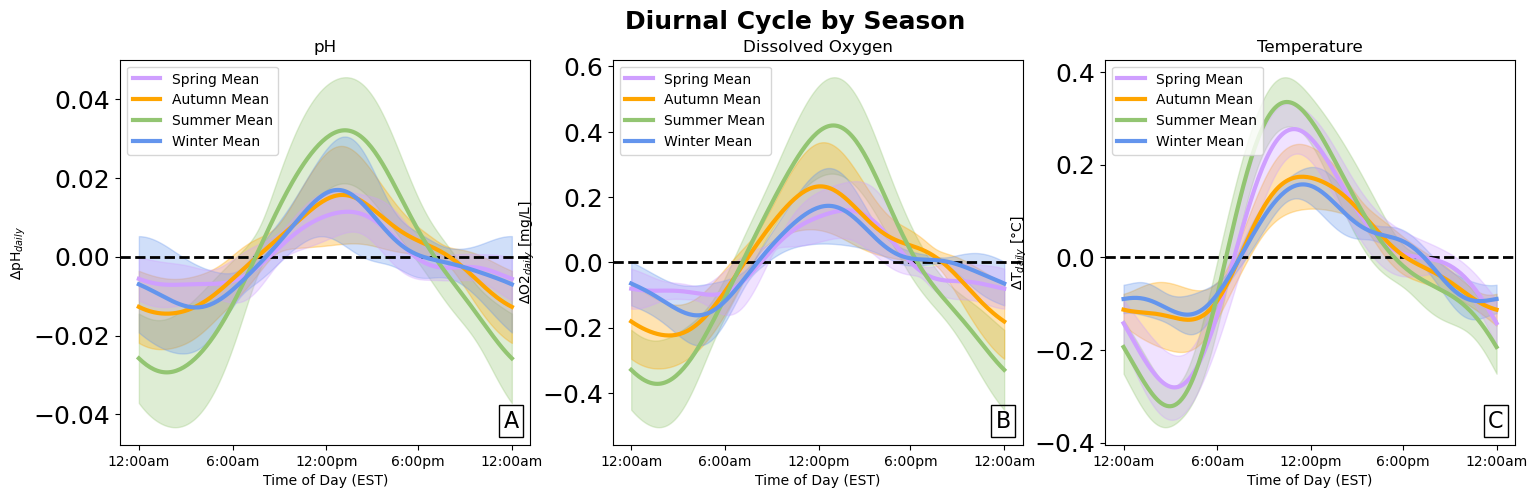

In [607]:
fig, axarr = plt.subplots(ncols = 3, figsize = [18,5])
axarr = axarr.flatten()

# pH
ax = axarr[0]
ax.fill_between(df['Time'], summerph + summerphstd, summerph - summerphstd, 
                alpha = 0.3, color = junclr)
ax.fill_between(df['Time'], fallph + fallphstd, fallph - fallphstd, 
                alpha = 0.3, color = sepclr)
ax.fill_between(df['Time'], winterph + winterphstd, winterph - winterphstd, 
                alpha = 0.3, color = decclr)
ax.fill_between(df['Time'], springph + springphstd, springph - springphstd, 
                alpha = 0.3, color = mayclr)

ax.plot(df['Time'], springph, lw = 3,
       color = mayclr, label = 'Spring Mean', zorder = 3)
ax.plot(df['Time'], fallph, lw = 3,
       color = sepclr, label = 'Autumn Mean', zorder = 3)
ax.plot(df['Time'], summerph, lw = 3,
       color = junclr, label = 'Summer Mean', zorder = 3)
ax.plot(df['Time'], winterph, lw = 3,
       color = decclr, label = 'Winter Mean', zorder = 3)

ax.set_ylabel('∆pH$_{daily}$')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('pH')


# Oxygen
ax = axarr[1]
ax.fill_between(df['Time'], summero2 + summero2std, summero2 - summero2std, 
                alpha = 0.3, color = junclr)
ax.fill_between(df['Time'], fallo2 + fallo2std, fallo2 - fallo2std, 
                alpha = 0.3, color = sepclr)
ax.fill_between(df['Time'], wintero2 + wintero2std, wintero2 - wintero2std, 
                alpha = 0.3, color = decclr)
ax.fill_between(df['Time'], springo2 + springo2std, springo2 - springo2std, 
                alpha = 0.3, color = mayclr)

ax.plot(df['Time'], springo2, lw = 3,
       color = mayclr, label = 'Spring Mean', zorder = 3)
ax.plot(df['Time'], fallo2, lw = 3,
       color = sepclr, label = 'Autumn Mean', zorder = 3)
ax.plot(df['Time'], summero2, lw = 3,
       color = junclr, label = 'Summer Mean', zorder = 3)
ax.plot(df['Time'], wintero2, lw = 3,
       color = decclr, label = 'Winter Mean', zorder = 3)

ax.set_ylabel('∆O2$_{daily}$ [mg/L]')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('Dissolved Oxygen')


# temperature
ax = axarr[2]
ax.fill_between(df['Time'], summert + summertstd, summert - summertstd, 
                alpha = 0.3, color = junclr)
ax.fill_between(df['Time'], fallt + falltstd, fallt - falltstd, 
                alpha = 0.3, color = sepclr)
ax.fill_between(df['Time'], wintert + wintertstd, wintert - wintertstd, 
                alpha = 0.3, color = decclr)
ax.fill_between(df['Time'], springt + springtstd, springt - springtstd, 
                alpha = 0.3, color = mayclr)

ax.plot(df['Time'], springt, lw = 3,
       color = mayclr, label = 'Spring Mean', zorder = 3)
ax.plot(df['Time'], fallt, lw = 3,
       color = sepclr, label = 'Autumn Mean', zorder = 3)
ax.plot(df['Time'], summert, lw = 3,
       color = junclr, label = 'Summer Mean', zorder = 3)
ax.plot(df['Time'], wintert, lw = 3,
       color = decclr, label = 'Winter Mean', zorder = 3)

ax.set_ylabel('∆T$_{daily}$ [°C]')
ax.set_xlabel('Time of Day (EST)')
ax.set_title('Temperature')


import matplotlib.transforms as mtransforms
labs = ['A', 'B', 'C']
i = 0
for ax in axarr:
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    lab = labs[i]
    i += 1
    ax.text(0.9, 0.05, lab, transform=ax.transAxes + trans,
            fontsize=16, verticalalignment='bottom', 
            bbox=dict(facecolor='none', edgecolor='k', pad=3.0))
    ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
    ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
    ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
    ax.legend(loc = 'upper left')

fig.suptitle('Diurnal Cycle by Season', fontweight = 'bold', fontsize = 18)
fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/seasonaldiurnal_err.png', bbox_inches='tight')

Text(0.5, 0.98, 'Diurnal Cycle by Season')

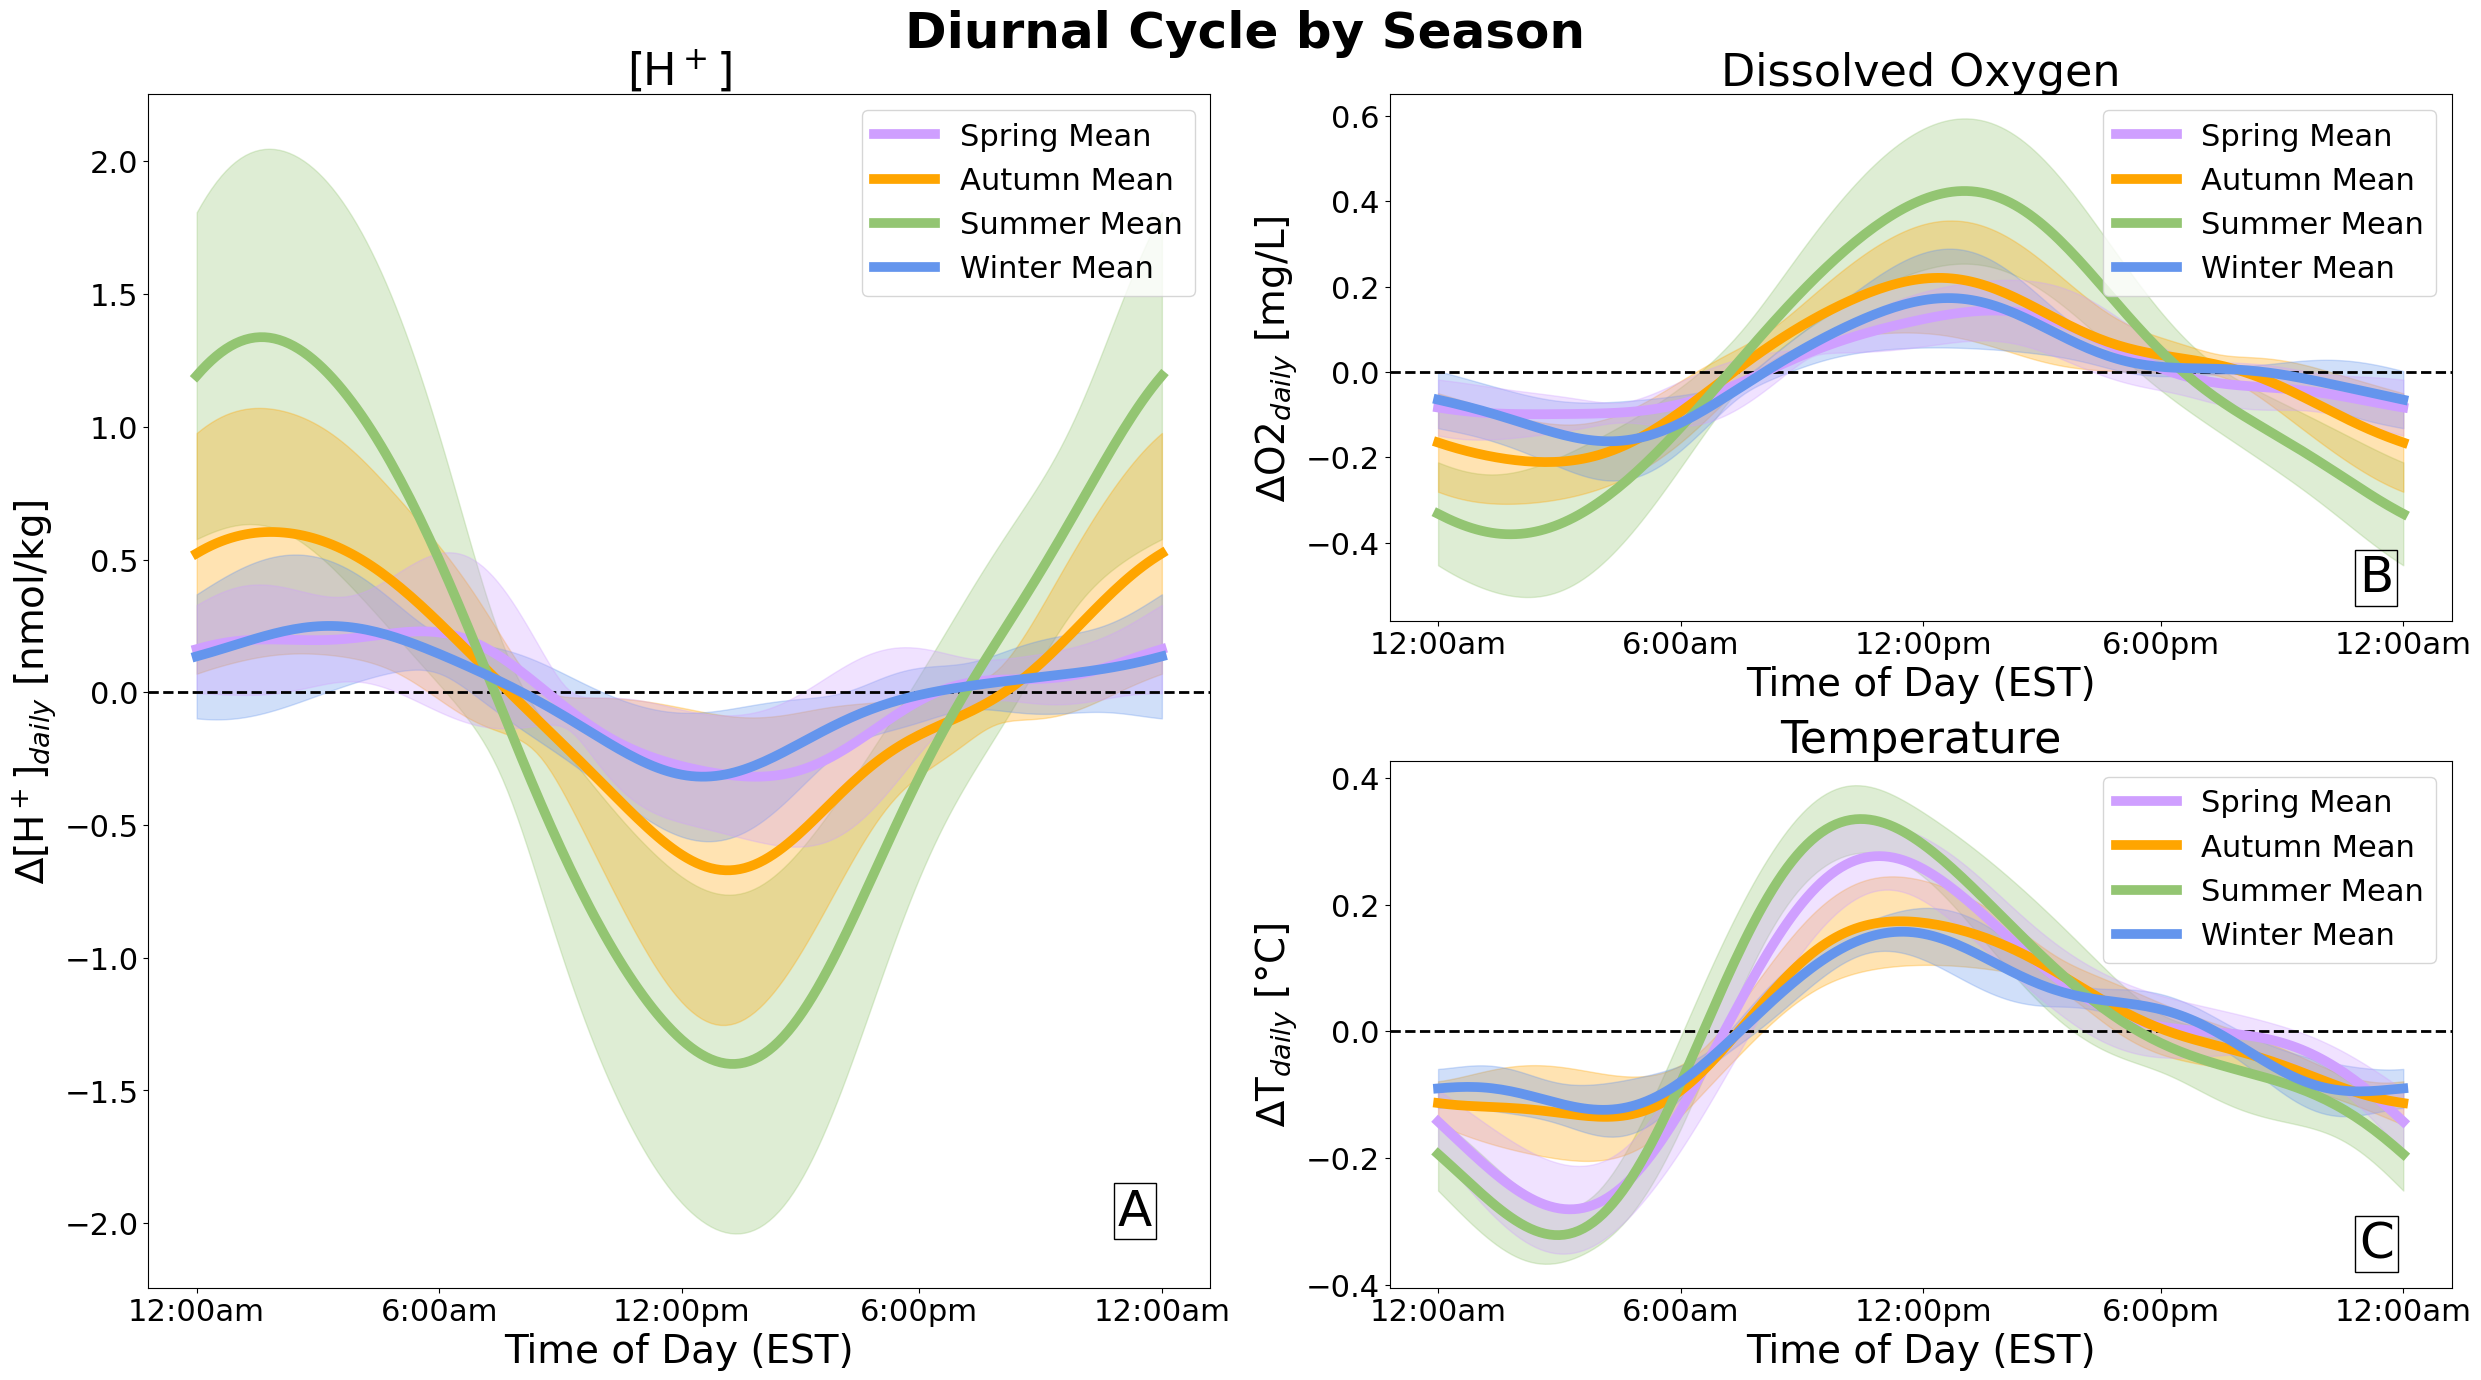

In [175]:
import matplotlib.gridspec as gridspec
import matplotlib.transforms as mtransforms
fig = plt.figure(figsize = [25,20],tight_layout=True)
gs = gridspec.GridSpec(3, 2)
LW = 7

ax = fig.add_subplot(gs[0:2, 0])
ax.fill_between(df['Time'], (summerph + summerphstd)/1e-9, (summerph - summerphstd)/1e-9, 
                alpha = 0.3, color = junclr)
ax.fill_between(df['Time'], (fallph + fallphstd)/1e-9, (fallph - fallphstd)/1e-9, 
                alpha = 0.3, color = sepclr)
ax.fill_between(df['Time'], (winterph + winterphstd)/1e-9, (winterph - winterphstd)/1e-9, 
                alpha = 0.3, color = decclr)
ax.fill_between(df['Time'], (springph + springphstd)/1e-9, (springph - springphstd)/1e-9, 
                alpha = 0.3, color = mayclr)

ax.plot(df['Time'], springph/1e-9, lw = LW, 
       color = mayclr, label = 'Spring Mean', zorder = 3)
# ax.axvline(x = df['Time'].iloc[np.argmax(springph)], ls = 'dotted', color = mayclr,
#           label = datetime.strftime(df['Time'].iloc[np.argmax(springph)], "%I:%M %p"))
# ax.axvline(x = df['Time'].iloc[np.argmin(springph)], ls = 'dashed', color = mayclr,
#           label = datetime.strftime(df['Time'].iloc[np.argmin(springph)], "%I:%M %p"))
ax.plot(df['Time'], fallph/1e-9, lw = LW, 
       color = sepclr, label = 'Autumn Mean', zorder = 3)
# ax.axvline(x = df['Time'].iloc[np.argmax(fallph)], ls = 'dotted', color = sepclr,
#           label = datetime.strftime(df['Time'].iloc[np.argmax(fallph)], "%I:%M %p"))
# ax.axvline(x = df['Time'].iloc[np.argmin(fallph)], ls = 'dashed', color = sepclr,
#           label = datetime.strftime(df['Time'].iloc[np.argmin(fallph)], "%I:%M %p"))
ax.plot(df['Time'], summerph/1e-9, lw = LW, 
       color = junclr, label = 'Summer Mean', zorder = 3)
# ax.axvline(x = df['Time'].iloc[np.argmax(summerph)], ls = 'dotted', color = junclr,
#           label = datetime.strftime(df['Time'].iloc[np.argmax(summerph)], "%I:%M %p"))
# ax.axvline(x = df['Time'].iloc[np.argmin(summerph)], ls = 'dashed', color = junclr,
#           label = datetime.strftime(df['Time'].iloc[np.argmin(summerph)], "%I:%M %p"))
ax.plot(df['Time'], winterph/1e-9, lw = LW, 
       color = decclr, label = 'Winter Mean', zorder = 3)
# ax.axvline(x = df['Time'].iloc[np.argmax(winterph)], ls = 'dotted', color = decclr,
#           label = datetime.strftime(df['Time'].iloc[np.argmax(winterph)], "%I:%M %p"))
# ax.axvline(x = df['Time'].iloc[np.argmin(winterph)], ls = 'dashed', color = decclr,
#           label = datetime.strftime(df['Time'].iloc[np.argmin(winterph)], "%I:%M %p"))

ax.set_ylabel('∆[H$^+$]$_{daily}$ [nmol/kg]', fontsize = 28)
ax.set_xlabel('Time of Day (EST)', fontsize = 28)
ax.set_title('[H$^+$]', fontsize = 32)

ax = fig.add_subplot(gs[0, 1])
ax.fill_between(df['Time'], summero2 + summero2std, summero2 - summero2std, 
                alpha = 0.3, color = junclr)
ax.fill_between(df['Time'], fallo2 + fallo2std, fallo2 - fallo2std, 
                alpha = 0.3, color = sepclr)
ax.fill_between(df['Time'], wintero2 + wintero2std, wintero2 - wintero2std, 
                alpha = 0.3, color = decclr)
ax.fill_between(df['Time'], springo2 + springo2std, springo2 - springo2std, 
                alpha = 0.3, color = mayclr)

ax.plot(df['Time'], springo2, lw = LW, 
       color = mayclr, label = 'Spring Mean', zorder = 3)
# ax.axvline(x = df['Time'].iloc[np.argmax(springo2)], ls = 'dotted', color = mayclr,
#           label = datetime.strftime(df['Time'].iloc[np.argmax(springo2)], "%I:%M %p"))
# ax.axvline(x = df['Time'].iloc[np.argmin(springo2)], ls = 'dashed', color = mayclr,
#           label = datetime.strftime(df['Time'].iloc[np.argmin(springo2)], "%I:%M %p"))
ax.plot(df['Time'], fallo2, lw = LW, 
       color = sepclr, label = 'Autumn Mean', zorder = 3)
# ax.axvline(x = df['Time'].iloc[np.argmax(fallo2)], ls = 'dotted', color = sepclr,
#           label = datetime.strftime(df['Time'].iloc[np.argmax(fallo2)], "%I:%M %p"))
# ax.axvline(x = df['Time'].iloc[np.argmin(fallo2)], ls = 'dashed', color = sepclr,
#           label = datetime.strftime(df['Time'].iloc[np.argmin(fallo2)], "%I:%M %p"))
ax.plot(df['Time'], summero2, lw = LW, 
       color = junclr, label = 'Summer Mean', zorder = 3)
# ax.axvline(x = df['Time'].iloc[np.argmax(summero2)], ls = 'dotted', color = junclr,
#           label = datetime.strftime(df['Time'].iloc[np.argmax(summero2)], "%I:%M %p"))
# ax.axvline(x = df['Time'].iloc[np.argmin(summero2)], ls = 'dashed', color = junclr,
#           label = datetime.strftime(df['Time'].iloc[np.argmin(summero2)], "%I:%M %p"))
ax.plot(df['Time'], wintero2, lw = LW, 
       color = decclr, label = 'Winter Mean', zorder = 3)
# ax.axvline(x = df['Time'].iloc[np.argmax(wintero2)], ls = 'dotted', color = decclr,
#           label = datetime.strftime(df['Time'].iloc[np.argmax(wintero2)], "%I:%M %p"))
# ax.axvline(x = df['Time'].iloc[np.argmin(wintero2)], ls = 'dashed', color = decclr,
#           label = datetime.strftime(df['Time'].iloc[np.argmin(wintero2)], "%I:%M %p"))

ax.set_ylabel('∆O2$_{daily}$ [mg/L]', fontsize = 28)
ax.set_xlabel('Time of Day (EST)', fontsize = 28)
ax.set_title('Dissolved Oxygen', fontsize = 32)

ax = fig.add_subplot(gs[1, 1])
ax.fill_between(df['Time'], summert + summertstd, summert - summertstd, 
                alpha = 0.3, color = junclr)
ax.fill_between(df['Time'], fallt + falltstd, fallt - falltstd, 
                alpha = 0.3, color = sepclr)
ax.fill_between(df['Time'], wintert + wintertstd, wintert - wintertstd, 
                alpha = 0.3, color = decclr)
ax.fill_between(df['Time'], springt + springtstd, springt - springtstd, 
                alpha = 0.3, color = mayclr)

ax.plot(df['Time'], springt, lw = LW, 
       color = mayclr, label = 'Spring Mean', zorder = 3)
ax.plot(df['Time'], fallt, lw = LW, 
       color = sepclr, label = 'Autumn Mean', zorder = 3)
ax.plot(df['Time'], summert, lw = LW, 
       color = junclr, label = 'Summer Mean', zorder = 3)
ax.plot(df['Time'], wintert, lw = LW, 
       color = decclr, label = 'Winter Mean', zorder = 3)

ax.set_ylabel('∆T$_{daily}$ [°C]', fontsize = 28)
ax.set_xlabel('Time of Day (EST)', fontsize = 28)
ax.set_title('Temperature', fontsize = 32)

labs = ['A', 'B', 'C']
i = 0
for i, ax in enumerate(fig.axes):
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    lab = labs[i]
    i += 1
    ax.text(0.9, 0.05, lab, transform=ax.transAxes + trans,
            fontsize=36, verticalalignment='bottom', 
            bbox=dict(facecolor='none', edgecolor='k', pad=3.0))
    ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
    ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'], fontsize = 18)
    ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
    ax.legend(loc = 'upper right', fontsize = 22)
    ax.xaxis.set_tick_params(labelsize=22)
    ax.yaxis.set_tick_params(labelsize=22)
    
fig.suptitle('Diurnal Cycle by Season', fontweight = 'bold', fontsize = 36)
fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/seasonaldiurnal_err_H.png', bbox_inches='tight')

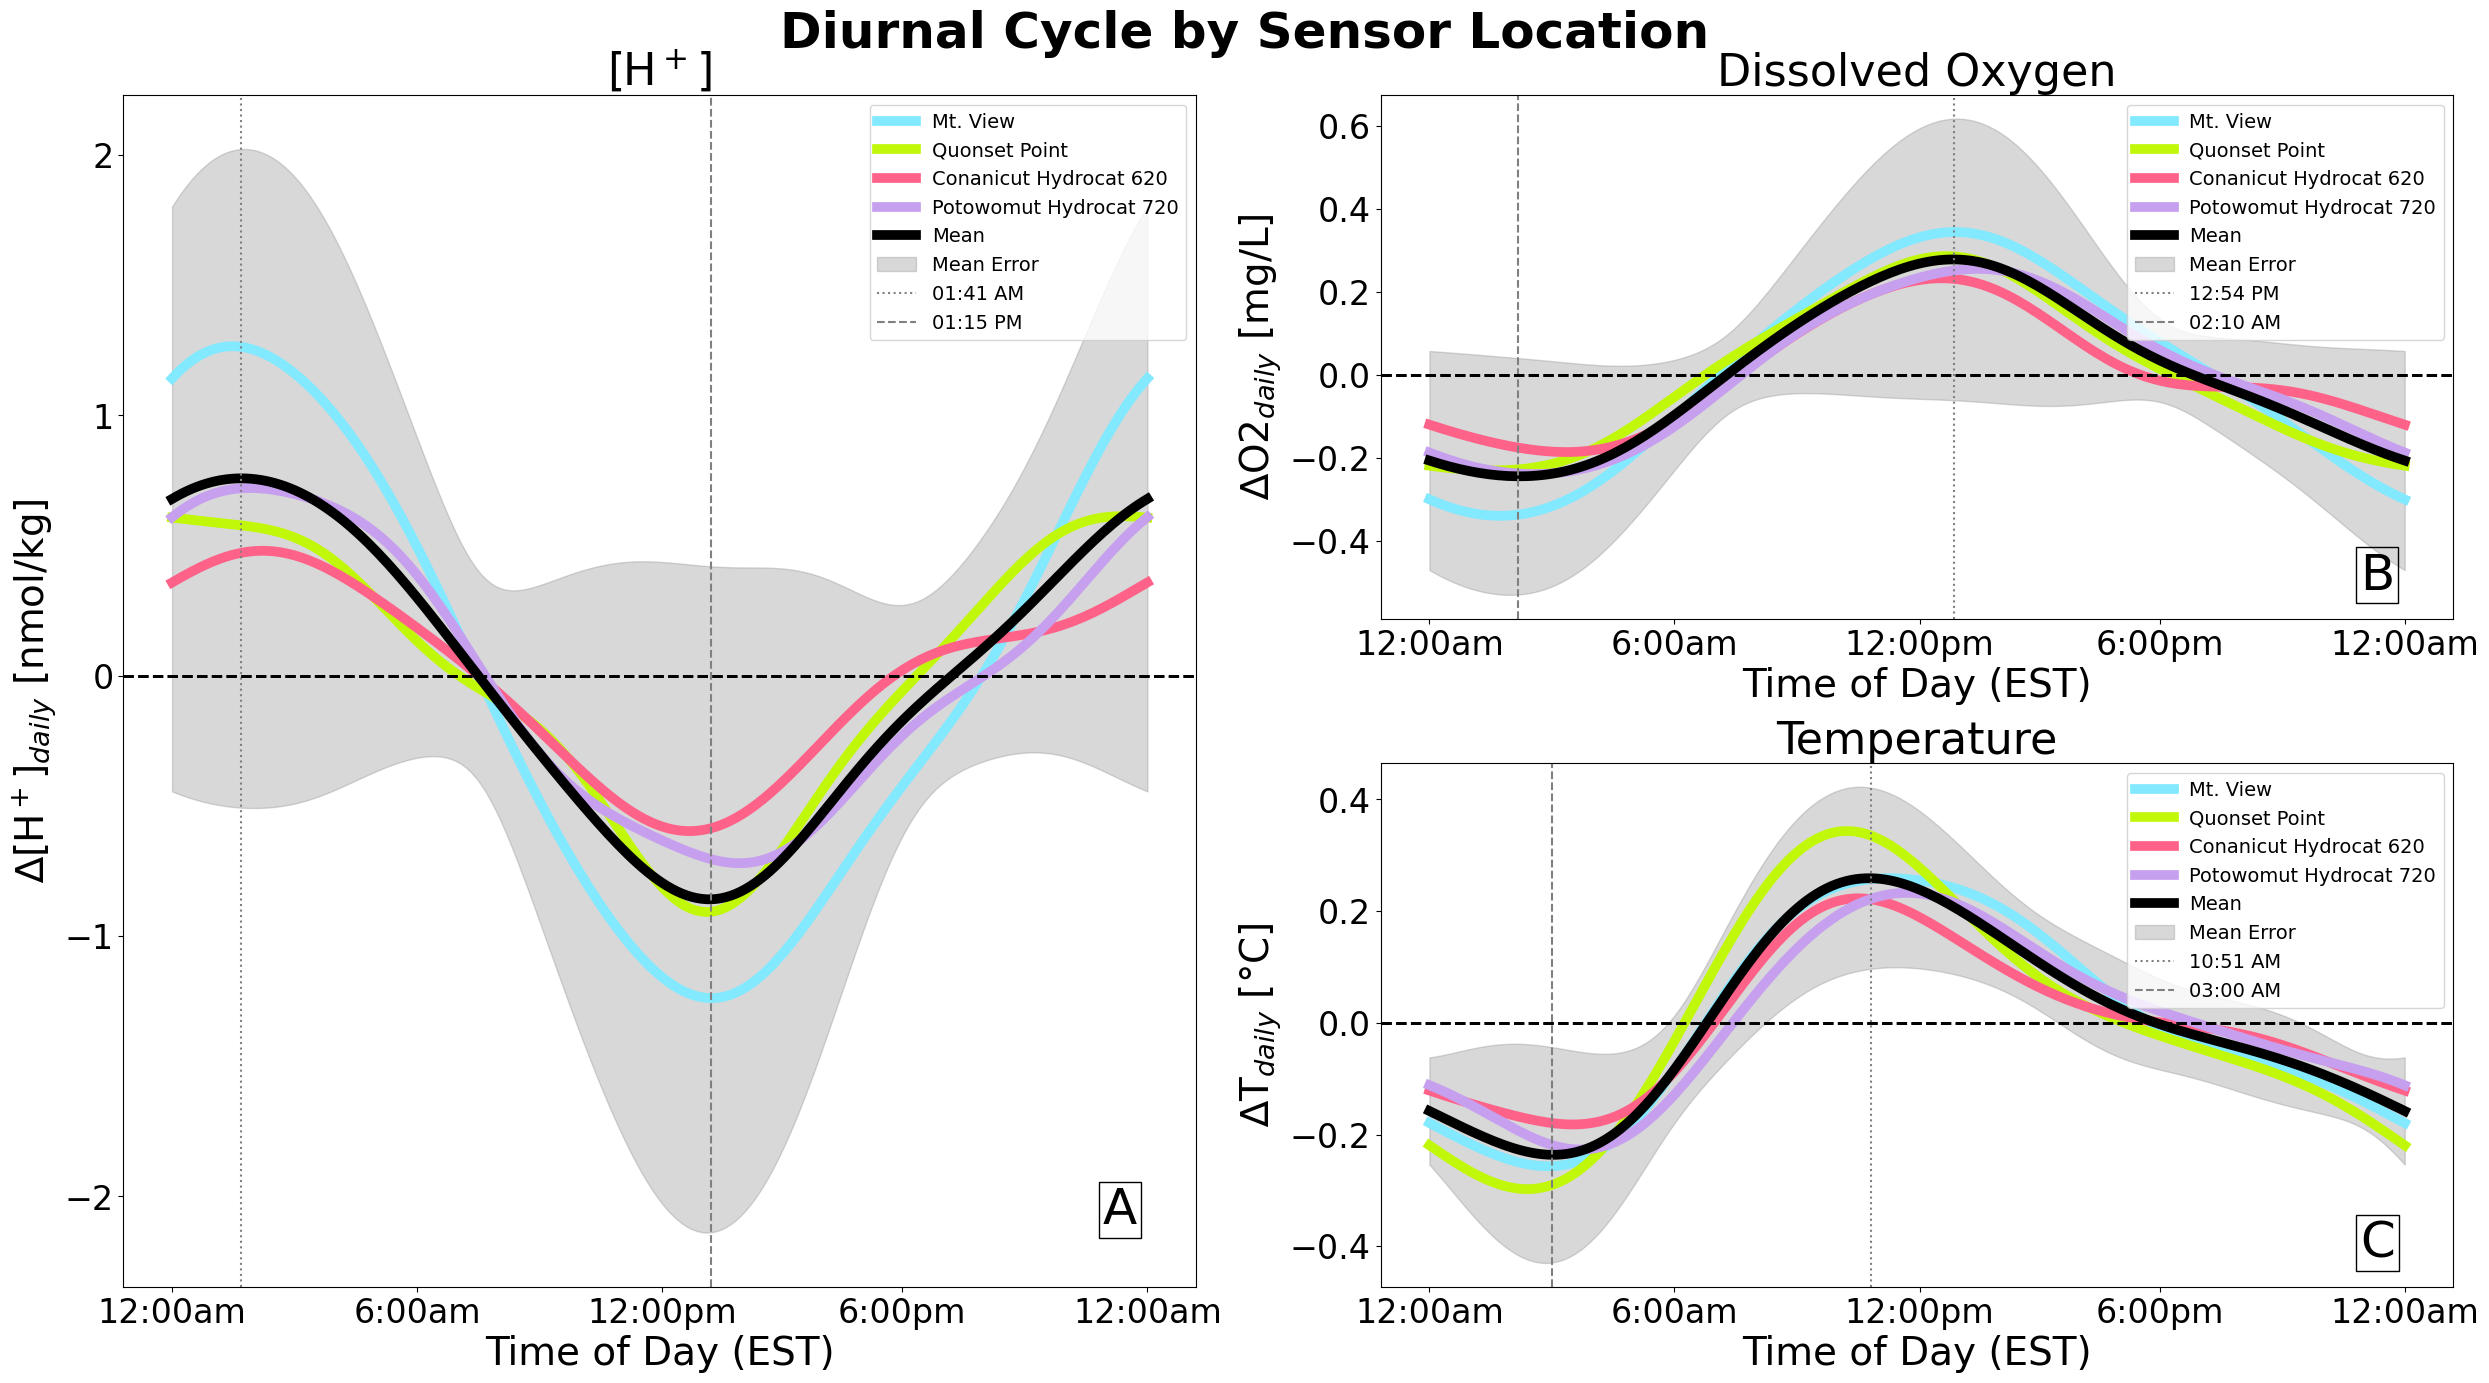

In [174]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize = [25,20],tight_layout=True)
gs = gridspec.GridSpec(3, 2)

ax = fig.add_subplot(gs[0:2, 0])
ax1 = ax
STDph = np.sqrt(qp['QP 620 Std pH']**2 + mv['MV 620 Std pH']**2 + hydro620['Hydrocat 620 Std pH']**2 + hydro720['Hydrocat 720 Std pH']**2)
MNph = (mv['MV 620 Mean pH'] + qp['QP 620 Mean pH'] + hydro620['Hydrocat 620 Mean pH'] + hydro720['Hydrocat 720 Mean pH'])/4


ax.plot(df['Time'], mv['MV 620 Mean pH']/1e-9, color = blue, lw = LW, label = 'Mt. View')
ax.plot(df['Time'], qp['QP 620 Mean pH']/1e-9, color = green, lw = LW, label = 'Quonset Point')
ax.plot(df['Time'], hydro620['Hydrocat 620 Mean pH']/1e-9, color = pink, lw = LW, label = 'Conanicut Hydrocat 620')
ax.plot(df['Time'], hydro720['Hydrocat 720 Mean pH']/1e-9, color = purple, lw = LW, label = 'Potowomut Hydrocat 720')
ax.plot(df['Time'], MN/1e-9, color = 'black', lw = LW, label = 'Mean')
ax.fill_between(df['Time'], (MN - STD)/1e-9, (MN + STD)/1e-9, color = 'gray', alpha = 0.3, label = 'Mean Error')
ax.axvline(x = df['Time'].iloc[np.argmax(MN)], ls = 'dotted', color = 'gray',
          label = datetime.strftime(df['Time'].iloc[np.argmax(MN)], "%I:%M %p"))
ax.axvline(x = df['Time'].iloc[np.argmin(MN)], ls = 'dashed', color = 'gray',
          label = datetime.strftime(df['Time'].iloc[np.argmin(MN)], "%I:%M %p"))
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)



ax.set_ylabel('∆[H$^+$]$_{daily}$ [nmol/kg]', fontsize = 28)
ax.set_xlabel('Time of Day (EST)', fontsize = 28)
ax.set_title('[H$^+$]', fontsize = 32)

ax = fig.add_subplot(gs[0, 1])
ax2 = ax
STDo2 = np.sqrt(qpo2['QP 620 Std pH']**2 + mvo2['MV 620 Std pH']**2 + hydro620o2['Hydrocat 620 Std pH']**2 + hydro720o2['Hydrocat 720 Std pH']**2)
MNo2 = (mvo2['MV 620 Mean pH'] + qpo2['QP 620 Mean pH'] + hydro620o2['Hydrocat 620 Mean pH'] + hydro720o2['Hydrocat 720 Mean pH'])/4

ax.plot(df['Time'], mvo2['MV 620 Mean pH'], color = blue, lw = LW, label = 'Mt. View')
ax.plot(df['Time'], qpo2['QP 620 Mean pH'], color = green, lw = LW, label = 'Quonset Point')
ax.plot(df['Time'], hydro620o2['Hydrocat 620 Mean pH'], color = pink, lw = LW, label = 'Conanicut Hydrocat 620')
ax.plot(df['Time'], hydro720o2['Hydrocat 720 Mean pH'], color = purple, lw = LW, label = 'Potowomut Hydrocat 720')
ax.plot(df['Time'], MNo2, color = 'black', lw = LW, label = 'Mean')
ax.fill_between(df['Time'], MNo2 - STDo2, MNo2 + STDo2, color = 'gray', alpha = 0.3, label = 'Mean Error')
ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'])
ax.axvline(x = df['Time'].iloc[np.argmax(MNo2)], ls = 'dotted', color = 'gray',
          label = datetime.strftime(df['Time'].iloc[np.argmax(MNo2)], "%I:%M %p"))
ax.axvline(x = df['Time'].iloc[np.argmin(MNo2)], ls = 'dashed', color = 'gray',
          label = datetime.strftime(df['Time'].iloc[np.argmin(MNo2)], "%I:%M %p"))
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)

ax.set_ylabel('∆O2$_{daily}$ [mg/L]', fontsize = 28)
ax.set_xlabel('Time of Day (EST)', fontsize = 28)
ax.set_title('Dissolved Oxygen', fontsize = 32)

ax = fig.add_subplot(gs[1, 1])
ax3 = ax
STDt = np.sqrt(qpt['QP 620 Std pH']**2 + mvt['MV 620 Std pH']**2 + hydro620t['Hydrocat 620 Std pH']**2 + hydro720t['Hydrocat 720 Std pH']**2)
MNt = (mvt['MV 620 Mean pH'] + qpt['QP 620 Mean pH'] + hydro620t['Hydrocat 620 Mean pH'] + hydro720t['Hydrocat 720 Mean pH'])/4

ax.plot(df['Time'], mvt['MV 620 Mean pH'], color = blue, lw = LW, label = 'Mt. View')
ax.plot(df['Time'], qpt['QP 620 Mean pH'], color = green, lw = LW, label = 'Quonset Point')
ax.plot(df['Time'], hydro620t['Hydrocat 620 Mean pH'], color = pink, lw = LW, label = 'Conanicut Hydrocat 620')
ax.plot(df['Time'], hydro720t['Hydrocat 720 Mean pH'], color = purple, lw = LW, label = 'Potowomut Hydrocat 720')
ax.plot(df['Time'], MNt, color = 'black', lw = LW, label = 'Mean')
ax.fill_between(df['Time'], MNt - STDt, MNt + STDt, color = 'gray', alpha = 0.3, label = 'Mean Error')
ax.axvline(x = df['Time'].iloc[np.argmax(MNt)], ls = 'dotted', color = 'gray',
          label = datetime.strftime(df['Time'].iloc[np.argmax(MNt)], "%I:%M %p"))
ax.axvline(x = df['Time'].iloc[np.argmin(MNt)], ls = 'dashed', color = 'gray',
          label = datetime.strftime(df['Time'].iloc[np.argmin(MNt)], "%I:%M %p"))
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)

ax.set_ylabel('∆T$_{daily}$ [°C]', fontsize = 28)
ax.set_xlabel('Time of Day (EST)', fontsize = 28)
ax.set_title('Temperature', fontsize = 32)

labs = ['A', 'B', 'C']
locs = ['upper center', 'lower center', 'lower center']
i = 0
for i, ax in enumerate(fig.axes):
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    lab = labs[i]
    ax.text(0.9, 0.05, lab, transform=ax.transAxes + trans,
            fontsize=36, verticalalignment='bottom', 
            bbox=dict(facecolor='none', edgecolor='k', pad=3.0))
    ax.set_xticks([df['Time'][0],df['Time'][50],df['Time'][100],df['Time'][149],df['Time'][199]])
    ax.set_xticklabels(['12:00am', '6:00am','12:00pm','6:00pm','12:00am'], fontsize = 18)
    ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
    ax.legend(loc = 'upper right', fontsize = 14)
    ax.xaxis.set_tick_params(labelsize=24)
    ax.yaxis.set_tick_params(labelsize=24)
    i += 1
    
fig.suptitle('Diurnal Cycle by Sensor Location', fontweight = 'bold', fontsize = 36)
fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/diurnal_err_H.png', bbox_inches='tight')

In [120]:
temp = {'pH max': [winterph.max(), springph.max(), summerph.max(), fallph.max()],
        'pH min': [winterph.min(), springph.min(), summerph.min(), fallph.min()],
        'pH max std': [winterphstd[np.argmax(winterph)], springphstd[np.argmax(springph)], 
                       summerphstd[np.argmax(summerph)], fallphstd[np.argmax(fallph)]],
        'pH min std': [winterphstd[np.argmin(winterph)], springphstd[np.argmin(springph)], 
                       summerphstd[np.argmin(summerph)], fallphstd[np.argmin(fallph)]],
        'DO max': [wintero2.max(), springo2.max(), summero2.max(), fallo2.max()],
        'DO min': [wintero2.min(), springo2.min(), summero2.min(), fallo2.min()],
        'DO max std': [wintero2std[np.argmax(wintero2)], springo2std[np.argmax(springo2)], 
                       summero2std[np.argmax(summero2)], fallo2std[np.argmax(fallo2)]],
        'DO min std': [wintero2std[np.argmin(wintero2)], springo2std[np.argmin(springo2)], 
                       summero2std[np.argmin(summero2)], fallo2std[np.argmin(fallo2)]],
        'T max': [wintert.max(), springt.max(), summert.max(), fallt.max()],
        'T min': [wintert.min(), springt.min(), summert.min(), fallt.min()],
        'T max std': [wintertstd[np.argmax(wintert)], springtstd[np.argmax(springt)], 
                       summertstd[np.argmax(summert)], falltstd[np.argmax(fallt)]],
        'T min std': [wintertstd[np.argmin(wintert)], springtstd[np.argmin(springt)], 
                       summertstd[np.argmin(summert)], falltstd[np.argmin(fallt)]],
       }
ranges = pd.DataFrame(temp, index=['winter', 'spring', 'summer', 'fall']) 
ranges

pH max        pH min    pH max std    pH min std    DO max  \
winter  2.498158e-10 -3.178932e-10  2.483124e-10  2.419489e-10  0.173081   
spring  2.293055e-10 -3.179866e-10  2.683445e-10  2.420417e-10  0.143901   
summer  1.337457e-09 -1.399948e-09  7.063057e-10  6.386288e-10  0.423809   
fall    6.036714e-10 -6.704884e-10  4.652872e-10  5.826761e-10  0.220444   

          DO min  DO max std  DO min std     T max     T min  T max std  \
winter -0.162290    0.115737    0.091624  0.157159 -0.123796   0.033721   
spring -0.098895    0.070426    0.049661  0.276474 -0.280685   0.053687   
summer -0.380082    0.170086    0.143826  0.334959 -0.321379   0.053221   
fall   -0.210992    0.132311    0.091852  0.173699 -0.134822   0.070548   

        T min std  
winter   0.041475  
spring   0.069505  
summer   0.043183  
fall     0.068031

In [133]:
ranges['H range'] = (ranges['pH max'] - ranges['pH min'])/1e-9
ranges['H std'] = (np.sqrt(ranges['pH max std']**2 + ranges['pH min std']**2))/1e-9
ranges['DO range'] = ranges['DO max'] - ranges['DO min']
ranges['DO std'] = np.sqrt(ranges['DO max std']**2 + ranges['DO min std']**2)
ranges['T range'] = ranges['T max'] - ranges['T min']
ranges['T std'] = np.sqrt(ranges['T max std']**2 + ranges['T min std']**2)
ranges[['H range', 'H std', 'DO range', 'DO std', 'T range', 'T std']]

for ind in ranges.index:
    Hrange = str(round(ranges.loc[ind]['H range'],4)) + ' ± ' + str(round(ranges.loc[ind]['H std'],4))
    print(str(ind) + ' H range = ' + Hrange + ' nmol/kg')
    
    DOrange = str(round(ranges.loc[ind]['DO range'],4)) + ' ± ' + str(round(ranges.loc[ind]['DO std'],4))
    print(str(ind) + ' DO range = ' + DOrange + ' mg/L')
    
    Trange = str(round(ranges.loc[ind]['T range'],4)) + ' ± ' + str(round(ranges.loc[ind]['T std'],4))
    print(str(ind) + ' T range = ' + Trange + '°C')

winter H range = 0.5677 ± 0.3467 nmol/kg
winter DO range = 0.3354 ± 0.1476 mg/L
winter T range = 0.281 ± 0.0535°C
spring H range = 0.5473 ± 0.3614 nmol/kg
spring DO range = 0.2428 ± 0.0862 mg/L
spring T range = 0.5572 ± 0.0878°C
summer H range = 2.7374 ± 0.9522 nmol/kg
summer DO range = 0.8039 ± 0.2227 mg/L
summer T range = 0.6563 ± 0.0685°C
fall H range = 1.2742 ± 0.7457 nmol/kg
fall DO range = 0.4314 ± 0.1611 mg/L
fall T range = 0.3085 ± 0.098°C


In [193]:
# MN.min()/1e-9
STD.iloc[np.argmin(MN)]

1.2791335248166449e-09

In [142]:
temp = {'pH max time': [df['Time'].iloc[np.argmax(winterph)], 
                        df['Time'].iloc[np.argmax(springph)], 
                        df['Time'].iloc[np.argmax(summerph)], 
                        df['Time'].iloc[np.argmax(fallph)]],
        'pH min time': [df['Time'].iloc[np.argmin(winterph)], 
                        df['Time'].iloc[np.argmin(springph)], 
                        df['Time'].iloc[np.argmin(summerph)], 
                        df['Time'].iloc[np.argmin(fallph)]],
        'DO max time': [df['Time'].iloc[np.argmax(wintero2)], 
                        df['Time'].iloc[np.argmax(springo2)], 
                        df['Time'].iloc[np.argmax(summero2)], 
                        df['Time'].iloc[np.argmax(fallo2)]],
        'DO min time': [df['Time'].iloc[np.argmin(wintero2)], 
                        df['Time'].iloc[np.argmin(springo2)], 
                        df['Time'].iloc[np.argmin(summero2)], 
                        df['Time'].iloc[np.argmin(fallo2)]],
        'T max time':  [df['Time'].iloc[np.argmax(wintert)], 
                        df['Time'].iloc[np.argmax(springt)], 
                        df['Time'].iloc[np.argmax(summert)], 
                        df['Time'].iloc[np.argmax(fallt)]],
        'T min time':  [df['Time'].iloc[np.argmin(wintert)], 
                        df['Time'].iloc[np.argmin(springt)], 
                        df['Time'].iloc[np.argmin(summert)], 
                        df['Time'].iloc[np.argmin(fallt)]],
       }
times = pd.DataFrame(temp, index=['winter', 'spring', 'summer', 'fall']) 
times

pH max time                   pH min time  \
winter 2017-01-01 03:15:22.613065216 2017-01-01 12:32:33.768844288   
spring 2017-01-01 05:32:51.859296512 2017-01-01 13:52:09.648241152   
summer 2017-01-01 01:34:04.221105408 2017-01-01 13:23:12.964824064   
fall   2017-01-01 01:48:32.562813952 2017-01-01 13:08:44.623115520   

                         DO max time                   DO min time  \
winter 2017-01-01 12:39:47.939698432 2017-01-01 04:13:15.979899392   
spring 2017-01-01 13:44:55.477387008 2017-01-01 02:24:43.417085440   
summer 2017-01-01 13:08:44.623115520 2017-01-01 01:48:32.562813952   
fall   2017-01-01 12:25:19.597989888 2017-01-01 02:39:11.758793984   

                          T max time                    T min time  
winter 2017-01-01 11:34:40.402010112 2017-01-01 04:06:01.809045248  
spring 2017-01-01 10:58:29.547738624 2017-01-01 03:15:22.613065216  
summer 2017-01-01 10:29:32.864321536 2017-01-01 03:00:54.271356672  
fall   2017-01-01 11:27:26.231155712 2017-01-01 04:06:01.809045248

In [157]:
np.abs(datetime(2017,1,1,3,0) - times['pH max time'])

winter   0 days 00:15:22.613065216
spring   0 days 02:32:51.859296512
summer   0 days 01:25:55.778894592
fall     0 days 01:11:27.437186048
Name: pH max time, dtype: timedelta64[ns]

In [163]:
hmaxtime = datetime(2017,1,1,1,41)
hmintime = datetime(2017,1,1,13,15)
domaxtime = datetime(2017,1,1,12,47)
domintime = datetime(2017,1,1,2,3)
tmaxtime = datetime(2017,1,1,10,51)
tmintime = datetime(2017,1,1,3,0)

In [171]:
for ind in times.index:
    dhmaxtime = np.abs(times.loc[ind]['pH max time'] - hmaxtime)
    if hmaxtime < times.loc[ind]['pH max time']:
        print(str(ind) + ' H max: ' + str(dhmaxtime))
    else:
        print(str(ind) + ' H max: -' + str(dhmaxtime))
        
    dhmintime = np.abs(times.loc[ind]['pH min time'] - hmintime)
    if hmintime < times.loc[ind]['pH min time']:
        print(str(ind) + ' H min: ' + str(dhmintime))
    else:
        print(str(ind) + ' H min: -' + str(dhmintime))
    

winter H max: 0 days 01:34:22.613065216
winter H min: -0 days 00:42:26.231155712
spring H max: 0 days 03:51:51.859296512
spring H min: 0 days 00:37:09.648241152
summer H max: -0 days 00:06:55.778894592
summer H min: 0 days 00:08:12.964824064
fall H max: 0 days 00:07:32.562813952
fall H min: -0 days 00:06:15.376884480


In [172]:
for ind in times.index:
    ddomaxtime = np.abs(times.loc[ind]['DO max time'] - domaxtime)
    if domaxtime < times.loc[ind]['DO max time']:
        print(str(ind) + ' DO max: ' + str(ddomaxtime))
    else:
        print(str(ind) + ' DO max: -' + str(ddomaxtime))
        
    ddomintime = np.abs(times.loc[ind]['DO min time'] - domintime)
    if domintime < times.loc[ind]['DO min time']:
        print(str(ind) + ' DO min: ' + str(ddomintime))
    else:
        print(str(ind) + ' DO min: -' + str(ddomintime))

winter DO max: -0 days 00:07:12.060301568
winter DO min: 0 days 02:10:15.979899392
spring DO max: 0 days 00:57:55.477387008
spring DO min: 0 days 00:21:43.417085440
summer DO max: 0 days 00:21:44.623115520
summer DO min: -0 days 00:14:27.437186048
fall DO max: -0 days 00:21:40.402010112
fall DO min: 0 days 00:36:11.758793984


In [173]:
for ind in times.index:
    dtmaxtime = np.abs(times.loc[ind]['T max time'] - tmaxtime)
    if tmaxtime < times.loc[ind]['T max time']:
        print(str(ind) + ' T max: ' + str(dtmaxtime))
    else:
        print(str(ind) + ' T max: -' + str(dtmaxtime))
        
    dtmintime = np.abs(times.loc[ind]['T min time'] - tmintime)
    if tmintime < times.loc[ind]['T min time']:
        print(str(ind) + ' T min: ' + str(dtmintime))
    else:
        print(str(ind) + ' T min: -' + str(dtmintime))

winter T max: 0 days 00:43:40.402010112
winter T min: 0 days 01:06:01.809045248
spring T max: 0 days 00:07:29.547738624
spring T min: 0 days 00:15:22.613065216
summer T max: -0 days 00:21:27.135678464
summer T min: 0 days 00:00:54.271356672
fall T max: 0 days 00:36:26.231155712
fall T min: 0 days 01:06:01.809045248
